# Metrics

### Import

In [1]:
%load_ext autoreload
%autoreload 2

import os
PROJECT_PATH = "/projects/compures/alexandre/disdiff_adapters"
os.chdir(PROJECT_PATH)
print(os.getcwd())

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from scipy.special import digamma, gammaln
import numpy as np
from collections import Counter, defaultdict
from math import log
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset
from lightning import Trainer

from tqdm import tqdm

#DataModule
from disdiff_adapters.data_module import *
#Dataset
from disdiff_adapters.dataset import *
#Module
from disdiff_adapters.arch.multi_distillme import *
#utils
from disdiff_adapters.utils import *
#loss   
from disdiff_adapters.loss import *
#metric
from disdiff_adapters.metric import FactorVAEScore

from disdiff_adapters.arch.multi_distillme.xfactors import Xfactors
BATCH_SIZE = 2**19
LATENT_DIM_S = 126
LATENT_DIM_T = 2
is_pca = False

torch.set_float32_matmul_precision('medium')

/import/pr_compures/alexandre/disdiff_adapters


/projects/compures/alexandre/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ckpt md
ckpt_path_shapes = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_val/shapes/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=30_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_/checkpoints/epoch=7-step=76800.ckpt"
ckpt_path_shapes_100 = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_beta_t100/shapes/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(1.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0__/checkpoints/best-epoch=004.ckpt"
ckpt_path_dsprites = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_val/dsprites/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=0/checkpoints/best-epoch=029.ckpt"
ckpt_path_dsprites_100 = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/debug/dsprites/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0__/checkpoints/last.ckpt"
ckpt_path_celeba = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_val/celeba/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=30_beta=(500.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_/checkpoints/last.ckpt"
ckpt_path_celeba_100="/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_beta_t100/celeba/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0__/checkpoints/last.ckpt"
ckpt_path_celeba_500 = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_beta_t100/celeba/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(500.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0__/checkpoints/last.ckpt"
ckpt_path_mpi3d_100="/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_beta_t100/mpi3d/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"
ckpt_path_mpi3d = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_val/mpi3d/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"
ckpt_path_mpi3d_500 = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_beta_t500/mpi3d/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(100.0,500.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"

In [3]:
# ckpt x
ckpt_path_x_celeba = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/celeba/loss_vae_nce/factor0,15,26/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"
ckpt_path_x_dsprites = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"
ckpt_path_x_shapes = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/shapes/loss_vae_nce/factor0,1,2,3,4,5/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"
ckpt_path_x_mpi3d = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"

In [2]:
root_b1 = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1"
root_b100 = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100"
root_b1_t3 = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3"

shapes_path_dict = {"b1":
                    {"-1":root_b1+"/shapes/loss_vae_nce/factor0,1,2,3,4,5/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt", 
                     "s-1":root_b1+"/shapes/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/checkpoints/best-epoch=055.ckpt"}, 
                    "b100":
                    {"-1":root_b100+"", 
                     "s-1":root_b100+"/shapes/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/checkpoints/last.ckpt"},
                    "b1_t3": 
                    {"s-1":root_b1_t3+"/shapes/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"}}

dsprites_path_dict = {"b1":
                    {"-1":root_b1+"/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt", 
                     "s-1":root_b1+"/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/checkpoints/last.ckpt"}, 
                    "b100":
                    {"-1":root_b100+"", 
                     "s-1":root_b100+"/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/checkpoints/last.ckpt"},
                    "b1_t3": 
                    {"s-1":root_b1_t3+"/dsprites/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"}}

mpi3d_path_dict = {"b1":
                    {"-1":root_b1+"/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt", 
                     "s-1":root_b1+"/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/checkpoints/last.ckpt"}, 
                    "b100":
                    {"-1":root_b100+"", 
                     "s-1":root_b100+"/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/checkpoints/last.ckpt"},
                    "b1_t3": 
                    {"s-1":root_b1_t3+"/mpi3d/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"}}


ckpt_path_x = {"shapes": shapes_path_dict,
               "dsprites": dsprites_path_dict,
                "mpi3d": mpi3d_path_dict }

## Compute metrics

### FactorVAE

#### Automatisation

##### V0

In [3]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from os.path import join
from os import mkdir
from collections import Counter, defaultdict
from tqdm import tqdm
import yaml
import re

from disdiff_adapters.data_module import LatentDataModule

class FactorVAEScore :

    def __init__(self, ckpt_path: str, is_pca: bool=False, data_name: str=None) :
        self.ckpt_path = ckpt_path
        self.data_name = self.get_cfg()[-1] if data_name is None else data_name
        self.is_pca = is_pca

        z_s_tr, z_t_tr, label_tr, z_s_te, z_t_te, label_te = self.load_latent()   


        Z_tr = torch.cat([z_s_tr, z_t_tr], dim=1).cpu().numpy()        
        Z_tr = (Z_tr - Z_tr.mean(axis=0, keepdims=True)) / (Z_tr.std(axis=0, keepdims=True) + 1e-8)
        Y_tr = label_tr.cpu().numpy().astype(np.int64)              

        self.mus_train = Z_tr.T                                   
        self.ys_train  = Y_tr.T
        print("Train data formated.")                                    

        Z_te = torch.cat([z_s_te, z_t_te], dim=1).cpu().numpy()        
        Z_te = (Z_te - Z_te.mean(axis=0, keepdims=True)) / (Z_te.std(axis=0, keepdims=True) + 1e-8)
        Y_te = label_te.cpu().numpy().astype(np.int64)              

        self.mus_test = Z_te.T                                   
        self.ys_test  = Y_te.T   
        print("Test data formated.") 

        self.rng = np.random.default_rng(0)
        
    def load_latent(self):
        latent = LatentDataModule(standard=True, 
                                batch_size=2**19,
                                pref_gpu=2,
                                data_name=self.data_name,
                                ckpt_path=self.ckpt_path)
        
        print("Prepare data: test if .npz files exist.")
        latent.prepare_data()

        print("Start loading train batch.")
        latent.setup("fit")
        latent_loader = latent.train_dataloader()
        batch = next(iter(latent_loader))
        z_s_tr, z_t_tr, label_tr = batch
        print(f"Train batch shape: {z_s_tr.shape, z_t_tr.shape, label_tr.shape}")

        print("Start loading test batch.")
        latent.setup("test")
        print("Start loading test batch. - end setup")
        latent_test_loader = latent.test_dataloader()
        print("Start loading test batch. -end dataloader")
        batch = next(iter(latent_test_loader))
        z_s_te, z_t_te, label_te = batch
        print(f"Test batch shape: {z_s_te.shape, z_t_te.shape, label_te.shape}")

        self.FACTOR_NAMES = latent.Data_class.Params.FACTORS_IN_ORDER

        if self.is_pca:
            print("Start PCA.")
            #train
            pca_t_tr = PCA(n_components=1) 
            pca_s_tr = PCA(n_components=1)
            z_t_tr = pca_t_tr.fit_transform(z_t_tr)
            z_s_tr = pca_s_tr.fit_transform(z_s_tr)
            print(z_s_tr.shape, z_t_tr.shape)
            if not isinstance(z_t_tr, torch.Tensor) : z_t_tr = torch.tensor(z_t_tr)
            if not isinstance(z_s_tr, torch.Tensor) : z_s_tr = torch.tensor(z_s_tr)

            #test
            pca_t_te = PCA(n_components=1) 
            pca_s_te = PCA(n_components=1)
            z_t_te = pca_t_te.fit_transform(z_t_te)
            z_s_te = pca_s_te.fit_transform(z_s_te)
            print(z_s_te.shape, z_t_te.shape)
            if not isinstance(z_t_te, torch.Tensor) : z_t_te = torch.tensor(z_t_te)
            if not isinstance(z_s_te, torch.Tensor) : z_s_te = torch.tensor(z_s_te)
            print("End PCA.")
        
        return z_s_tr, z_t_tr, label_tr, z_s_te, z_t_te, label_te

    def value_index(self, ys):
        out=[]
        for k in range(ys.shape[0]):
            d={}
            for v in np.unique(ys[k]):
                d[int(v)]=np.flatnonzero(ys[k]==v)
            out.append(d)
        return out

    def collect(self, mus, ys, n_iter=20000, batch_size=64):
        z_std = mus.std(axis=1, keepdims=True); z_std[z_std==0]=1.0
        v2i = self.value_index(ys)
        argmins, labels = [], []
        print("Starting computing FactorVAE metric.")
        for _ in tqdm(range(n_iter)):
            k = self.rng.integers(0, ys.shape[0]) #Choose a factor f_k
            v = self.rng.choice(list(v2i[k].keys())) #Choose a value for f_k
            pool = v2i[k][v]
            idx = self.rng.choice(pool, size=batch_size, replace=(len(pool)<batch_size)) #Batch with f_k=v

            Z = mus[:, idx]/z_std
            d = int(Z.var(axis=1).argmin()) #get the argmin variance for this batch
            argmins.append(d); labels.append(k)
        return np.array(argmins), np.array(labels)
    
    def save(self):
        paths = self.ckpt_path.split("/")
        folder_path=""
        for k in range(len(paths)-2) :
            folder_path+= paths[k]+"/"
        folder_path+="metric"
        print(f"Saving at {folder_path}.")

        try: mkdir(folder_path)
        except FileExistsError: pass

        scores = {"dim_factor_score": self.dim_factor_score, "factor_dim_score": self.factor_dim_score}
        torch.save(scores, join(folder_path, "metric.pt"))
        
    def get_argmins(self, verbose: bool=True) :
        argmins, labels = self.collect(self.mus_test, self.ys_test, n_iter=153600, batch_size=64)
        self.argmins = argmins
        self.labels = labels
        dim_factor_score = {}
        # Taux d'association dim->facteur
        for d in np.unique(argmins):
            dim_factor_score[str(d)] = defaultdict(float)
            cnt = Counter(labels[argmins==d]) #labels[argmins==d], How many times f_k is assigned to dimension d?
            total = sum(cnt.values()) #Number of labels assigned to dimension d
            if verbose: print(f"\nDimension {d}:")
            for k,n in cnt.most_common():
                dim_factor_score[str(d)][self.FACTOR_NAMES[k]] = n/total
                if verbose: print(f"  {self.FACTOR_NAMES[k]:12s} : {n/total:5.1%}  ({n}/{total})")

        # """Dimension 0:
        #   scale        : 73.8%  (135/183)
        #   shape        : 26.2%  (48/183)
        # """ means 73.8% of labels assigned to dimension 0 are scale.


        factor_dim_score = {}
        for k in np.unique(labels):
            mask = (labels == k)
            cnt = Counter(argmins[mask])                # Combien de fois la dim d "gagne" pour le facteur k ?
            total = sum(cnt.values())
            name  = self.FACTOR_NAMES[k]
            factor_dim_score[name] = defaultdict(float)
            if verbose: print(f"\nFacteur {name}:")
            for d, n in cnt.most_common():             # tri décroissant
                if verbose: print(f"  dim {d:>3} : {n/total:5.1%}  ({n}/{total})")
                factor_dim_score[name][str(d)]=n/total

        self.factor_dim_score = factor_dim_score
        self.dim_factor_score = dim_factor_score

        self.save()

    def safe_load_yaml(self, path):
        try:
            with open(path, "r") as f:
                text = f.read()
            # Supprimer les lignes contenant !!python/name:
            text = re.sub(r"!!python/name:[^\n]*", "''", text)
            return yaml.safe_load(text)
        except FileNotFoundError as e : raise e

    def get_cfg(self):
        root_path = self.ckpt_path.split("/")[:-2]
        data_name = str(root_path[-6])
        root_path.append("hparams.yaml")
        hparams_path = join(*root_path)
        hparams_path="/"+hparams_path
        try : 
            cfg = self.safe_load_yaml(hparams_path)
            return int(cfg["latent_dim_t"]), int(cfg["latent_dim_s"]), int(cfg["select_factor"]), str(data_name)
        except FileNotFoundError as e : 
            print(e)
            return 0, 0, 0

    def get_score(self):
        if not hasattr(self, "argmins") : self.get_argmins()
        N = len(self.argmins)
        tp = 0
        dim_t, dim_s, select_factor, _ = self.get_cfg()
        dims_t = [dim_s+k for k in range(dim_t)]

        for dim, factor in zip(self.argmins, self.labels):

            if dim in dims_t :
                if factor == select_factor : tp+=1
            if dim not in dims_t :
                if factor != select_factor : tp+=1
        print(f"FactorVAEScore: {tp/N}")

##### V1

In [3]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from os.path import join
from os import mkdir
from collections import Counter, defaultdict
from tqdm import tqdm
import yaml
import re

from disdiff_adapters.data_module import LatentDataModule

class FactorVAEScore :

    def __init__(self, ckpt_path: str, is_pca: bool=False, n_iter=153600, batch_size=64) :
        self.ckpt_path = ckpt_path
        self.data_name = self.get_cfg()[-1]
        self.is_pca = is_pca
        self.n_iter = n_iter
        self.batch_size = batch_size

        z_s_te, z_t_te, label_te = self.load_latent()                                  

        Z_te = torch.cat([z_s_te, z_t_te], dim=1).cpu().numpy()        
        Z_te = (Z_te - Z_te.mean(axis=0, keepdims=True)) / (Z_te.std(axis=0, keepdims=True) + 1e-8)
        Y_te = label_te.cpu().numpy().astype(np.int64)              

        self.mus_test = Z_te.T                                   
        self.ys_test  = Y_te.T   
        print("Test data formated.") 

        self.rng = np.random.default_rng(0)
    
    def set_batch_size(self, batch_size: int) :
        self.batch_size = batch_size

    def set_n_iter(self, n_iter: int):
        self.n_iter = n_iter
        
    def load_latent(self):
        latent = LatentDataModule(standard=True, 
                                batch_size=2**19,
                                pref_gpu=2,
                                data_name=self.data_name,
                                ckpt_path=self.ckpt_path)
        
        print("Prepare data: test if .npz files exist.")
        latent.prepare_data()

        print("Start loading test batch.")
        latent.setup("test")
        print("Start loading test batch. - end setup")
        latent_test_loader = latent.test_dataloader()
        print("Start loading test batch. -end dataloader")
        batch = next(iter(latent_test_loader))
        z_s_te, z_t_te, label_te = batch
        print(f"Test batch shape: {z_s_te.shape, z_t_te.shape, label_te.shape}")

        self.FACTOR_NAMES = latent.Data_class.Params.FACTORS_IN_ORDER

        if self.is_pca:
            print("Start PCA.")
            #test
            pca_t_te = PCA(n_components=1) 
            pca_s_te = PCA(n_components=1)
            z_t_te = pca_t_te.fit_transform(z_t_te)
            z_s_te = pca_s_te.fit_transform(z_s_te)
            print(z_s_te.shape, z_t_te.shape)
            if not isinstance(z_t_te, torch.Tensor) : z_t_te = torch.tensor(z_t_te)
            if not isinstance(z_s_te, torch.Tensor) : z_s_te = torch.tensor(z_s_te)
            print("End PCA.")
        
        return z_s_te, z_t_te, label_te

    def value_index(self, ys):
        out=[]
        for k in range(ys.shape[0]):
            d={}
            for v in np.unique(ys[k]):
                d[int(v)]=np.flatnonzero(ys[k]==v)
            out.append(d)
        return out

    def collect(self, mus, ys, n_iter, batch_size=64):
        z_std = mus.std(axis=1, keepdims=True); z_std[z_std==0]=1.0
        v2i = self.value_index(ys)
        argmins, labels = [], []
        print("Starting computing FactorVAE metric.")
        for _ in tqdm(range(n_iter)):
            k = self.rng.integers(0, ys.shape[0]) #Choose a factor f_k
            v = self.rng.choice(list(v2i[k].keys())) #Choose a value for f_k
            pool = v2i[k][v]
            idx = self.rng.choice(pool, size=batch_size, replace=(len(pool)<batch_size)) #Batch with f_k=v

            Z = mus[:, idx]/z_std
            d = int(Z.var(axis=1).argmin()) #get the argmin variance for this batch
            argmins.append(d); labels.append(k)
        return np.array(argmins), np.array(labels)
    
    def save(self):
        paths = self.ckpt_path.split("/")
        folder_path=""
        for k in range(len(paths)-2) :
            folder_path+= paths[k]+"/"
        folder_path+="metric"
        print(f"Saving at {folder_path}.")

        try: mkdir(folder_path)
        except FileExistsError: pass

        scores = {"dim_factor_score": self.dim_factor_score, "factor_dim_score": self.factor_dim_score}
        torch.save(scores, join(folder_path, "metric.pt"))
        
    def get_argmins(self, verbose: bool=True) :
        argmins, labels = self.collect(self.mus_test, self.ys_test, self.n_iter, self.batch_size)
        self.argmins = argmins
        self.labels = labels
        dim_factor_score = {}
        # Taux d'association dim->facteur
        for d in np.unique(argmins):
            dim_factor_score[str(d)] = defaultdict(float)
            cnt = Counter(labels[argmins==d]) #labels[argmins==d], How many times f_k is assigned to dimension d?
            total = sum(cnt.values()) #Number of labels assigned to dimension d
            if verbose: print(f"\nDimension {d}:")
            for k,n in cnt.most_common():
                dim_factor_score[str(d)][self.FACTOR_NAMES[k]] = n/total
                if verbose: print(f"  {self.FACTOR_NAMES[k]:12s} : {n/total:5.1%}  ({n}/{total})")

        # """Dimension 0:
        #   scale        : 73.8%  (135/183)
        #   shape        : 26.2%  (48/183)
        # """ means 73.8% of labels assigned to dimension 0 are scale.


        factor_dim_score = {}
        for k in np.unique(labels):
            mask = (labels == k)
            cnt = Counter(argmins[mask])                # Combien de fois la dim d "gagne" pour le facteur k ?
            total = sum(cnt.values())
            name  = self.FACTOR_NAMES[k]
            factor_dim_score[name] = defaultdict(float)
            if verbose: print(f"\nFacteur {name}:")
            for d, n in cnt.most_common():             # tri décroissant
                if verbose: print(f"  dim {d:>3} : {n/total:5.1%}  ({n}/{total})")
                factor_dim_score[name][str(d)]=n/total

        self.factor_dim_score = factor_dim_score
        self.dim_factor_score = dim_factor_score

        self.save()

    def safe_load_yaml(self, path):
        try:
            with open(path, "r") as f:
                text = f.read()
            # Supprimer les lignes contenant !!python/name:
            text = re.sub(r"!!python/name:[^\n]*", "''", text)
            return yaml.safe_load(text)
        except FileNotFoundError as e : raise e

    def get_cfg(self):
        root_path = self.ckpt_path.split("/")[:-2]
        data_name = str(root_path[-6])
        root_path.append("hparams.yaml")
        hparams_path = join(*root_path)
        hparams_path="/"+hparams_path
        try : 
            cfg = self.safe_load_yaml(hparams_path)
            return int(cfg["latent_dim_t"]), int(cfg["latent_dim_s"]), int(cfg["select_factor"]), str(data_name)
        except FileNotFoundError as e : 
            print(e)
            return 0, 0, 0

    def get_score(self):
        self.get_argmins()
        N = len(self.argmins)
        tp = tn = fp = fn = 0

        dim_t, dim_s, select_factor, _ = self.get_cfg()
        dims_t = set(dim_s + k for k in range(dim_t))

        # vérité terrain = (factor == select_factor)
        # prédiction     = (dim in dims_t)
        for dim, factor in zip(self.argmins, self.labels):
            y_true = (factor == select_factor)
            y_pred = (dim in dims_t)
            if y_true and y_pred: tp += 1
            elif y_true and not y_pred: fn += 1
            elif not y_true and not y_pred: tn += 1
            else: fp += 1

        # Accuracy brute (majority-driven)
        acc = (tp + tn) / N

        # Taux par classe
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # sensibilité (rappel positif)
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # spécificité (rappel négatif)

        # Balanced accuracy & G-mean
        bal_acc = 0.5 * (tpr + tnr)
        gmean = (tpr * tnr) ** 0.5

        # Précision par classe
        prec_pos = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        prec_neg = tn / (tn + fn) if (tn + fn) > 0 else 0.0  # "precision" de la classe négative

        # F1 par classe, Macro-F1
        def f1(p, r):
            return 2*p*r/(p+r) if (p+r) > 0 else 0.0
        f1_pos = f1(prec_pos, tpr)
        # pour la classe négative: précision_nég & rappel_nég (= TNR)
        f1_neg = f1(prec_neg, tnr)
        macro_f1 = 0.5 * (f1_pos + f1_neg)

        # MCC (Matthews)
        denom = ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)) ** 0.5
        mcc = ((tp*tn - fp*fn) / denom) if denom > 0 else 0.0

        # "Weighted accuracy" à poids fixes (insensible au déséquilibre)
        # Ici on force w_p=w_n=0.5 (tu peux choisir autre chose)
        w_acc_fixed = 0.5 * (tpr + tnr)  # identique à balanced accuracy

        print(
            f"\nFactorVAEScore (accuracy): {acc:.6f}, tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}"
            f"\nBalancedAcc: {bal_acc:.6f} | G-mean: {gmean:.6f}"
            f"\nMacro-F1: {macro_f1:.6f} (F1+:{f1_pos:.6f}, F1-:{f1_neg:.6f})"
            f"\nMCC: {mcc:.6f}"
            f"\nWeightedAcc(w_p=w_n=0.5): {w_acc_fixed:.6f}\n"
        )

        # retourne ce qui t'intéresse
        return acc, bal_acc, macro_f1, mcc



class FactorVAEScoreLight :

    def __init__(self,  
                 buff: dict, 
                 mode: str, 
                 dim_t: int, 
                 dim_s: int, 
                 select_factor: int,
                 n_iter: int=153600,
                 batch_size: int=64) :
        
        self.get_buff(mode)
        self.dim_t = dim_t
        self.dim_s = dim_s
        self.select_factor = select_factor
        self.rng = np.random.default_rng(0)
        self.n_iter = n_iter
        self.batch_size = batch_size
        
    def get_buff(self, mode):
        z_s, z_t, label = self.buff[mode]

        Z = torch.cat([z_s, z_t], dim=1).cpu().numpy()        
        Z = (Z - Z.mean(axis=0, keepdims=True)) / (Z.std(axis=0, keepdims=True) + 1e-8)
        Y = label.cpu().numpy().astype(np.int64)              

        self.mus_train = Z.T                                   
        self.ys_train  = Y.T
        print(f"{mode} data formated.")

    def value_index(self, ys):
        out=[]
        for k in range(ys.shape[0]):
            d={}
            for v in np.unique(ys[k]):
                d[int(v)]=np.flatnonzero(ys[k]==v)
            out.append(d)
        return out

    def collect(self, mus, ys, n_iter=20000, batch_size=64):
        z_std = mus.std(axis=1, keepdims=True); z_std[z_std==0]=1.0
        v2i = self.value_index(ys)
        argmins, labels = [], []
        print("Starting computing FactorVAE metric.")
        for _ in tqdm(range(n_iter)):
            k = self.rng.integers(0, ys.shape[0]) #Choose a factor f_k
            v = self.rng.choice(list(v2i[k].keys())) #Choose a value for f_k
            pool = v2i[k][v]
            idx = self.rng.choice(pool, size=batch_size, replace=(len(pool)<batch_size)) #Batch with f_k=v

            Z = mus[:, idx]/z_std
            d = int(Z.var(axis=1).argmin()) #get the argmin variance for this batch
            argmins.append(d); labels.append(k)
        return np.array(argmins), np.array(labels)
    
    def get_argmins(self, verbose: bool=True) :
        argmins, labels = self.collect(self.mus_test, self.ys_test, n_iter=153600, batch_size=64)
        self.argmins = argmins
        self.labels = labels

    def get_score(self):
        self.get_argmins()
        N = len(self.argmins)
        tp = 0
        dims_t = [self.dim_s+k for k in range(self.dim_t)]

        for dim, factor in zip(self.argmins, self.labels):

            if dim in dims_t :
                if factor == self.select_factor : tp+=1
            if dim not in dims_t :
                if factor != self.select_factor : tp+=1
        score = tp/N
        print(f"FactorVAEScore: {score}")
        return score

In [84]:
def display_plot_scores(scores: list[int], hparams: list[int|float], param_name: str="batch_size"):
    print(scores)
    plt.plot(range(len(scores)), scores)
    plt.title(f"FactoreVAE-Score across {param_name}")
    plt.xlabel(param_name)
    plt.xticks(range(len(scores)), labels=hparams, rotation=45)
    plt.ylabel("FactoreVAE score")
    plt.show()

In [86]:
scores = []
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_shapes_100)
hparams_batch = [16, 32, 64, 256, 1024]
hparams_iter = [16, 4096, 32768, 131072, 1048576]
for i,batch_size in enumerate(hparams_batch):
    scores.append([])

    for j,n_iter in enumerate(hparams_iter) :
        factorvaescore.set_batch_size(batch_size)
        factorvaescore.set_n_iter(n_iter)
        score = factorvaescore.get_score()
        scores[i].append(score)

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 1 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.14 Go
Mémoire réservée : 2.46 Go

[ GPU 3 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
Prepare data: test if .npz files exist.
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 47/47 [00:03<00:00, 12.72it/s]


tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader
Test batch shape: (torch.Size([96000, 126]), torch.Size([96000, 2]), torch.Size([96000, 6]))
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 16/16 [00:00<00:00, 8286.07it/s]


Dimension 10:
  orientation  : 100.0%  (1/1)

Dimension 33:
  orientation  : 100.0%  (1/1)

Dimension 34:
  shape        : 100.0%  (1/1)

Dimension 45:
  object_hue   : 100.0%  (1/1)

Dimension 53:
  orientation  : 100.0%  (1/1)

Dimension 54:
  scale        : 100.0%  (1/1)

Dimension 58:
  object_hue   : 100.0%  (1/1)

Dimension 60:
  orientation  : 100.0%  (1/1)

Dimension 62:
  scale        : 100.0%  (1/1)

Dimension 77:
  scale        : 100.0%  (1/1)

Dimension 91:
  shape        : 100.0%  (1/1)

Dimension 105:
  wall_hue     : 100.0%  (1/1)

Dimension 121:
  shape        : 100.0%  (1/1)

Dimension 126:
  floor_hue    : 100.0%  (1/1)

Dimension 127:
  floor_hue    : 100.0%  (2/2)

Facteur floor_hue:
  dim 127 : 66.7%  (2/3)
  dim 126 : 33.3%  (1/3)

Facteur wall_hue:
  dim 105 : 100.0%  (1/1)

Facteur object_hue:
  dim  45 : 50.0%  (1/2)
  dim  58 : 50.0%  (1/2)

Facteur scale:
  dim  54 : 33.3%  (1/3)
  dim  62 : 33.3%  (1/3)
  dim  77 : 33.3%  (1/3)

Facteur shape:
  dim  91 : 3

Starting computing FactorVAE metric.


100%|██████████| 4096/4096 [00:00<00:00, 18299.19it/s]



Dimension 0:
  shape        : 80.0%  (4/5)
  orientation  : 20.0%  (1/5)

Dimension 1:
  orientation  : 40.0%  (2/5)
  scale        : 40.0%  (2/5)
  shape        : 20.0%  (1/5)

Dimension 2:
  shape        : 100.0%  (2/2)

Dimension 3:
  shape        : 46.2%  (6/13)
  scale        : 46.2%  (6/13)
  orientation  :  7.7%  (1/13)

Dimension 4:
  scale        : 66.7%  (2/3)
  orientation  : 33.3%  (1/3)

Dimension 5:
  shape        : 66.7%  (4/6)
  scale        : 33.3%  (2/6)

Dimension 6:
  shape        : 40.0%  (2/5)
  orientation  : 40.0%  (2/5)
  scale        : 20.0%  (1/5)

Dimension 7:
  scale        : 55.6%  (5/9)
  shape        : 33.3%  (3/9)
  orientation  : 11.1%  (1/9)

Dimension 8:
  orientation  : 42.9%  (3/7)
  scale        : 28.6%  (2/7)
  shape        : 28.6%  (2/7)

Dimension 9:
  orientation  : 44.4%  (4/9)
  scale        : 33.3%  (3/9)
  shape        : 22.2%  (2/9)

Dimension 10:
  orientation  : 87.5%  (14/16)
  scale        : 12.5%  (2/16)

Dimension 11:
  shape      

100%|██████████| 32768/32768 [00:01<00:00, 18735.50it/s]



Dimension 0:
  shape        : 41.2%  (14/34)
  orientation  : 38.2%  (13/34)
  scale        : 20.6%  (7/34)

Dimension 1:
  scale        : 38.8%  (19/49)
  orientation  : 30.6%  (15/49)
  shape        : 30.6%  (15/49)

Dimension 2:
  scale        : 50.0%  (12/24)
  shape        : 33.3%  (8/24)
  orientation  : 16.7%  (4/24)

Dimension 3:
  shape        : 36.3%  (37/102)
  scale        : 35.3%  (36/102)
  orientation  : 28.4%  (29/102)

Dimension 4:
  orientation  : 57.1%  (12/21)
  scale        : 33.3%  (7/21)
  shape        :  9.5%  (2/21)

Dimension 5:
  shape        : 45.8%  (27/59)
  orientation  : 28.8%  (17/59)
  scale        : 25.4%  (15/59)

Dimension 6:
  scale        : 44.1%  (15/34)
  shape        : 29.4%  (10/34)
  orientation  : 26.5%  (9/34)

Dimension 7:
  scale        : 44.6%  (37/83)
  shape        : 34.9%  (29/83)
  orientation  : 20.5%  (17/83)

Dimension 8:
  shape        : 41.7%  (20/48)
  scale        : 37.5%  (18/48)
  orientation  : 20.8%  (10/48)

Dimension 9:

100%|██████████| 131072/131072 [00:07<00:00, 18590.39it/s]



Dimension 0:
  orientation  : 39.7%  (50/126)
  shape        : 38.1%  (48/126)
  scale        : 22.2%  (28/126)

Dimension 1:
  orientation  : 37.3%  (59/158)
  scale        : 35.4%  (56/158)
  shape        : 27.2%  (43/158)

Dimension 2:
  orientation  : 40.5%  (47/116)
  scale        : 33.6%  (39/116)
  shape        : 25.9%  (30/116)

Dimension 3:
  scale        : 37.1%  (155/418)
  shape        : 33.3%  (139/418)
  orientation  : 29.7%  (124/418)

Dimension 4:
  orientation  : 57.8%  (59/102)
  scale        : 26.5%  (27/102)
  shape        : 15.7%  (16/102)

Dimension 5:
  shape        : 45.1%  (115/255)
  orientation  : 33.3%  (85/255)
  scale        : 21.6%  (55/255)

Dimension 6:
  scale        : 34.3%  (36/105)
  shape        : 33.3%  (35/105)
  orientation  : 28.6%  (30/105)
  object_hue   :  3.8%  (4/105)

Dimension 7:
  scale        : 51.1%  (136/266)
  shape        : 28.9%  (77/266)
  orientation  : 19.9%  (53/266)

Dimension 8:
  scale        : 40.8%  (82/201)
  shape     

100%|██████████| 1048576/1048576 [00:56<00:00, 18466.17it/s]



Dimension 0:
  orientation  : 37.5%  (433/1156)
  shape        : 35.2%  (407/1156)
  scale        : 27.3%  (316/1156)

Dimension 1:
  orientation  : 35.7%  (479/1340)
  scale        : 32.3%  (433/1340)
  shape        : 31.9%  (428/1340)

Dimension 2:
  orientation  : 37.8%  (331/876)
  scale        : 33.4%  (293/876)
  shape        : 28.8%  (252/876)

Dimension 3:
  scale        : 36.8%  (1220/3314)
  shape        : 33.6%  (1114/3314)
  orientation  : 29.6%  (980/3314)

Dimension 4:
  orientation  : 50.1%  (432/862)
  shape        : 25.2%  (217/862)
  scale        : 24.7%  (213/862)

Dimension 5:
  shape        : 39.0%  (785/2013)
  orientation  : 33.1%  (666/2013)
  scale        : 27.9%  (562/2013)

Dimension 6:
  shape        : 36.2%  (292/807)
  scale        : 35.1%  (283/807)
  orientation  : 27.3%  (220/807)
  object_hue   :  1.5%  (12/807)

Dimension 7:
  scale        : 47.9%  (1022/2132)
  shape        : 28.8%  (615/2132)
  orientation  : 23.2%  (495/2132)

Dimension 8:
  scale

100%|██████████| 16/16 [00:00<00:00, 8028.34it/s]



Dimension 54:
  scale        : 100.0%  (3/3)

Dimension 58:
  object_hue   : 100.0%  (1/1)

Dimension 62:
  shape        : 100.0%  (3/3)

Dimension 63:
  orientation  : 100.0%  (1/1)

Dimension 86:
  orientation  : 100.0%  (1/1)

Dimension 103:
  orientation  : 100.0%  (1/1)

Dimension 111:
  wall_hue     : 100.0%  (2/2)

Dimension 126:
  floor_hue    : 100.0%  (2/2)

Dimension 127:
  floor_hue    : 100.0%  (2/2)

Facteur floor_hue:
  dim 126 : 50.0%  (2/4)
  dim 127 : 50.0%  (2/4)

Facteur wall_hue:
  dim 111 : 100.0%  (2/2)

Facteur object_hue:
  dim  58 : 100.0%  (1/1)

Facteur scale:
  dim  54 : 100.0%  (3/3)

Facteur shape:
  dim  62 : 100.0%  (3/3)

Facteur orientation:
  dim 103 : 33.3%  (1/3)
  dim  86 : 33.3%  (1/3)
  dim  63 : 33.3%  (1/3)
Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_beta_t100/shapes/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(1.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=re

100%|██████████| 4096/4096 [00:00<00:00, 16844.99it/s]



Dimension 1:
  shape        : 66.7%  (2/3)
  orientation  : 33.3%  (1/3)

Dimension 2:
  scale        : 100.0%  (1/1)

Dimension 3:
  shape        : 50.0%  (2/4)
  orientation  : 25.0%  (1/4)
  scale        : 25.0%  (1/4)

Dimension 4:
  orientation  : 100.0%  (2/2)

Dimension 5:
  shape        : 100.0%  (1/1)

Dimension 6:
  scale        : 100.0%  (1/1)

Dimension 7:
  scale        : 100.0%  (1/1)

Dimension 8:
  shape        : 66.7%  (2/3)
  scale        : 33.3%  (1/3)

Dimension 9:
  orientation  : 66.7%  (2/3)
  scale        : 33.3%  (1/3)

Dimension 10:
  orientation  : 100.0%  (15/15)

Dimension 12:
  scale        : 66.7%  (2/3)
  shape        : 33.3%  (1/3)

Dimension 13:
  orientation  : 50.0%  (2/4)
  scale        : 25.0%  (1/4)
  shape        : 25.0%  (1/4)

Dimension 14:
  orientation  : 100.0%  (1/1)

Dimension 15:
  object_hue   : 87.5%  (7/8)
  shape        : 12.5%  (1/8)

Dimension 16:
  shape        : 62.5%  (5/8)
  orientation  : 25.0%  (2/8)
  scale        : 12.5%  (

100%|██████████| 32768/32768 [00:01<00:00, 16852.79it/s]



Dimension 0:
  orientation  : 66.7%  (12/18)
  shape        : 22.2%  (4/18)
  scale        : 11.1%  (2/18)

Dimension 1:
  orientation  : 60.0%  (3/5)
  shape        : 20.0%  (1/5)
  scale        : 20.0%  (1/5)

Dimension 2:
  orientation  : 66.7%  (2/3)
  scale        : 33.3%  (1/3)

Dimension 3:
  orientation  : 48.9%  (22/45)
  scale        : 28.9%  (13/45)
  shape        : 22.2%  (10/45)

Dimension 4:
  orientation  : 71.4%  (5/7)
  scale        : 14.3%  (1/7)
  shape        : 14.3%  (1/7)

Dimension 5:
  shape        : 68.2%  (15/22)
  orientation  : 22.7%  (5/22)
  scale        :  9.1%  (2/22)

Dimension 6:
  shape        : 66.7%  (2/3)
  scale        : 33.3%  (1/3)

Dimension 7:
  scale        : 62.5%  (10/16)
  orientation  : 25.0%  (4/16)
  shape        : 12.5%  (2/16)

Dimension 8:
  scale        : 58.8%  (10/17)
  orientation  : 29.4%  (5/17)
  shape        : 11.8%  (2/17)

Dimension 9:
  orientation  : 40.0%  (4/10)
  shape        : 40.0%  (4/10)
  scale        : 20.0%  (2

100%|██████████| 131072/131072 [00:07<00:00, 16928.20it/s]



Dimension 0:
  orientation  : 64.3%  (18/28)
  shape        : 32.1%  (9/28)
  scale        :  3.6%  (1/28)

Dimension 1:
  orientation  : 53.8%  (14/26)
  shape        : 34.6%  (9/26)
  scale        : 11.5%  (3/26)

Dimension 2:
  orientation  : 48.0%  (12/25)
  shape        : 28.0%  (7/25)
  scale        : 24.0%  (6/25)

Dimension 3:
  scale        : 39.5%  (58/147)
  orientation  : 36.1%  (53/147)
  shape        : 24.5%  (36/147)

Dimension 4:
  orientation  : 63.0%  (17/27)
  shape        : 25.9%  (7/27)
  scale        : 11.1%  (3/27)

Dimension 5:
  shape        : 52.6%  (41/78)
  orientation  : 35.9%  (28/78)
  scale        : 11.5%  (9/78)

Dimension 6:
  scale        : 43.8%  (7/16)
  orientation  : 37.5%  (6/16)
  shape        : 18.8%  (3/16)

Dimension 7:
  scale        : 59.2%  (45/76)
  shape        : 27.6%  (21/76)
  orientation  : 13.2%  (10/76)

Dimension 8:
  scale        : 45.3%  (29/64)
  shape        : 35.9%  (23/64)
  orientation  : 18.8%  (12/64)

Dimension 9:
  ori

100%|██████████| 1048576/1048576 [01:01<00:00, 16955.59it/s]



Dimension 0:
  orientation  : 48.1%  (112/233)
  shape        : 34.8%  (81/233)
  scale        : 17.2%  (40/233)

Dimension 1:
  orientation  : 49.6%  (135/272)
  shape        : 29.0%  (79/272)
  scale        : 21.3%  (58/272)

Dimension 2:
  orientation  : 43.5%  (64/147)
  scale        : 28.6%  (42/147)
  shape        : 27.9%  (41/147)

Dimension 3:
  orientation  : 38.5%  (431/1120)
  scale        : 36.5%  (409/1120)
  shape        : 25.0%  (280/1120)

Dimension 4:
  orientation  : 71.0%  (125/176)
  shape        : 21.0%  (37/176)
  scale        :  8.0%  (14/176)

Dimension 5:
  shape        : 53.6%  (343/640)
  orientation  : 31.9%  (204/640)
  scale        : 14.5%  (93/640)

Dimension 6:
  scale        : 36.9%  (55/149)
  shape        : 34.2%  (51/149)
  orientation  : 28.9%  (43/149)

Dimension 7:
  scale        : 55.0%  (343/624)
  shape        : 22.9%  (143/624)
  orientation  : 22.1%  (138/624)

Dimension 8:
  scale        : 46.7%  (236/505)
  shape        : 38.8%  (196/505)


100%|██████████| 16/16 [00:00<00:00, 10841.50it/s]



Dimension 37:
  orientation  : 100.0%  (1/1)

Dimension 43:
  orientation  : 100.0%  (1/1)

Dimension 54:
  scale        : 100.0%  (3/3)

Dimension 58:
  object_hue   : 100.0%  (2/2)

Dimension 62:
  shape        : 100.0%  (2/2)

Dimension 63:
  orientation  : 100.0%  (1/1)

Dimension 97:
  orientation  : 100.0%  (1/1)

Dimension 105:
  wall_hue     : 100.0%  (2/2)

Dimension 126:
  floor_hue    : 100.0%  (2/2)

Dimension 127:
  floor_hue    : 100.0%  (1/1)

Facteur floor_hue:
  dim 126 : 66.7%  (2/3)
  dim 127 : 33.3%  (1/3)

Facteur wall_hue:
  dim 105 : 100.0%  (2/2)

Facteur object_hue:
  dim  58 : 100.0%  (2/2)

Facteur scale:
  dim  54 : 100.0%  (3/3)

Facteur shape:
  dim  62 : 100.0%  (2/2)

Facteur orientation:
  dim  43 : 25.0%  (1/4)
  dim  63 : 25.0%  (1/4)
  dim  37 : 25.0%  (1/4)
  dim  97 : 25.0%  (1/4)
Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_beta_t100/shapes/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_b

100%|██████████| 4096/4096 [00:00<00:00, 14314.47it/s]



Dimension 3:
  orientation  : 100.0%  (1/1)

Dimension 5:
  shape        : 100.0%  (1/1)

Dimension 10:
  orientation  : 100.0%  (16/16)

Dimension 12:
  shape        : 100.0%  (1/1)

Dimension 13:
  orientation  : 100.0%  (1/1)

Dimension 14:
  orientation  : 100.0%  (1/1)

Dimension 15:
  object_hue   : 100.0%  (1/1)

Dimension 16:
  shape        : 100.0%  (1/1)

Dimension 24:
  orientation  : 100.0%  (1/1)

Dimension 26:
  scale        : 100.0%  (5/5)

Dimension 33:
  orientation  : 100.0%  (2/2)

Dimension 34:
  shape        : 74.5%  (149/200)
  orientation  : 24.5%  (49/200)
  scale        :  1.0%  (2/200)

Dimension 37:
  orientation  : 100.0%  (20/20)

Dimension 39:
  orientation  : 100.0%  (3/3)

Dimension 41:
  scale        : 100.0%  (1/1)

Dimension 43:
  orientation  : 100.0%  (49/49)

Dimension 50:
  scale        : 50.0%  (1/2)
  shape        : 50.0%  (1/2)

Dimension 53:
  scale        : 100.0%  (89/89)

Dimension 54:
  scale        : 99.6%  (468/470)
  shape        :  0.

100%|██████████| 32768/32768 [00:02<00:00, 14503.45it/s]



Dimension 0:
  shape        : 100.0%  (1/1)

Dimension 1:
  shape        : 100.0%  (2/2)

Dimension 3:
  orientation  : 66.7%  (4/6)
  shape        : 16.7%  (1/6)
  scale        : 16.7%  (1/6)

Dimension 5:
  orientation  : 50.0%  (1/2)
  shape        : 50.0%  (1/2)

Dimension 8:
  scale        : 66.7%  (2/3)
  shape        : 33.3%  (1/3)

Dimension 10:
  orientation  : 100.0%  (109/109)

Dimension 11:
  shape        : 100.0%  (1/1)

Dimension 12:
  shape        : 93.5%  (29/31)
  orientation  :  6.5%  (2/31)

Dimension 13:
  orientation  : 83.3%  (5/6)
  shape        : 16.7%  (1/6)

Dimension 14:
  orientation  : 100.0%  (3/3)

Dimension 15:
  object_hue   : 100.0%  (2/2)

Dimension 16:
  shape        : 50.0%  (4/8)
  scale        : 25.0%  (2/8)
  orientation  : 25.0%  (2/8)

Dimension 18:
  scale        : 100.0%  (2/2)

Dimension 19:
  orientation  : 66.7%  (2/3)
  scale        : 33.3%  (1/3)

Dimension 20:
  scale        : 75.0%  (6/8)
  shape        : 25.0%  (2/8)

Dimension 21:
 

100%|██████████| 131072/131072 [00:09<00:00, 14478.51it/s]



Dimension 0:
  orientation  : 50.0%  (1/2)
  shape        : 50.0%  (1/2)

Dimension 1:
  shape        : 100.0%  (2/2)

Dimension 2:
  scale        : 50.0%  (1/2)
  orientation  : 50.0%  (1/2)

Dimension 3:
  orientation  : 78.6%  (11/14)
  scale        : 21.4%  (3/14)

Dimension 4:
  orientation  : 100.0%  (2/2)

Dimension 5:
  shape        : 58.3%  (7/12)
  orientation  : 33.3%  (4/12)
  scale        :  8.3%  (1/12)

Dimension 7:
  scale        : 66.7%  (4/6)
  shape        : 33.3%  (2/6)

Dimension 8:
  scale        : 50.0%  (3/6)
  shape        : 50.0%  (3/6)

Dimension 9:
  orientation  : 75.0%  (3/4)
  shape        : 25.0%  (1/4)

Dimension 10:
  orientation  : 99.8%  (400/401)
  shape        :  0.2%  (1/401)

Dimension 11:
  shape        : 100.0%  (1/1)

Dimension 12:
  shape        : 94.3%  (100/106)
  scale        :  4.7%  (5/106)
  orientation  :  0.9%  (1/106)

Dimension 13:
  orientation  : 42.9%  (12/28)
  shape        : 32.1%  (9/28)
  scale        : 25.0%  (7/28)

Dimens

100%|██████████| 1048576/1048576 [01:13<00:00, 14312.77it/s]



Dimension 0:
  orientation  : 63.6%  (7/11)
  shape        : 36.4%  (4/11)

Dimension 1:
  shape        : 66.7%  (8/12)
  orientation  : 33.3%  (4/12)

Dimension 2:
  orientation  : 50.0%  (3/6)
  scale        : 33.3%  (2/6)
  shape        : 16.7%  (1/6)

Dimension 3:
  orientation  : 66.9%  (109/163)
  scale        : 22.1%  (36/163)
  shape        : 11.0%  (18/163)

Dimension 4:
  orientation  : 88.2%  (15/17)
  shape        : 11.8%  (2/17)

Dimension 5:
  shape        : 62.8%  (49/78)
  orientation  : 32.1%  (25/78)
  scale        :  5.1%  (4/78)

Dimension 6:
  shape        : 50.0%  (4/8)
  orientation  : 25.0%  (2/8)
  scale        : 25.0%  (2/8)

Dimension 7:
  scale        : 57.8%  (26/45)
  shape        : 24.4%  (11/45)
  orientation  : 17.8%  (8/45)

Dimension 8:
  scale        : 63.0%  (29/46)
  shape        : 30.4%  (14/46)
  orientation  :  6.5%  (3/46)

Dimension 9:
  orientation  : 65.0%  (13/20)
  shape        : 25.0%  (5/20)
  scale        : 10.0%  (2/20)

Dimension 10:

100%|██████████| 16/16 [00:00<00:00, 5509.31it/s]



Dimension 53:
  scale        : 100.0%  (1/1)

Dimension 58:
  object_hue   : 100.0%  (2/2)

Dimension 62:
  shape        : 100.0%  (5/5)

Dimension 105:
  wall_hue     : 100.0%  (4/4)

Dimension 111:
  wall_hue     : 100.0%  (1/1)

Dimension 126:
  floor_hue    : 100.0%  (2/2)

Dimension 127:
  floor_hue    : 100.0%  (1/1)

Facteur floor_hue:
  dim 126 : 66.7%  (2/3)
  dim 127 : 33.3%  (1/3)

Facteur wall_hue:
  dim 105 : 80.0%  (4/5)
  dim 111 : 20.0%  (1/5)

Facteur object_hue:
  dim  58 : 100.0%  (2/2)

Facteur scale:
  dim  53 : 100.0%  (1/1)

Facteur shape:
  dim  62 : 100.0%  (5/5)
Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_beta_t100/shapes/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(1.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0__/metric.
FactorVAEScore: 1.0
Starting computing FactorVAE metric.


100%|██████████| 4096/4096 [00:00<00:00, 7292.42it/s]



Dimension 12:
  shape        : 100.0%  (2/2)

Dimension 34:
  shape        : 80.8%  (198/245)
  orientation  : 19.2%  (47/245)

Dimension 37:
  orientation  : 100.0%  (17/17)

Dimension 43:
  orientation  : 100.0%  (67/67)

Dimension 53:
  scale        : 100.0%  (122/122)

Dimension 54:
  scale        : 100.0%  (422/422)

Dimension 56:
  orientation  : 100.0%  (124/124)

Dimension 58:
  object_hue   : 100.0%  (687/687)

Dimension 60:
  orientation  : 100.0%  (14/14)

Dimension 62:
  shape        : 100.0%  (441/441)

Dimension 63:
  orientation  : 100.0%  (93/93)

Dimension 70:
  scale        : 100.0%  (83/83)

Dimension 72:
  orientation  : 100.0%  (22/22)

Dimension 74:
  shape        : 100.0%  (1/1)

Dimension 80:
  shape        : 100.0%  (5/5)

Dimension 91:
  shape        : 100.0%  (15/15)

Dimension 95:
  shape        : 100.0%  (5/5)

Dimension 97:
  orientation  : 100.0%  (306/306)

Dimension 105:
  wall_hue     : 100.0%  (252/252)

Dimension 111:
  wall_hue     : 100.0%  (441/4

100%|██████████| 32768/32768 [00:04<00:00, 7386.31it/s]



Dimension 10:
  orientation  : 100.0%  (23/23)

Dimension 12:
  shape        : 100.0%  (1/1)

Dimension 26:
  scale        : 100.0%  (3/3)

Dimension 33:
  orientation  : 100.0%  (1/1)

Dimension 34:
  shape        : 82.4%  (1463/1776)
  orientation  : 17.6%  (313/1776)

Dimension 37:
  orientation  : 100.0%  (122/122)

Dimension 43:
  orientation  : 100.0%  (504/504)

Dimension 53:
  scale        : 100.0%  (919/919)

Dimension 54:
  scale        : 100.0%  (3712/3712)

Dimension 56:
  orientation  : 100.0%  (1107/1107)

Dimension 58:
  object_hue   : 100.0%  (5383/5383)

Dimension 60:
  orientation  : 100.0%  (95/95)

Dimension 61:
  shape        : 100.0%  (4/4)

Dimension 62:
  shape        : 100.0%  (3916/3916)

Dimension 63:
  orientation  : 100.0%  (621/621)

Dimension 70:
  scale        : 100.0%  (653/653)

Dimension 72:
  orientation  : 100.0%  (165/165)

Dimension 74:
  shape        : 100.0%  (4/4)

Dimension 80:
  shape        : 100.0%  (38/38)

Dimension 81:
  orientation  : 

100%|██████████| 131072/131072 [00:17<00:00, 7322.96it/s]



Dimension 10:
  orientation  : 100.0%  (94/94)

Dimension 12:
  shape        : 100.0%  (2/2)

Dimension 25:
  orientation  : 100.0%  (1/1)

Dimension 26:
  scale        : 100.0%  (10/10)

Dimension 33:
  orientation  : 100.0%  (1/1)

Dimension 34:
  shape        : 80.5%  (5764/7164)
  orientation  : 19.5%  (1400/7164)

Dimension 37:
  orientation  : 100.0%  (554/554)

Dimension 39:
  orientation  : 100.0%  (1/1)

Dimension 43:
  orientation  : 100.0%  (2057/2057)

Dimension 53:
  scale        : 100.0%  (3899/3899)

Dimension 54:
  scale        : 100.0%  (14418/14418)

Dimension 56:
  orientation  : 100.0%  (4442/4442)

Dimension 58:
  object_hue   : 100.0%  (21936/21936)

Dimension 60:
  orientation  : 100.0%  (346/346)

Dimension 61:
  shape        : 100.0%  (6/6)

Dimension 62:
  shape        : 100.0%  (15562/15564)
  scale        :  0.0%  (2/15564)

Dimension 63:
  orientation  : 100.0%  (2613/2613)

Dimension 70:
  scale        : 100.0%  (2690/2690)

Dimension 72:
  orientation  :

100%|██████████| 1048576/1048576 [02:23<00:00, 7320.89it/s]



Dimension 10:
  orientation  : 100.0%  (720/720)

Dimension 12:
  shape        : 100.0%  (47/47)

Dimension 25:
  orientation  : 100.0%  (2/2)

Dimension 26:
  scale        : 100.0%  (78/78)

Dimension 33:
  orientation  : 100.0%  (11/11)

Dimension 34:
  shape        : 80.5%  (45261/56198)
  orientation  : 19.5%  (10936/56198)
  scale        :  0.0%  (1/56198)

Dimension 37:
  orientation  : 100.0%  (4178/4178)

Dimension 41:
  orientation  : 100.0%  (4/4)

Dimension 43:
  orientation  : 100.0%  (17052/17052)

Dimension 51:
  orientation  : 100.0%  (1/1)

Dimension 53:
  scale        : 100.0%  (31183/31183)

Dimension 54:
  scale        : 100.0%  (115306/115306)

Dimension 56:
  orientation  : 100.0%  (35573/35573)

Dimension 58:
  object_hue   : 100.0%  (174819/174819)

Dimension 59:
  shape        : 100.0%  (11/11)

Dimension 60:
  orientation  : 100.0%  (3010/3010)

Dimension 61:
  shape        : 100.0%  (50/50)

Dimension 62:
  shape        : 100.0%  (123814/123841)
  scale      

100%|██████████| 16/16 [00:00<00:00, 2137.43it/s]



Dimension 54:
  scale        : 100.0%  (2/2)

Dimension 56:
  orientation  : 100.0%  (1/1)

Dimension 62:
  shape        : 100.0%  (3/3)

Dimension 70:
  scale        : 100.0%  (1/1)

Dimension 97:
  orientation  : 100.0%  (1/1)

Dimension 105:
  wall_hue     : 100.0%  (2/2)

Dimension 111:
  wall_hue     : 100.0%  (3/3)

Dimension 127:
  floor_hue    : 100.0%  (3/3)

Facteur floor_hue:
  dim 127 : 100.0%  (3/3)

Facteur wall_hue:
  dim 111 : 60.0%  (3/5)
  dim 105 : 40.0%  (2/5)

Facteur scale:
  dim  54 : 66.7%  (2/3)
  dim  70 : 33.3%  (1/3)

Facteur shape:
  dim  62 : 100.0%  (3/3)

Facteur orientation:
  dim  56 : 50.0%  (1/2)
  dim  97 : 50.0%  (1/2)
Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md_with_beta_t100/shapes/loss_vae_nce/test_factor_floor/batch32/test_dim_s126/md_epoch=50_beta=(1.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0__/metric.
FactorVAEScore: 1.0
Starting computing FactorVAE

100%|██████████| 4096/4096 [00:01<00:00, 2469.79it/s]



Dimension 34:
  shape        : 80.8%  (164/203)
  orientation  : 19.2%  (39/203)

Dimension 37:
  orientation  : 100.0%  (7/7)

Dimension 43:
  orientation  : 100.0%  (71/71)

Dimension 53:
  scale        : 100.0%  (144/144)

Dimension 54:
  scale        : 100.0%  (461/461)

Dimension 56:
  orientation  : 100.0%  (158/158)

Dimension 58:
  object_hue   : 100.0%  (659/659)

Dimension 60:
  orientation  : 100.0%  (2/2)

Dimension 62:
  shape        : 100.0%  (485/485)

Dimension 63:
  orientation  : 100.0%  (91/91)

Dimension 70:
  scale        : 100.0%  (77/77)

Dimension 72:
  orientation  : 100.0%  (9/9)

Dimension 97:
  orientation  : 100.0%  (334/334)

Dimension 105:
  wall_hue     : 100.0%  (258/258)

Dimension 111:
  wall_hue     : 100.0%  (410/410)

Dimension 121:
  scale        : 100.0%  (13/13)

Dimension 126:
  floor_hue    : 100.0%  (442/442)

Dimension 127:
  floor_hue    : 100.0%  (272/272)

Facteur floor_hue:
  dim 126 : 61.9%  (442/714)
  dim 127 : 38.1%  (272/714)

Fact

100%|██████████| 32768/32768 [00:13<00:00, 2501.36it/s]



Dimension 10:
  orientation  : 100.0%  (1/1)

Dimension 34:
  shape        : 80.5%  (1401/1741)
  orientation  : 19.5%  (340/1741)

Dimension 37:
  orientation  : 100.0%  (45/45)

Dimension 43:
  orientation  : 100.0%  (613/613)

Dimension 53:
  scale        : 100.0%  (1292/1292)

Dimension 54:
  scale        : 100.0%  (3455/3455)

Dimension 56:
  orientation  : 100.0%  (1221/1221)

Dimension 58:
  object_hue   : 100.0%  (5366/5366)

Dimension 60:
  orientation  : 100.0%  (15/15)

Dimension 62:
  shape        : 100.0%  (4055/4055)

Dimension 63:
  orientation  : 100.0%  (744/744)

Dimension 70:
  scale        : 100.0%  (666/666)

Dimension 72:
  orientation  : 100.0%  (110/110)

Dimension 97:
  orientation  : 100.0%  (2435/2435)

Dimension 105:
  wall_hue     : 100.0%  (2051/2051)

Dimension 111:
  wall_hue     : 100.0%  (3379/3379)

Dimension 121:
  scale        : 100.0%  (103/103)

Dimension 126:
  floor_hue    : 100.0%  (3253/3253)

Dimension 127:
  floor_hue    : 100.0%  (2223/222

100%|██████████| 131072/131072 [00:52<00:00, 2511.80it/s]



Dimension 10:
  orientation  : 100.0%  (1/1)

Dimension 34:
  shape        : 80.0%  (5701/7124)
  orientation  : 20.0%  (1423/7124)

Dimension 37:
  orientation  : 100.0%  (167/167)

Dimension 43:
  orientation  : 100.0%  (2528/2528)

Dimension 53:
  scale        : 100.0%  (4950/4950)

Dimension 54:
  scale        : 100.0%  (13821/13821)

Dimension 56:
  orientation  : 100.0%  (4873/4873)

Dimension 58:
  object_hue   : 100.0%  (21686/21686)

Dimension 60:
  orientation  : 100.0%  (76/76)

Dimension 62:
  shape        : 100.0%  (16286/16286)

Dimension 63:
  orientation  : 100.0%  (2852/2852)

Dimension 70:
  scale        : 100.0%  (2723/2723)

Dimension 72:
  orientation  : 100.0%  (327/327)

Dimension 91:
  shape        : 100.0%  (12/12)

Dimension 95:
  shape        : 100.0%  (1/1)

Dimension 97:
  orientation  : 100.0%  (9723/9723)

Dimension 105:
  wall_hue     : 100.0%  (8009/8009)

Dimension 111:
  wall_hue     : 100.0%  (13797/13797)

Dimension 121:
  scale        : 100.0%  (3

100%|██████████| 1048576/1048576 [07:03<00:00, 2476.72it/s]



Dimension 10:
  orientation  : 100.0%  (5/5)

Dimension 34:
  shape        : 81.1%  (45010/55512)
  orientation  : 18.9%  (10502/55512)

Dimension 37:
  orientation  : 100.0%  (1412/1412)

Dimension 43:
  orientation  : 100.0%  (19862/19862)

Dimension 53:
  scale        : 100.0%  (39557/39557)

Dimension 54:
  scale        : 100.0%  (110799/110799)

Dimension 56:
  orientation  : 100.0%  (39130/39130)

Dimension 58:
  object_hue   : 100.0%  (174584/174584)

Dimension 60:
  orientation  : 100.0%  (513/513)

Dimension 62:
  shape        : 100.0%  (129693/129693)

Dimension 63:
  orientation  : 100.0%  (23082/23082)

Dimension 70:
  scale        : 100.0%  (21789/21789)

Dimension 72:
  orientation  : 100.0%  (3005/3005)

Dimension 80:
  shape        : 100.0%  (9/9)

Dimension 91:
  shape        : 100.0%  (62/62)

Dimension 95:
  shape        : 100.0%  (12/12)

Dimension 97:
  orientation  : 100.0%  (76992/76992)

Dimension 105:
  wall_hue     : 100.0%  (65116/65116)

Dimension 111:
  wa

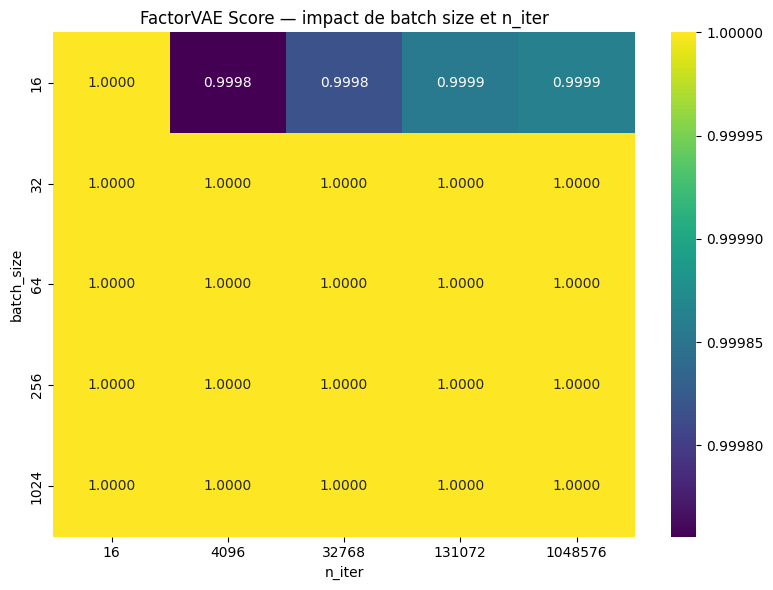

In [90]:
plt.figure(figsize=(8,6))
sns.heatmap(
    scores, 
    annot=True, fmt=".4f", 
    cmap="viridis", 
    xticklabels=hparams_iter,
    yticklabels=hparams_batch
)

plt.title("FactorVAE Score — impact de batch size et n_iter")
plt.xlabel("n_iter")
plt.ylabel("batch_size")

plt.tight_layout()
plt.show()

##### MPI3D

In [7]:
factorvaescore = FactorVAEScore(ckpt_path=test, 
                                data_name="mpi3d",
                                is_pca=False)
factorvaescore.get_argmins(verbose=True)
dim_factor_score_shapes, factor_dim_score_shapes = factorvaescore.dim_factor_score, factorvaescore.factor_dim_score
argmins,  labels = factorvaescore.argmins, factorvaescore.labels
N = len(argmins)
tp = 0
dims_t = [126, 127]
for dim, factor in zip(argmins, labels):

    if dim in dims_t :
        if factor == 1 : tp+=1
    if dim not in dims_t :
        if factor != 1 : tp+=1
print(f"FactorVAEScore: {tp/N}")

Nombre de GPU : 3

[ GPU 0 ]
Nom : Tesla V100-PCIE-32GB
Mémoire totale : 34.07 Go
Mémoire utilisée : 0.03 Go
Mémoire réservée : 0.13 Go

[ GPU 1 ]
Nom : Tesla V100-PCIE-32GB
Mémoire totale : 34.07 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : Tesla V100-PCIE-32GB
Mémoire totale : 34.07 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
Prepare data: test if .npz files exist.
Start loading train batch.
load dataset - train
From images to latent vectors.


100%|██████████| 293/293 [01:19<00:00,  3.69it/s]


load dataset val
From images to latent vectors.


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]


tensors loaded.
Train batch shape: (torch.Size([524288, 126]), torch.Size([524288, 2]), torch.Size([524288, 7]))
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 165/165 [00:40<00:00,  4.10it/s]


tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader
Test batch shape: (torch.Size([336800, 126]), torch.Size([336800, 2]), torch.Size([336800, 7]))
Train data formated.
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:13<00:00, 11800.99it/s]



Dimension 0:
  vertical_axis : 73.0%  (54/74)
  object_size  : 18.9%  (14/74)
  object_color :  4.1%  (3/74)
  background_color :  4.1%  (3/74)

Dimension 1:
  vertical_axis : 54.4%  (37/68)
  object_size  : 33.8%  (23/68)
  background_color :  7.4%  (5/68)
  object_color :  4.4%  (3/68)

Dimension 2:
  vertical_axis : 56.2%  (27/48)
  object_color : 25.0%  (12/48)
  object_size  : 12.5%  (6/48)
  background_color :  6.2%  (3/48)

Dimension 3:
  object_size  : 48.7%  (19/39)
  horizontal_axis : 30.8%  (12/39)
  background_color : 17.9%  (7/39)
  vertical_axis :  2.6%  (1/39)

Dimension 4:
  object_size  : 41.7%  (20/48)
  background_color : 25.0%  (12/48)
  object_color : 18.8%  (9/48)
  horizontal_axis : 10.4%  (5/48)
  vertical_axis :  4.2%  (2/48)

Dimension 5:
  vertical_axis : 54.5%  (18/33)
  object_size  : 21.2%  (7/33)
  object_color :  9.1%  (3/33)
  horizontal_axis :  9.1%  (3/33)
  background_color :  6.1%  (2/33)

Dimension 6:
  object_size  : 59.7%  (250/419)
  background

In [5]:
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_mpi3d_100, 
                                data_name="mpi3d",
                                is_pca=False)
factorvaescore.get_argmins(verbose=True)
dim_factor_score_shapes, factor_dim_score_shapes = factorvaescore.dim_factor_score, factorvaescore.factor_dim_score
argmins,  labels = factorvaescore.argmins, factorvaescore.labels
N = len(argmins)
tp = 0
dims_t = [126, 127]
for dim, factor in zip(argmins, labels):

    if dim in dims_t :
        if factor == 1 : tp+=1
    if dim not in dims_t :
        if factor != 1 : tp+=1
print(f"FactorVAEScore: {tp/N}")

Nombre de GPU : 3

[ GPU 0 ]
Nom : Tesla V100-PCIE-32GB
Mémoire totale : 34.07 Go
Mémoire utilisée : 0.03 Go
Mémoire réservée : 0.13 Go

[ GPU 1 ]
Nom : Tesla V100-PCIE-32GB
Mémoire totale : 34.07 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : Tesla V100-PCIE-32GB
Mémoire totale : 34.07 Go
Mémoire utilisée : 0.01 Go
Mémoire réservée : 2.34 Go
current device is 0
Prepare data: test if .npz files exist.
Start loading train batch.
load dataset - train
From images to latent vectors.


100%|██████████| 40/40 [00:06<00:00,  5.78it/s]


load dataset val
From images to latent vectors.


100%|██████████| 5/5 [00:00<00:00,  6.43it/s]

tensors loaded.


Train batch shape: (torch.Size([80000, 126]), torch.Size([80000, 2]), torch.Size([80000, 7]))
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 463/463 [02:32<00:00,  3.03it/s]


tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader
Test batch shape: (torch.Size([524288, 126]), torch.Size([524288, 2]), torch.Size([524288, 7]))
Train data formated.
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:13<00:00, 11764.95it/s]



Dimension 0:
  background_color : 95.5%  (913/956)
  object_size  :  2.4%  (23/956)
  object_shape :  1.5%  (14/956)
  vertical_axis :  0.4%  (4/956)
  horizontal_axis :  0.2%  (2/956)

Dimension 1:
  object_size  : 30.6%  (71/232)
  object_shape : 20.3%  (47/232)
  vertical_axis : 19.0%  (44/232)
  horizontal_axis : 17.2%  (40/232)
  background_color : 12.9%  (30/232)

Dimension 2:
  object_shape : 34.2%  (25/73)
  object_size  : 32.9%  (24/73)
  vertical_axis : 16.4%  (12/73)
  background_color : 16.4%  (12/73)

Dimension 3:
  object_size  : 58.8%  (30/51)
  object_shape : 23.5%  (12/51)
  vertical_axis : 15.7%  (8/51)
  background_color :  2.0%  (1/51)

Dimension 4:
  background_color : 92.7%  (981/1058)
  object_size  :  3.1%  (33/1058)
  object_shape :  2.7%  (29/1058)
  object_color :  1.3%  (14/1058)
  vertical_axis :  0.1%  (1/1058)

Dimension 5:
  object_size  : 57.1%  (24/42)
  object_shape : 26.2%  (11/42)
  object_color : 14.3%  (6/42)
  horizontal_axis :  2.4%  (1/42)

Di

In [6]:
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_mpi3d_500, 
                                data_name="mpi3d",
                                is_pca=False)
factorvaescore.get_argmins(verbose=True)
dim_factor_score_shapes, factor_dim_score_shapes = factorvaescore.dim_factor_score, factorvaescore.factor_dim_score
argmins,  labels = factorvaescore.argmins, factorvaescore.labels
N = len(argmins)
tp = 0
dims_t = [126, 127]
for dim, factor in zip(argmins, labels):

    if dim in dims_t :
        if factor == 1 : tp+=1
    if dim not in dims_t :
        if factor != 1 : tp+=1
print(f"FactorVAEScore: {tp/N}")

Nombre de GPU : 3

[ GPU 0 ]
Nom : Tesla V100-PCIE-32GB
Mémoire totale : 34.07 Go
Mémoire utilisée : 0.03 Go
Mémoire réservée : 0.13 Go

[ GPU 1 ]
Nom : Tesla V100-PCIE-32GB
Mémoire totale : 34.07 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : Tesla V100-PCIE-32GB
Mémoire totale : 34.07 Go
Mémoire utilisée : 0.01 Go
Mémoire réservée : 2.34 Go
current device is 0
Prepare data: test if .npz files exist.
Start loading train batch.
load dataset - train
From images to latent vectors.


100%|██████████| 40/40 [00:06<00:00,  5.78it/s]


load dataset val
From images to latent vectors.


100%|██████████| 5/5 [00:00<00:00,  6.17it/s]

tensors loaded.


Train batch shape: (torch.Size([80000, 126]), torch.Size([80000, 2]), torch.Size([80000, 7]))
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 463/463 [02:32<00:00,  3.04it/s]


tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader
Test batch shape: (torch.Size([524288, 126]), torch.Size([524288, 2]), torch.Size([524288, 7]))
Train data formated.
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:13<00:00, 11143.16it/s]



Dimension 0:
  object_shape : 45.5%  (50/110)
  object_size  : 41.8%  (46/110)
  horizontal_axis :  8.2%  (9/110)
  vertical_axis :  2.7%  (3/110)
  background_color :  1.8%  (2/110)

Dimension 1:
  object_size  : 38.4%  (43/112)
  background_color : 37.5%  (42/112)
  object_shape : 17.0%  (19/112)
  object_color :  3.6%  (4/112)
  vertical_axis :  3.6%  (4/112)

Dimension 2:
  object_size  : 32.8%  (20/61)
  object_shape : 26.2%  (16/61)
  object_color : 21.3%  (13/61)
  vertical_axis : 16.4%  (10/61)
  horizontal_axis :  1.6%  (1/61)
  background_color :  1.6%  (1/61)

Dimension 3:
  object_size  : 39.5%  (45/114)
  object_shape : 28.9%  (33/114)
  vertical_axis : 18.4%  (21/114)
  horizontal_axis :  6.1%  (7/114)
  background_color :  6.1%  (7/114)
  object_color :  0.9%  (1/114)

Dimension 4:
  object_size  : 38.7%  (130/336)
  background_color : 27.4%  (92/336)
  vertical_axis : 14.9%  (50/336)
  object_shape : 11.9%  (40/336)
  horizontal_axis :  7.1%  (24/336)

Dimension 5:
  b

##### Celeba

In [15]:
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_celeba_100)
factorvaescore.get_score()

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 1 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.01 Go
Mémoire réservée : 2.05 Go

[ GPU 3 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
Prepare data: test if .npz files exist.
No prepare data for celebA - Please ensure all path exists
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 10/10 [00:00<00:00, 15.53it/s]

tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader


Test batch shape: (torch.Size([19962, 126]), torch.Size([19962, 2]), torch.Size([19962, 40]))
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:10<00:00, 15037.85it/s]



Dimension 0:
  Straight_Hair :  6.4%  (48/750)
  Wearing_Necktie :  4.8%  (36/750)
  Black_Hair   :  4.8%  (36/750)
  Receding_Hairline :  4.5%  (34/750)
  Smiling      :  3.9%  (29/750)
  Oval_Face    :  3.7%  (28/750)
  High_Cheekbones :  3.3%  (25/750)
  Wearing_Earrings :  3.3%  (25/750)
  Big_Lips     :  3.3%  (25/750)
  Blurry       :  3.2%  (24/750)
  Narrow_Eyes  :  3.1%  (23/750)
  Pointy_Nose  :  2.8%  (21/750)
  Bags_Under_Eyes :  2.8%  (21/750)
  Wavy_Hair    :  2.8%  (21/750)
  No_Beard     :  2.7%  (20/750)
  Goatee       :  2.5%  (19/750)
  Bushy_Eyebrows :  2.5%  (19/750)
  Wearing_Necklace :  2.3%  (17/750)
  5_o_Clock_Shadow :  2.1%  (16/750)
  Mustache     :  2.1%  (16/750)
  Gray_Hair    :  2.1%  (16/750)
  Bangs        :  2.1%  (16/750)
  Wearing_Hat  :  2.1%  (16/750)
  Bald         :  2.1%  (16/750)
  Arched_Eyebrows :  2.1%  (16/750)
  Male         :  2.0%  (15/750)
  Mouth_Slightly_Open :  2.0%  (15/750)
  Double_Chin  :  2.0%  (15/750)
  Chubby       :  2.0% 

(0.78458984375, 0.7639218459711012, 0.51035246587235, 0.19432695496896585)

In [16]:
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_celeba_500,)
factorvaescore.get_score()

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 1 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.01 Go
Mémoire réservée : 2.05 Go

[ GPU 3 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
Prepare data: test if .npz files exist.
No prepare data for celebA - Please ensure all path exists
Start loading test batch.
load test numpy.


loaded test numpy.
From images to latent vectors.


100%|██████████| 10/10 [00:00<00:00, 15.09it/s]

tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader


Test batch shape: (torch.Size([19962, 126]), torch.Size([19962, 2]), torch.Size([19962, 40]))
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:09<00:00, 15457.17it/s]



Dimension 0:
  Wearing_Necklace :  6.3%  (56/894)
  Narrow_Eyes  :  4.1%  (37/894)
  Chubby       :  3.6%  (32/894)
  Young        :  3.6%  (32/894)
  High_Cheekbones :  3.5%  (31/894)
  Straight_Hair :  3.4%  (30/894)
  Blurry       :  3.2%  (29/894)
  Mouth_Slightly_Open :  3.1%  (28/894)
  Pointy_Nose  :  3.1%  (28/894)
  Wearing_Earrings :  2.9%  (26/894)
  Oval_Face    :  2.9%  (26/894)
  Smiling      :  2.9%  (26/894)
  Pale_Skin    :  2.9%  (26/894)
  Bags_Under_Eyes :  2.8%  (25/894)
  Sideburns    :  2.8%  (25/894)
  Black_Hair   :  2.8%  (25/894)
  Wavy_Hair    :  2.8%  (25/894)
  Wearing_Lipstick :  2.7%  (24/894)
  Bangs        :  2.6%  (23/894)
  Wearing_Necktie :  2.3%  (21/894)
  Male         :  2.3%  (21/894)
  Big_Nose     :  2.3%  (21/894)
  Bald         :  2.2%  (20/894)
  Brown_Hair   :  2.2%  (20/894)
  Blond_Hair   :  2.2%  (20/894)
  No_Beard     :  2.1%  (19/894)
  Gray_Hair    :  2.0%  (18/894)
  Attractive   :  1.9%  (17/894)
  Big_Lips     :  1.9%  (17/894)


(0.82744140625, 0.7348828032416523, 0.5283366076947585, 0.18893386825335998)

In [17]:
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_celeba, )
factorvaescore.get_score()


Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 1 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.01 Go
Mémoire réservée : 2.05 Go

[ GPU 3 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0


Prepare data: test if .npz files exist.
No prepare data for celebA - Please ensure all path exists
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 10/10 [00:00<00:00, 13.97it/s]


tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader
Test batch shape: (torch.Size([19962, 126]), torch.Size([19962, 2]), torch.Size([19962, 40]))
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:10<00:00, 15153.02it/s]



Dimension 0:
  Narrow_Eyes  :  4.0%  (22/549)
  High_Cheekbones :  3.8%  (21/549)
  Mouth_Slightly_Open :  3.6%  (20/549)
  Wearing_Necktie :  3.5%  (19/549)
  Male         :  3.5%  (19/549)
  Big_Lips     :  3.5%  (19/549)
  Bags_Under_Eyes :  3.5%  (19/549)
  Oval_Face    :  3.3%  (18/549)
  Straight_Hair :  3.3%  (18/549)
  Pointy_Nose  :  3.3%  (18/549)
  Double_Chin  :  3.3%  (18/549)
  Smiling      :  3.3%  (18/549)
  Wearing_Hat  :  3.1%  (17/549)
  Arched_Eyebrows :  3.1%  (17/549)
  5_o_Clock_Shadow :  2.9%  (16/549)
  Heavy_Makeup :  2.7%  (15/549)
  Blond_Hair   :  2.6%  (14/549)
  Black_Hair   :  2.6%  (14/549)
  Big_Nose     :  2.6%  (14/549)
  Brown_Hair   :  2.6%  (14/549)
  Receding_Hairline :  2.4%  (13/549)
  Rosy_Cheeks  :  2.4%  (13/549)
  Chubby       :  2.2%  (12/549)
  Attractive   :  2.2%  (12/549)
  Sideburns    :  2.0%  (11/549)
  Bangs        :  2.0%  (11/549)
  Gray_Hair    :  2.0%  (11/549)
  Bushy_Eyebrows :  2.0%  (11/549)
  Young        :  1.8%  (10/549

(0.795625, 0.4593397531151967, 0.4553806187328145, -0.03253570616339918)

##### Shapes

In [18]:
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_shapes_100, )
factorvaescore.get_score()

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 1 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.01 Go
Mémoire réservée : 2.05 Go

[ GPU 3 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
Prepare data: test if .npz files exist.
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 47/47 [00:03<00:00, 13.63it/s]


tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader
Test batch shape: (torch.Size([96000, 126]), torch.Size([96000, 2]), torch.Size([96000, 6]))
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:10<00:00, 14583.89it/s]


Dimension 0:
  shape        : 100.0%  (1/1)

Dimension 1:
  shape        : 50.0%  (1/2)
  orientation  : 50.0%  (1/2)

Dimension 3:
  orientation  : 66.7%  (10/15)
  scale        : 26.7%  (4/15)
  shape        :  6.7%  (1/15)

Dimension 4:
  orientation  : 100.0%  (3/3)

Dimension 5:
  shape        : 50.0%  (6/12)
  orientation  : 33.3%  (4/12)
  scale        : 16.7%  (2/12)

Dimension 6:
  scale        : 100.0%  (1/1)

Dimension 7:
  scale        : 50.0%  (1/2)
  orientation  : 50.0%  (1/2)

Dimension 8:
  shape        : 44.4%  (4/9)
  scale        : 44.4%  (4/9)
  orientation  : 11.1%  (1/9)

Dimension 9:
  orientation  : 66.7%  (4/6)
  scale        : 16.7%  (1/6)
  shape        : 16.7%  (1/6)

Dimension 10:
  orientation  : 99.8%  (522/523)
  scale        :  0.2%  (1/523)

Dimension 11:
  orientation  : 66.7%  (2/3)
  shape        : 33.3%  (1/3)

Dimension 12:
  shape        : 90.7%  (127/140)
  orientation  :  5.0%  (7/140)
  scale        :  4.3%  (6/140)

Dimension 13:
  orientat

(1.0, 1.0, 1.0, 1.0)

In [19]:
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_shapes, )
factorvaescore.get_score()

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 1 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.01 Go
Mémoire réservée : 2.05 Go

[ GPU 3 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
Prepare data: test if .npz files exist.
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 47/47 [00:03<00:00, 13.73it/s]

tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader


Test batch shape: (torch.Size([96000, 126]), torch.Size([96000, 2]), torch.Size([96000, 6]))
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:10<00:00, 14593.19it/s]



Dimension 0:
  scale        : 53.2%  (25/47)
  orientation  : 27.7%  (13/47)
  shape        : 19.1%  (9/47)

Dimension 1:
  scale        : 93.4%  (57/61)
  shape        :  4.9%  (3/61)
  orientation  :  1.6%  (1/61)

Dimension 2:
  shape        : 96.2%  (895/930)
  orientation  :  2.2%  (20/930)
  scale        :  1.6%  (15/930)

Dimension 3:
  shape        : 40.3%  (31/77)
  scale        : 36.4%  (28/77)
  orientation  : 23.4%  (18/77)

Dimension 4:
  shape        : 91.2%  (332/364)
  scale        :  6.0%  (22/364)
  orientation  :  2.7%  (10/364)

Dimension 5:
  scale        : 87.6%  (2128/2429)
  shape        : 11.8%  (286/2429)
  orientation  :  0.6%  (15/2429)

Dimension 6:
  shape        : 66.0%  (62/94)
  orientation  : 23.4%  (22/94)
  scale        : 10.6%  (10/94)

Dimension 7:
  scale        : 72.7%  (178/245)
  orientation  : 25.7%  (63/245)
  shape        :  1.6%  (4/245)

Dimension 8:
  scale        : 54.8%  (17/31)
  orientation  : 38.7%  (12/31)
  shape        :  6.5%  (

(0.9999934895833333,
 0.9999960944822845,
 0.9999882726357404,
 0.9999765455465383)

##### DSprites

In [20]:
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_dsprites_100, )
factorvaescore.get_score()

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 1 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.01 Go
Mémoire réservée : 2.05 Go

[ GPU 3 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0


Prepare data: test if .npz files exist.
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 72/72 [00:03<00:00, 18.64it/s]

tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader


Test batch shape: (torch.Size([147456, 126]), torch.Size([147456, 2]), torch.Size([147456, 5]))
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:10<00:00, 14105.82it/s]



Dimension 0:
  orientation  : 70.9%  (127/179)
  scale        : 29.1%  (52/179)

Dimension 1:
  orientation  : 74.6%  (103/138)
  scale        : 24.6%  (34/138)
  pos_y        :  0.7%  (1/138)

Dimension 2:
  orientation  : 53.8%  (105/195)
  scale        : 46.2%  (90/195)

Dimension 3:
  pos_x        : 39.7%  (89/224)
  orientation  : 30.8%  (69/224)
  scale        : 28.6%  (64/224)
  pos_y        :  0.9%  (2/224)

Dimension 4:
  orientation  : 63.6%  (306/481)
  scale        : 36.0%  (173/481)
  pos_y        :  0.4%  (2/481)

Dimension 5:
  orientation  : 55.9%  (137/245)
  scale        : 44.1%  (108/245)

Dimension 6:
  scale        : 54.5%  (126/231)
  orientation  : 45.5%  (105/231)

Dimension 7:
  orientation  : 60.8%  (45/74)
  scale        : 39.2%  (29/74)

Dimension 8:
  orientation  : 74.8%  (397/531)
  scale        : 23.4%  (124/531)
  pos_y        :  1.9%  (10/531)

Dimension 9:
  orientation  : 52.2%  (235/450)
  scale        : 47.8%  (215/450)

Dimension 10:
  scale     

(0.9940950520833334,
 0.9962869579638423,
 0.9908587503573149,
 0.9818811274950981)

In [21]:
factorvaescore = FactorVAEScore(ckpt_path=ckpt_path_dsprites)
factorvaescore.get_score()

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 1 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.01 Go
Mémoire réservée : 2.05 Go

[ GPU 3 ]
Nom : NVIDIA A100 80GB PCIe
Mémoire totale : 84.97 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0


Prepare data: test if .npz files exist.
Start loading test batch.
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 72/72 [00:03<00:00, 18.56it/s]

tensors loaded.
Start loading test batch. - end setup
Start loading test batch. -end dataloader


Test batch shape: (torch.Size([147456, 126]), torch.Size([147456, 2]), torch.Size([147456, 5]))
Test data formated.
Starting computing FactorVAE metric.


100%|██████████| 153600/153600 [00:10<00:00, 14001.52it/s]



Dimension 0:
  pos_y        : 37.8%  (233/616)
  pos_x        : 28.7%  (177/616)
  scale        : 19.2%  (118/616)
  orientation  : 14.3%  (88/616)

Dimension 1:
  orientation  : 51.5%  (211/410)
  scale        : 44.9%  (184/410)
  pos_x        :  3.4%  (14/410)
  pos_y        :  0.2%  (1/410)

Dimension 2:
  scale        : 49.7%  (442/889)
  orientation  : 47.9%  (426/889)
  pos_y        :  1.9%  (17/889)
  pos_x        :  0.4%  (4/889)

Dimension 3:
  orientation  : 71.6%  (121/169)
  scale        : 24.3%  (41/169)
  pos_y        :  4.1%  (7/169)

Dimension 4:
  pos_x        : 47.0%  (11793/25077)
  pos_y        : 38.1%  (9555/25077)
  orientation  :  7.9%  (1978/25077)
  scale        :  7.0%  (1751/25077)

Dimension 5:
  scale        : 60.6%  (137/226)
  orientation  : 38.9%  (88/226)
  pos_y        :  0.4%  (1/226)

Dimension 6:
  scale        : 51.0%  (73/143)
  orientation  : 49.0%  (70/143)

Dimension 7:
  scale        : 51.4%  (268/521)
  orientation  : 47.4%  (247/521)
  pos_

(0.99279296875, 0.9954980967563523, 0.9888702400575331, 0.9779845455457274)

#### Dev factorVAE

In [8]:
latent = LatentDataModule(standard=True, 
                          batch_size=2**19,
                          data_name="shapes",
                          ckpt_path=ckpt_path_shapes_100)
latent.prepare_data()
latent.setup("fit")
latent_loader = latent.train_dataloader()
batch = next(iter(latent_loader))
z_s_0, z_t_0, label_0 = batch
z_s_0.shape, z_t_0.shape, label_0.shape

latent.setup("test")
latent_test_loader = latent.test_dataloader()
batch = next(iter(latent_test_loader))
z_s_1, z_t_1, label_1 = batch
z_s_1.shape, z_t_1.shape, label_1.shape

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.12 Go
Mémoire réservée : 0.26 Go

[ GPU 1 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 3 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
load dataset - train
load dataset val
tensors loaded.
tensors loaded.


(torch.Size([96000, 126]), torch.Size([96000, 2]), torch.Size([96000, 6]))

##### Run PCA

In [10]:
is_pca=False
if is_pca:
    #train
    pca_t_tr = PCA(n_components=1) 
    pca_s_tr = PCA(n_components=1)
    z_t_tr = pca_t_tr.fit_transform(z_t_0)
    z_s_tr = pca_s_tr.fit_transform(z_s_0)
    print(z_s_tr.shape, z_t_tr.shape)
    if not isinstance(z_t_tr, torch.Tensor) : z_t_tr = torch.tensor(z_t_tr)
    if not isinstance(z_s_tr, torch.Tensor) : z_s_tr = torch.tensor(z_s_tr)

    #test
    pca_t_te = PCA(n_components=1) 
    pca_s_te = PCA(n_components=1)
    z_t_te = pca_t_tr.fit_transform(z_t_1)
    z_s_te = pca_s_tr.fit_transform(z_s_1)
    print(z_s_te.shape, z_t_te.shape)
    if not isinstance(z_t_te, torch.Tensor) : z_t_te = torch.tensor(z_t_te)
    if not isinstance(z_s_te, torch.Tensor) : z_s_te = torch.tensor(z_s_te)
else:
    z_s_tr = z_s_0
    z_t_tr = z_t_0
    z_s_te = z_s_1
    z_t_te = z_t_1


##### Run train

In [11]:
Z_tr = torch.cat([z_s_tr, z_t_tr], dim=1).cpu().numpy()        
Z_tr = (Z_tr - Z_tr.mean(axis=0, keepdims=True)) / (Z_tr.std(axis=0, keepdims=True) + 1e-8)
Y_tr = label_0.cpu().numpy().astype(np.int64)              

# Format d_lib
mus_train = Z_tr.T                                   
ys_train  = Y_tr.T                                    

Z_te = torch.cat([z_s_te, z_t_te], dim=1).cpu().numpy()        
Z_te = (Z_te - Z_te.mean(axis=0, keepdims=True)) / (Z_te.std(axis=0, keepdims=True) + 1e-8)
Y_te = label_1.cpu().numpy().astype(np.int64)              

# Format d_lib
mus_test = Z_te.T                                   
ys_test  = Y_te.T     

np.savez("disdiff_adapters/notebook/precomputed_st_3dshapes.npz",
         mus_train=mus_train,
         ys_train=ys_train,
         mus_test=mus_test,
         ys_test=ys_test)

In [12]:
FACTOR_NAMES = latent.Data_class.Params.FACTORS_IN_ORDER

# Rejoue seulement la phase "test" pour analyser finement
data = np.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/notebook/precomputed_st_3dshapes.npz")
mus_train = data.get("mus_train", data["mus_train"])
ys_train  = data.get("ys_train",  data["ys_train"])

mus_test = data.get("mus_test", data["mus_test"])
ys_test  = data.get("ys_test",  data["ys_test"])

In [13]:
#Set a random generator
rng = np.random.default_rng(0)

def value_index(ys):
    out=[]
    for k in range(ys.shape[0]):
        d={}
        for v in np.unique(ys[k]):
            d[int(v)]=np.flatnonzero(ys[k]==v)
        out.append(d)
    return out

def collect(mus, ys, n_iter=20000, batch_size=64):
    z_std = mus.std(axis=1, keepdims=True); z_std[z_std==0]=1.0
    v2i = value_index(ys)
    argmins, labels = [], []
    for _ in range(n_iter):
        k = rng.integers(0, ys.shape[0]) #Choose a factor f_k
        v = rng.choice(list(v2i[k].keys())) #Choose a value for f_k
        pool = v2i[k][v]
        idx = rng.choice(pool, size=batch_size, replace=(len(pool)<batch_size)) #Batch with f_k=v

        Z = mus[:, idx]/z_std
        d = int(Z.var(axis=1).argmin()) #get the argmin variance for this batch
        argmins.append(d); labels.append(k)
    return np.array(argmins), np.array(labels)

In [14]:
argmins, labels = collect(mus_train, ys_train, n_iter=153600, batch_size=64)

In [15]:
dim_factor_score = {}
# Taux d'association dim->facteur
for d in tqdm(np.unique(argmins)):
    dim_factor_score[str(d)] = defaultdict(float)
    cnt = Counter(labels[argmins==d]) #labels[argmins==d], How many times f_k is assigned to dimension d?
    total = sum(cnt.values()) #Number of labels assigned to dimension d
    print(f"\nDimension {d}:")
    for k,n in cnt.most_common():
        dim_factor_score[str(d)][FACTOR_NAMES[k]] = n/total
        print(f"  {FACTOR_NAMES[k]:12s} : {n/total:5.1%}  ({n}/{total})")
    break
# """Dimension 0:
#   scale        : 73.8%  (135/183)
#   shape        : 26.2%  (48/183)
# """ means 73.8% of labels assigned to dimension 0 are scale.


  0%|          | 0/115 [00:00<?, ?it/s]


Dimension 1:
  shape        : 66.7%  (2/3)
  orientation  : 33.3%  (1/3)


In [16]:
factor_dim_score = {}
for k in tqdm(np.unique(labels)):
    mask = (labels == k)
    cnt = Counter(argmins[mask])                # Combien de fois la dim d "gagne" pour le facteur k ?
    total = sum(cnt.values())
    name  = FACTOR_NAMES[k] if 'FACTOR_NAMES' in globals() else f"f{k}"
    factor_dim_score[name] = defaultdict(float)
    print(f"\nFacteur {name}:")
    for d, n in cnt.most_common():             # tri décroissant
        print(f"  dim {d:>3} : {n/total:5.1%}  ({n}/{total})")
        factor_dim_score[name][str(d)]=n/total

100%|██████████| 6/6 [00:00<00:00, 454.15it/s]


Facteur floor_hue:
  dim 126 : 61.6%  (15713/25517)
  dim 127 : 38.4%  (9804/25517)

Facteur wall_hue:
  dim 111 : 67.0%  (17256/25763)
  dim 105 : 33.0%  (8507/25763)

Facteur object_hue:
  dim  58 : 99.9%  (25607/25637)
  dim  15 :  0.1%  (30/25637)

Facteur scale:
  dim  54 : 62.2%  (15919/25595)
  dim  70 : 14.9%  (3825/25595)
  dim  53 : 12.7%  (3256/25595)
  dim 121 :  4.6%  (1181/25595)
  dim  26 :  1.3%  (328/25595)
  dim  82 :  1.0%  (254/25595)
  dim  62 :  0.6%  (141/25595)
  dim  83 :  0.5%  (125/25595)
  dim  79 :  0.4%  (110/25595)
  dim  34 :  0.3%  (72/25595)
  dim  77 :  0.3%  (66/25595)
  dim  89 :  0.3%  (64/25595)
  dim  76 :  0.1%  (35/25595)
  dim 108 :  0.1%  (30/25595)
  dim  20 :  0.1%  (17/25595)
  dim  61 :  0.1%  (15/25595)
  dim 124 :  0.1%  (13/25595)
  dim  59 :  0.0%  (10/25595)
  dim  49 :  0.0%  (10/25595)
  dim  18 :  0.0%  (10/25595)
  dim  55 :  0.0%  (9/25595)
  dim 117 :  0.0%  (8/25595)
  dim  16 :  0.0%  (8/25595)
  dim 101 :  0.0%  (7/25595)
 

In [ ]:
N = len(argmins)
tp = 0
dims_t = [126, 127]
for dim, factor in zip(argmins, labels):

    if dim in dims_t :
        if factor == 0 : tp+=1
    if dim not in dims_t :
        if factor != 0 : tp+=1
print(f"FactorVAEScore: {tp/N}")

##### Run test

In [32]:
def learn_majority_vote(argmins_train, labels_train, n_dims=None, seed=0):

    rng = np.random.default_rng(seed)
    counts = defaultdict(Counter)
    for d, k in zip(argmins_train, labels_train):
        counts[int(d)][int(k)] += 1

    if n_dims is None:
        dims = sorted(counts.keys())
    else:
        dims = list(range(n_dims))

    mapping = {}
    for d in dims:
        c = counts.get(d, Counter())
        if not c:
            mapping[d] = 0
            continue

        best = c.most_common()
        top_votes = best[0][1]
        top_factors = [k for (k, v) in best if v == top_votes]
        mapping[d] = top_factors[0]

    return mapping, counts

def predict_majority(mapping_dim_to_factor, argmins):
    """
    argmins : (M,) entiers -> dimension gagnante
    return  : (M,) entiers -> facteur prédit via mapping
    """
    return np.array([mapping_dim_to_factor.get(int(d), 0) for d in argmins], dtype=int)

def accuracy_majority(mapping_dim_to_factor, argmins_test, labels_test):
    y_pred = predict_majority(mapping_dim_to_factor, argmins_test)
    return float((y_pred == labels_test).mean())

def confusion_dim_factor(argmins, labels):
    """
    Retourne un dict {dim: {factor: nb_votes}}
    utile pour inspecter la sélectivité de chaque dimension.
    """
    tab = defaultdict(Counter)
    for d, k in zip(argmins, labels):
        tab[int(d)][int(k)] += 1
    # conversion en dict pur
    return {d: dict(cnt) for d, cnt in tab.items()}

def split_train_test(argmins, labels, test_ratio=0.2, seed=0):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(argmins))
    rng.shuffle(idx)
    n_test = int(len(idx) * test_ratio)
    te, tr = idx[:n_test], idx[n_test:]
    return (argmins[tr], labels[tr]), (argmins[te], labels[te])


argmins_train, labels_train = argmins, labels
argmins_test,  labels_test  = collect(mus_test, ys_test, n_iter=20000, batch_size=64)

# Apprentissage du mapping
D = int(np.max(argmins)) + 1   # nb de dims si inconnu
mapping, counts = learn_majority_vote(argmins_train, labels_train, n_dims=D)

# Accuracy
acc = accuracy_majority(mapping, argmins_test, labels_test)
print("Accuracy (vote majoritaire):", acc)
print("Mapping dim->factor:", mapping)

# Confusion compacte
conf = confusion_dim_factor(argmins, labels)
print("Confusion (dim->factor):", conf)


Accuracy (vote majoritaire): 0.5831
Mapping dim->factor: {0: 2, 1: 2, 2: 1, 3: 2, 4: 2, 5: 2, 6: 1, 7: 2, 8: 2, 9: 1, 10: 2, 11: 2, 12: 1, 13: 1, 14: 2, 15: 2, 16: 2, 17: 2, 18: 1, 19: 2, 20: 1, 21: 1, 22: 1, 23: 2, 24: 1, 25: 2, 26: 1, 27: 1, 28: 2, 29: 2, 30: 1, 31: 2, 32: 2, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 1, 40: 1, 41: 2, 42: 2, 43: 2, 44: 1, 45: 1, 46: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 52: 1, 53: 2, 54: 2, 55: 1, 56: 2, 57: 2, 58: 1, 59: 2, 60: 1, 61: 2, 62: 2, 63: 2, 64: 2, 65: 2, 66: 2, 67: 2, 68: 1, 69: 1, 70: 2, 71: 1, 72: 1, 73: 2, 74: 1, 75: 2, 76: 2, 77: 2, 78: 1, 79: 2, 80: 2, 81: 1, 82: 1, 83: 1, 84: 2, 85: 1, 86: 2, 87: 2, 88: 1, 89: 1, 90: 2, 91: 2, 92: 2, 93: 2, 94: 1, 95: 2, 96: 1, 97: 2, 98: 2, 99: 1, 100: 1, 101: 3, 102: 1, 103: 2, 104: 2, 105: 3, 106: 1, 107: 4, 108: 2, 109: 2, 110: 1, 111: 2, 112: 3, 113: 2, 114: 1, 115: 1, 116: 1, 117: 1, 118: 2, 119: 1, 120: 1, 121: 2, 122: 2, 123: 2, 124: 2, 125: 2, 126: 0, 127: 0}
Confusion (dim->factor): {10

In [81]:
dim_factor_score_test = {}
# Taux d'association dim->facteur
for d in tqdm(np.unique(argmins_test)):
    dim_factor_score_test[str(d)] = defaultdict(float)
    cnt = Counter(labels_test[argmins_test==d]) #labels[argmins==d], How many times f_k is assigned to dimension d?
    total = sum(cnt.values()) #Number of labels assigned to dimension d
    print(f"\nDimension {d}:")
    for k,n in cnt.most_common():
        dim_factor_score_test[str(d)][FACTOR_NAMES[k]] = n/total
        print(f"  {FACTOR_NAMES[k]:12s} : {n/total:5.1%}  ({n}/{total})")

# """Dimension 0:
#   scale        : 73.8%  (135/183)
#   shape        : 26.2%  (48/183)
# """ means 73.8% of labels assigned to dimension 0 are scale.


100%|██████████| 73/73 [00:00<00:00, 14301.66it/s]


Dimension 0:
  orientation  : 100.0%  (1/1)

Dimension 3:
  orientation  : 100.0%  (4/4)

Dimension 5:
  shape        : 100.0%  (2/2)

Dimension 8:
  scale        : 100.0%  (1/1)

Dimension 10:
  orientation  : 100.0%  (66/66)

Dimension 12:
  shape        : 95.0%  (19/20)
  scale        :  5.0%  (1/20)

Dimension 13:
  scale        : 33.3%  (1/3)
  orientation  : 33.3%  (1/3)
  shape        : 33.3%  (1/3)

Dimension 14:
  orientation  : 100.0%  (1/1)

Dimension 15:
  object_hue   : 100.0%  (3/3)

Dimension 16:
  shape        : 83.3%  (5/6)
  orientation  : 16.7%  (1/6)

Dimension 18:
  scale        : 100.0%  (3/3)

Dimension 20:
  scale        : 60.0%  (3/5)
  orientation  : 40.0%  (2/5)

Dimension 21:
  orientation  : 100.0%  (2/2)

Dimension 22:
  orientation  : 100.0%  (1/1)

Dimension 24:
  orientation  : 100.0%  (5/5)

Dimension 25:
  orientation  : 100.0%  (6/6)

Dimension 26:
  scale        : 100.0%  (37/37)

Dimension 29:
  scale        : 100.0%  (1/1)

Dimension 31:
  orient

In [83]:
factor_dim_score_test = {}
for k in tqdm(np.unique(labels_test)):
    mask = (labels_test == k)
    cnt = Counter(argmins_test[mask])                # Combien de fois la dim d "gagne" pour le facteur k ?
    total = sum(cnt.values())
    name  = FACTOR_NAMES[k] if 'FACTOR_NAMES' in globals() else f"f{k}"
    factor_dim_score_test[name] = defaultdict(float)
    print(f"\nFacteur {name}:")
    for d, n in cnt.most_common():             # tri décroissant
        print(f"  dim {d:>3} : {n/total:5.1%}  ({n}/{total})")
        factor_dim_score_test[name][str(d)]=n/total

100%|██████████| 6/6 [00:00<00:00, 1762.68it/s]


Facteur floor_hue:
  dim 126 : 60.3%  (1995/3308)
  dim 127 : 39.7%  (1313/3308)

Facteur wall_hue:
  dim 111 : 66.9%  (2228/3330)
  dim 105 : 33.1%  (1102/3330)

Facteur object_hue:
  dim  58 : 99.9%  (3300/3303)
  dim  15 :  0.1%  (3/3303)

Facteur scale:
  dim  54 : 62.2%  (2096/3372)
  dim  70 : 14.5%  (490/3372)
  dim  53 : 13.7%  (461/3372)
  dim 121 :  4.3%  (144/3372)
  dim  26 :  1.1%  (37/3372)
  dim  82 :  0.9%  (32/3372)
  dim  62 :  0.7%  (25/3372)
  dim  34 :  0.4%  (14/3372)
  dim  79 :  0.4%  (12/3372)
  dim  89 :  0.3%  (11/3372)
  dim  77 :  0.3%  (10/3372)
  dim  83 :  0.2%  (8/3372)
  dim  76 :  0.1%  (3/3372)
  dim  20 :  0.1%  (3/3372)
  dim  18 :  0.1%  (3/3372)
  dim  55 :  0.1%  (3/3372)
  dim 108 :  0.1%  (3/3372)
  dim  61 :  0.1%  (3/3372)
  dim  86 :  0.1%  (2/3372)
  dim  98 :  0.1%  (2/3372)
  dim  49 :  0.0%  (1/3372)
  dim  13 :  0.0%  (1/3372)
  dim  66 :  0.0%  (1/3372)
  dim   8 :  0.0%  (1/3372)
  dim  12 :  0.0%  (1/3372)
  dim  29 :  0.0%  (1/337

### FactorVAE X

In [15]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from os.path import join
from os import mkdir
from collections import Counter, defaultdict
from tqdm import tqdm
import yaml
import re

from disdiff_adapters.data_module import LatentDataModule

class FactorVAEScore :

    def __init__(self, ckpt_path: str, 
                 is_pca: bool=False, 
                 n_iter: int=153600, 
                 batch_size: int=64, 
                 pref_gpu: int=0, 
                 verbose: bool=False,
                 only_factors: list[int]=[]) :
        
        self.ckpt_path = ckpt_path
        self.data_name =  self.get_data_name()
        self.is_pca = is_pca
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.pref_gpu = pref_gpu
        self.only_factors = only_factors

        z_s_te, z_t_te, label_te = self.load_latent(stage="test", verbose=verbose)
        z_s_val, z_t_val, label_val = self.load_latent(stage="val", verbose=verbose)                                 

        Z_te = torch.cat([z_s_te, z_t_te], dim=1).cpu().numpy()        
        Z_te = (Z_te - Z_te.mean(axis=0, keepdims=True)) / (Z_te.std(axis=0, keepdims=True) + 1e-8)
        Y_te = label_te.cpu().numpy().astype(np.int64)   

        Z_val = torch.cat([z_s_val, z_t_val], dim=1).cpu().numpy()        
        Z_val = (Z_val - Z_val.mean(axis=0, keepdims=True)) / (Z_val.std(axis=0, keepdims=True) + 1e-8)
        Y_val = label_val.cpu().numpy().astype(np.int64) 

        if only_factors:   
            print(Y_val.shape, Y_te.shape)
            Y_val = Y_val[:, only_factors]
            Y_te = Y_te[:, only_factors]       
            print(Y_val.shape, Y_te.shape)

        self.mus_test = Z_te.T                                   
        self.ys_test  = Y_te.T   
        if verbose: print("Test data formated.") 

        self.mus_val = Z_val.T                                   
        self.ys_val  = Y_val.T   
        if verbose: print("Val data formated.") 

        self.rng = np.random.default_rng(0)
    
    def set_batch_size(self, batch_size: int) :
        self.batch_size = batch_size

    def set_n_iter(self, n_iter: int):
        self.n_iter = n_iter
        
    def load_latent(self, stage: str="test", verbose: bool=False):
        latent = LatentDataModule(standard=True, 
                                batch_size=2**19,
                                pref_gpu=self.pref_gpu,
                                Model_class=Xfactors,
                                data_name=self.data_name,
                                ckpt_path=self.ckpt_path,
                                verbose=verbose)
        
        if verbose : print("Prepare data: test if .npz files exist.")
        latent.prepare_data()

        if verbose: print(f"Start loading {stage} batch.")
        latent.setup(stage)
        if verbose: print(f"Start loading {stage} batch. - end setup")
        latent_loader = latent.test_dataloader() if stage == "test" else latent.val_dataloader()
        if verbose: print(f"Start loading {stage} batch. -end dataloader")
        batch = next(iter(latent_loader))
        z_s_te, z_t_te, label_te = batch
        if verbose: print(f"Test batch shape: {z_s_te.shape, z_t_te.shape, label_te.shape}")

        self.FACTOR_NAMES = latent.Data_class.Params.FACTORS_IN_ORDER

        if self.is_pca:
            print("Start PCA.")
            #test
            pca_t_te = PCA(n_components=1) 
            pca_s_te = PCA(n_components=1)
            z_t_te = pca_t_te.fit_transform(z_t_te)
            z_s_te = pca_s_te.fit_transform(z_s_te)
            print(z_s_te.shape, z_t_te.shape)
            if not isinstance(z_t_te, torch.Tensor) : z_t_te = torch.tensor(z_t_te)
            if not isinstance(z_s_te, torch.Tensor) : z_s_te = torch.tensor(z_s_te)
            print("End PCA.")
        
        return z_s_te, z_t_te, label_te

    def value_index(self, ys):
        out=[]
        for k in range(ys.shape[0]):
            d={}
            for v in np.unique(ys[k]):
                d[int(v)]=np.flatnonzero(ys[k]==v)
            out.append(d)
        return out

    def collect(self, mus, ys, n_iter, batch_size=64, verbose=False):
        z_std = mus.std(axis=1, keepdims=True); z_std[z_std==0]=1.0
        v2i = self.value_index(ys)
        argmins, labels = [], []
        if verbose: print("Starting computing FactorVAE metric.")
        for _ in tqdm(range(n_iter)):
            k = self.rng.integers(0, ys.shape[0]) #Choose a factor f_k
            v = self.rng.choice(list(v2i[k].keys())) #Choose a value for f_k
            pool = v2i[k][v]
            idx = self.rng.choice(pool, size=batch_size, replace=(len(pool)<batch_size)) #Batch with f_k=v

            Z = mus[:, idx]/z_std
            d = int(Z.var(axis=1).argmin()) #get the argmin variance for this batch
            argmins.append(d); labels.append(k)
        return np.array(argmins), np.array(labels)
    
    def save(self):
        paths = self.ckpt_path.split("/")
        folder_path=""
        for k in range(len(paths)-2) :
            folder_path+= paths[k]+"/"
        folder_path+="metric"
        print(f"Saving at {folder_path}.")

        try: mkdir(folder_path)
        except FileExistsError: pass

        scores = {"dim_factor_score": self.dim_factor_score, "factor_dim_score": self.factor_dim_score}
        torch.save(scores, join(folder_path, "metric.pt"))
        
    def get_dicts(self, mu_s, ys, verbose: bool=True) :
        argmins, labels = self.collect(mu_s, ys, self.n_iter, self.batch_size, verbose=verbose)
        self.argmins = argmins
        self.labels = labels
        dim_factor_score = defaultdict(list)
        # Taux d'association dim->facteur
        for d in np.unique(argmins):
            dim_factor_score[str(d)] = defaultdict(float)
            cnt = Counter(labels[argmins==d]) #labels[argmins==d], How many times f_k is assigned to dimension d?
            total = sum(cnt.values()) #Number of labels assigned to dimension d
            if verbose: print(f"\nDimension {d}:")
            for k,n in cnt.most_common():
                dim_factor_score[str(d)][self.FACTOR_NAMES[k]] = n/total
                if verbose: print(f"  {self.FACTOR_NAMES[k]:12s} : {n/total:5.1%}  ({n}/{total})")

        # """Dimension 0:
        #   scale        : 73.8%  (135/183)
        #   shape        : 26.2%  (48/183)
        # """ means 73.8% of labels assigned to dimension 0 are scale.

        factor_dim_score = defaultdict(list)
        for k in np.unique(labels):
            mask = (labels == k)
            cnt = Counter(argmins[mask])                # Combien de fois la dim d "gagne" pour le facteur k ?
            total = sum(cnt.values())
            name  = self.FACTOR_NAMES[k]
            factor_dim_score[name] = defaultdict(float)
            if verbose: print(f"\nFacteur {name}:")
            for d, n in cnt.most_common():             # tri décroissant
                if verbose: print(f"  dim {d:>3} : {n/total:5.1%}  ({n}/{total})")
                factor_dim_score[name][str(d)]=n/total

        self.factor_dim_score = factor_dim_score
        self.dim_factor_score = dim_factor_score

        self.save()
        return factor_dim_score, dim_factor_score
        
    def get_data_name(self):
        root_path = self.ckpt_path.split("/")[:-2]
        data_name = str(root_path[-6])
        return data_name
    
    def compute_map(self):
        dim_factor_score = self.dim_factor_score
        #map_dim_factor = defaultdict(float)
        map_dim_factor = {}

        for dim in range(int(list(self.dim_factor_score.keys())[-1])+1) :
            factors = dim_factor_score[str(dim)]
            if type(factors) == list : first_factor = "s"
            elif self.only_factors and (list(factors.keys())[0] not in np.asarray(self.FACTOR_NAMES)[self.only_factors]) : first_factor = "s"
            else : first_factor = list(factors.keys())[0]
            map_dim_factor[str(dim)] = first_factor
        self.map_dim_factor = map_dim_factor
        return map_dim_factor
    
    def compute_score(self, verbose=False):
        self.get_dicts(self.mus_val, self.ys_val, verbose=verbose)
        map = self.compute_map()
        if verbose: print(map)

        argmins, labels = self.collect(self.mus_test, self.ys_test, self.n_iter, self.batch_size)
        predictions = []
        for argmin in argmins:
            pred_str = self.map_dim_factor[str(argmin)]
            if pred_str == "s" : pred_int = -1
            else :
                try : pred_int = self.FACTOR_NAMES.index(pred_str)
                except ValueError : print(f"Factor {pred_str} does not exist.")
            predictions.append(pred_int)
        
        predictions = np.asarray(predictions)
        if verbose : 
            for prediction, label in zip(predictions, labels):
                print(prediction, label)

        return np.sum(predictions == labels)/self.n_iter

        



class FactorVAEScoreLight :

    def __init__(self,  
                 buff: dict, 
                 mode: str, 
                 dim_t: int, 
                 dim_s: int, 
                 select_factor: int,
                 n_iter: int=153600,
                 batch_size: int=64) :
        
        self.get_buff(mode)
        self.dim_t = dim_t
        self.dim_s = dim_s
        self.select_factor = select_factor
        self.rng = np.random.default_rng(0)
        self.n_iter = n_iter
        self.batch_size = batch_size
        
    def get_buff(self, mode):
        z_s, z_t, label = self.buff[mode]

        Z = torch.cat([z_s, z_t], dim=1).cpu().numpy()        
        Z = (Z - Z.mean(axis=0, keepdims=True)) / (Z.std(axis=0, keepdims=True) + 1e-8)
        Y = label.cpu().numpy().astype(np.int64)              

        self.mus_train = Z.T                                   
        self.ys_train  = Y.T
        print(f"{mode} data formated.")

    def value_index(self, ys):
        out=[]
        for k in range(ys.shape[0]):
            d={}
            for v in np.unique(ys[k]):
                d[int(v)]=np.flatnonzero(ys[k]==v)
            out.append(d)
        return out

    def collect(self, mus, ys, n_iter=20000, batch_size=64):
        z_std = mus.std(axis=1, keepdims=True); z_std[z_std==0]=1.0
        v2i = self.value_index(ys)
        argmins, labels = [], []
        print("Starting computing FactorVAE metric.")
        for _ in tqdm(range(n_iter)):
            k = self.rng.integers(0, ys.shape[0]) #Choose a factor f_k
            v = self.rng.choice(list(v2i[k].keys())) #Choose a value for f_k
            pool = v2i[k][v]
            idx = self.rng.choice(pool, size=batch_size, replace=(len(pool)<batch_size)) #Batch with f_k=v

            Z = mus[:, idx]/z_std
            d = int(Z.var(axis=1).argmin()) #get the argmin variance for this batch
            argmins.append(d); labels.append(k)
        return np.array(argmins), np.array(labels)
    
    def get_argmins(self, verbose: bool=True) :
        argmins, labels = self.collect(self.mus_test, self.ys_test, n_iter=153600, batch_size=64)
        self.argmins = argmins
        self.labels = labels

    def get_score(self):
        self.get_argmins()
        N = len(self.argmins)
        tp = 0
        dims_t = [self.dim_s+k for k in range(self.dim_t)]

        for dim, factor in zip(self.argmins, self.labels):

            if dim in dims_t :
                if factor == self.select_factor : tp+=1
            if dim not in dims_t :
                if factor != self.select_factor : tp+=1
        score = tp/N
        print(f"FactorVAEScore: {score}")
        return score

##### Compute FactorVAEScore sur un dummy classifier

In [18]:
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["shapes"]["b1"]["-1"], verbose=False, only_factors=[1,2,3])
argmins, labels = xscore.collect(xscore.mus_test, xscore.ys_test, xscore.n_iter, xscore.batch_size, verbose=False)
predictions = []
for argmin in argmins:
    pred_int = np.random.randint(0,3)
    predictions.append(pred_int)

predictions = np.asarray(predictions)
np.sum(predictions == labels)/xscore.n_iter

current device is 0


100%|██████████| 47/47 [00:09<00:00,  5.20it/s]


current device is 0


100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


(76800, 6) (96000, 6)
(76800, 3) (96000, 3)


100%|██████████| 153600/153600 [00:10<00:00, 14025.64it/s]


np.float64(0.3330208333333333)

##### CelebA

In [19]:
path_celeba_b1_disen = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/celeba/loss_vae_nce/factor=disen/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=disen/checkpoints/last.ckpt"
path_celeba_b1_repr = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/celeba/loss_vae_nce/factor=repr/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=repr/checkpoints/last.ckpt"
path_celeba_b1_min = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/celeba/loss_vae_nce/factor0,15,26/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/checkpoints/last.ckpt"

In [30]:
celeba_scores = []
xscore = FactorVAEScore(ckpt_path=path_celeba_b1_repr, only_factors=[0,4,15,18,20,24,36,31,34,35])
for _ in range(1) : celeba_scores.append(xscore.compute_score())
np.mean(celeba_scores), np.std(celeba_scores)

current device is 0
No prepare data for celebA - Please ensure all path exists


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


current device is 0
No prepare data for celebA - Please ensure all path exists


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


(19962, 40) (19962, 40)
(19962, 10) (19962, 10)


100%|██████████| 153600/153600 [00:09<00:00, 15663.44it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/celeba/loss_vae_nce/factor=repr/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=repr/metric.


100%|██████████| 153600/153600 [00:09<00:00, 16284.67it/s]


(np.float64(0.013294270833333333), np.float64(0.0))

In [26]:
xscore.compute_score(verbose=True)

Starting computing FactorVAE metric.


  0%|          | 0/153600 [00:00<?, ?it/s]

100%|██████████| 153600/153600 [00:09<00:00, 15896.31it/s]



Dimension 0:
  5_o_Clock_Shadow : 40.7%  (24/59)
  Arched_Eyebrows : 27.1%  (16/59)
  Blond_Hair   : 22.0%  (13/59)
  Black_Hair   :  5.1%  (3/59)
  Bangs        :  3.4%  (2/59)
  Big_Nose     :  1.7%  (1/59)

Dimension 1:
  5_o_Clock_Shadow : 38.2%  (21/55)
  Arched_Eyebrows : 36.4%  (20/55)
  Blond_Hair   : 10.9%  (6/55)
  Bangs        :  5.5%  (3/55)
  Black_Hair   :  5.5%  (3/55)
  Big_Nose     :  3.6%  (2/55)

Dimension 2:
  5_o_Clock_Shadow : 41.1%  (65/158)
  Arched_Eyebrows : 26.6%  (42/158)
  Blond_Hair   : 19.6%  (31/158)
  Black_Hair   :  7.0%  (11/158)
  Big_Nose     :  3.2%  (5/158)
  Bangs        :  2.5%  (4/158)

Dimension 3:
  5_o_Clock_Shadow : 37.6%  (80/213)
  Arched_Eyebrows : 28.6%  (61/213)
  Blond_Hair   : 19.7%  (42/213)
  Black_Hair   :  5.6%  (12/213)
  Big_Nose     :  5.2%  (11/213)
  Bangs        :  1.9%  (4/213)
  Attractive   :  1.4%  (3/213)

Dimension 4:
  5_o_Clock_Shadow : 36.4%  (28/77)
  Arched_Eyebrows : 24.7%  (19/77)
  Blond_Hair   : 14.3%  (11/7

100%|██████████| 153600/153600 [00:09<00:00, 15636.98it/s]


3 4
2 7
1 1
3 6
3 6
0 9
7 7
3 2
7 7
1 4
3 9
8 8
3 3
5 6
8 9
3 3
8 8
5 5
7 7
3 8
0 9
0 9
1 8
3 3
3 3
5 5
3 0
3 6
3 8
3 8
3 4
5 5
3 3
5 3
3 8
9 7
3 9
7 7
1 1
7 7
3 2
2 0
1 1
1 0
1 4
1 5
2 2
1 5
3 2
0 8
0 9
7 7
7 7
0 0
3 4
7 7
3 2
1 7
1 1
3 6
3 3
3 3
3 4
8 8
1 9
3 9
3 9
1 9
1 0
1 1
2 2
3 8
0 0
2 2
8 8
0 1
3 6
1 1
3 4
1 1
3 2
3 3
3 4
3 9
0 8
1 1
3 3
3 9
3 6
3 6
5 0
3 4
7 7
3 4
2 2
5 0
3 6
3 2
3 4
5 4
5 4
3 8
0 1
8 8
1 1
3 9
7 7
1 0
3 6
7 7
5 4
2 0
5 6
1 0
3 3
3 0
3 2
7 7
7 7
1 1
1 1
7 7
1 4
5 3
2 1
1 5
7 7
3 0
1 0
3 3
1 4
3 6
9 9
2 2
5 3
1 1
0 8
1 1
2 9
8 8
3 8
1 0
0 1
8 8
2 2
3 3
1 5
7 7
3 4
3 3
3 2
1 4
0 0
2 2
3 6
2 2
0 9
3 3
3 4
7 7
3 6
2 0
3 1
1 1
1 4
8 8
8 8
3 2
3 8
3 9
0 1
2 1
3 3
7 7
7 7
8 8
3 8
9 9
3 3
3 9
3 3
1 1
3 8
2 2
3 5
3 2
3 2
7 7
5 0
2 2
7 7
1 9
5 8
3 4
1 4
3 3
3 6
3 5
3 8
9 9
3 9
3 9
3 4
7 7
7 7
3 9
3 5
8 8
3 9
3 0
1 7
1 5
7 7
1 0
3 6
1 7
1 8
0 0
3 8
3 0
1 5
8 9
3 6
3 6
7 7
1 0
7 7
5 5
3 3
8 8
3 2
1 1
0 0
8 3
5 4
3 4
1 5
3 6
5 6
0 9
1 4
3 2
1 0
3 9
3 8
1 9
1 1
2 2
5 5
2 2


np.float64(0.40897786458333335)

##### Shapes

In [10]:
shapes_scores = []
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["shapes"]["b100"]["s-1"], only_factors=[1,2,3])
for _ in range(3) : shapes_scores.append(xscore.compute_score())
np.mean(shapes_scores), np.std(shapes_scores)

current device is 0


100%|██████████| 47/47 [00:23<00:00,  2.02it/s]


current device is 0


100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


(76800, 6) (96000, 6)
(76800, 3) (96000, 3)


100%|██████████| 153600/153600 [00:12<00:00, 11817.60it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/shapes/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:13<00:00, 11673.59it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/shapes/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 11899.92it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/shapes/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 11978.68it/s]


(np.float64(0.6671875000000002), np.float64(0.0008705638673416751))

In [4]:
shapes_scores = []
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["shapes"]["b1_t3"]["s-1"])
for _ in range(5) : shapes_scores.append(xscore.compute_score())
np.mean(shapes_scores), np.std(shapes_scores)

current device is 0


100%|██████████| 47/47 [00:17<00:00,  2.62it/s]


current device is 0


100%|██████████| 153600/153600 [00:11<00:00, 13516.34it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/shapes/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12822.51it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/shapes/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:10<00:00, 14079.35it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/shapes/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:10<00:00, 14194.03it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/shapes/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:10<00:00, 14180.46it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/shapes/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13317.66it/s]


(np.float64(0.9999895833333333), np.float64(1.3405768412731297e-05))

##### MPI3D

###### **Beta 1, 1 facteur dans S**

In [9]:
mpi3d_scores = []
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["mpi3d"]["b1"]["s-1"])
for _ in range(10) : mpi3d_scores.append(xscore.compute_score())
np.mean(mpi3d_scores), np.std(mpi3d_scores)

current device is 0


100%|██████████| 165/165 [00:22<00:00,  7.42it/s]


current device is 0


100%|██████████| 153600/153600 [00:12<00:00, 12738.54it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12876.04it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12496.98it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12590.78it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12741.19it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 11988.36it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12084.87it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12212.33it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12354.35it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12459.35it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12817.08it/s]


(np.float64(0.5419576822916666), np.float64(0.0012758591294291892))

###### **beta 1, 0 facteur dans s**

In [10]:
mpi3d_scores = []
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["mpi3d"]["b1"]["-1"])
for _ in range(10) : mpi3d_scores.append(xscore.compute_score())
np.mean(mpi3d_scores), np.std(mpi3d_scores)

current device is 0


100%|██████████| 165/165 [00:21<00:00,  7.63it/s]


current device is 0


100%|██████████| 153600/153600 [00:12<00:00, 12407.35it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13162.27it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12857.49it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12284.39it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12053.64it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12859.16it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12643.21it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12892.77it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12848.77it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12620.95it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/mpi3d/loss_vae_nce/factor0,1,2,3,4,5,6/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12645.27it/s]


(np.float64(0.9411783854166667), np.float64(0.00046931931572990836))

###### **beta 100, 1 facteur dans S**

In [11]:
mpi3d_scores = []
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["mpi3d"]["b100"]["s-1"])
for _ in range(10) : mpi3d_scores.append(xscore.compute_score())
np.mean(mpi3d_scores), np.std(mpi3d_scores)

current device is 0


100%|██████████| 165/165 [00:22<00:00,  7.41it/s]


current device is 0


100%|██████████| 153600/153600 [00:12<00:00, 12495.56it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12526.63it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12882.07it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12506.51it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12847.99it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12291.37it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12625.59it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12427.89it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12588.81it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12735.69it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/mpi3d/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 12464.31it/s]


(np.float64(0.9737011718749999), np.float64(0.00032445463411304447))

In [5]:
mpi3d_scores = []
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["mpi3d"]["b1_t3"]["s-1"])
for _ in range(5) : mpi3d_scores.append(xscore.compute_score())
np.mean(mpi3d_scores), np.std(mpi3d_scores)

current device is 0


100%|██████████| 165/165 [00:40<00:00,  4.07it/s]


current device is 0


100%|██████████| 153600/153600 [00:12<00:00, 11853.30it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/mpi3d/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:19<00:00, 7955.33it/s] 


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/mpi3d/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:15<00:00, 9679.87it/s] 


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/mpi3d/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:13<00:00, 11332.45it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/mpi3d/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:16<00:00, 9194.98it/s] 


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1_dim_t3/mpi3d/loss_vae_nce/factor-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,3)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:12<00:00, 11883.66it/s]


(np.float64(0.7970794270833333), np.float64(0.0005261866807132937))

##### DSprites

In [4]:
dsprites_scores = []
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["dsprites"]["b1"]["-1"])
for _ in range(10): dsprites_scores.append(xscore.compute_score())
np.mean(dsprites_scores), np.std(dsprites_scores)

current device is 0


100%|██████████| 72/72 [00:05<00:00, 14.38it/s]


current device is 0


100%|██████████| 153600/153600 [00:11<00:00, 13034.82it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13264.32it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13251.61it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13610.11it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12914.19it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13368.41it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13448.77it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13593.96it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13623.83it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13724.67it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor0,1,2,3,4/batch32/test_dim_s126/x_epoch=100_beta=(100.0,1.0)_latent=(126,2,2,2,2,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1,0.1,0.1,0.1,0.1+l_anti_nce=0.0_factor=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12976.57it/s]


(np.float64(0.9999166666666666), np.float64(2.2326078384750045e-05))

In [5]:
dsprites_scores = []
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["dsprites"]["b1"]["s-1"])
for _ in range(10): dsprites_scores.append(xscore.compute_score())
np.mean(dsprites_scores), np.std(dsprites_scores)

current device is 0


100%|██████████| 72/72 [00:04<00:00, 15.26it/s]


current device is 0


100%|██████████| 153600/153600 [00:11<00:00, 13578.04it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13014.62it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13308.84it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13587.47it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13353.96it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13601.23it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13621.96it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13220.94it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13549.40it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13054.16it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t1/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,1.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13472.51it/s]


(np.float64(0.9963118489583334), np.float64(0.00011400667214899524))

In [6]:
dsprites_scores = []
xscore = FactorVAEScore(ckpt_path=ckpt_path_x["dsprites"]["b100"]["s-1"])
for _ in range(10): dsprites_scores.append(xscore.compute_score())
np.mean(dsprites_scores), np.std(dsprites_scores)

current device is 0


100%|██████████| 72/72 [00:04<00:00, 15.40it/s]


current device is 0


100%|██████████| 153600/153600 [00:11<00:00, 13808.51it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 12873.45it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13361.43it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13221.74it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13863.80it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13592.29it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13338.73it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13299.07it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13613.80it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13354.82it/s]


Saving at /projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/dsprites/loss_vae_nce/factor_s=-1/batch32/test_dim_s126/x_epoch=70_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=s=-1/metric.


100%|██████████| 153600/153600 [00:11<00:00, 13651.63it/s]


(np.float64(0.9571783854166667), np.float64(0.00044777470194535656))

##### Cars3d

In [2]:
path_cars3d = "/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/x_with_beta_t100/cars3d/loss_vae_nce/factor=1,2/batch32/test_dim_s126/x_epoch=500_beta=(100.0,100.0)_latent=(126,2)_batch=32_warm_up=False_lr=1e-05_arch=res+l_cov=0.0+l_nce=0.1+l_anti_nce=0.0_factor=1,2/checkpoints/best-epoch=449.ckpt"

In [18]:
xscore = FactorVAEScore(ckpt_path=path_cars3d, n_iter=700)
xscore.compute_score(verbose=True)

current device is 0


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


current device is 0


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Starting computing FactorVAE metric.


100%|██████████| 700/700 [00:00<00:00, 12651.68it/s]



Dimension 0:
  identity     : 100.0%  (42/42)

Dimension 2:
  identity     : 100.0%  (2/2)

Dimension 10:
  identity     : 100.0%  (1/1)

Dimension 12:
  identity     : 100.0%  (3/3)

Dimension 15:
  identity     : 100.0%  (2/2)

Dimension 20:
  identity     : 100.0%  (1/1)

Dimension 34:
  identity     : 100.0%  (2/2)

Dimension 45:
  identity     : 100.0%  (1/1)

Dimension 50:
  identity     : 100.0%  (1/1)

Dimension 56:
  identity     : 100.0%  (1/1)

Dimension 59:
  identity     : 100.0%  (28/28)

Dimension 60:
  identity     : 100.0%  (1/1)

Dimension 78:
  identity     : 100.0%  (1/1)

Dimension 96:
  identity     : 100.0%  (6/6)

Dimension 98:
  identity     : 100.0%  (2/2)

Dimension 104:
  identity     : 100.0%  (1/1)

Dimension 118:
  identity     : 100.0%  (115/115)

Dimension 121:
  identity     : 100.0%  (24/24)

Dimension 125:
  identity     : 100.0%  (1/1)

Dimension 126:
  elevation_angle : 98.8%  (167/169)
  identity     :  1.2%  (2/169)

Dimension 127:
  elevation_a

100%|██████████| 700/700 [00:00<00:00, 12679.33it/s]

0 0
2 2
2 2
0 0
1 1
0 0
1 1
2 2
2 2
2 2
2 2
0 0
0 0
0 0
0 0
0 0
2 2
0 0
1 1
2 2
0 0
2 2
2 2
1 1
0 0
2 2
1 1
2 2
2 2
1 1
-1 0
2 2
1 1
2 2
1 1
0 0
2 2
0 0
2 2
1 1
0 0
0 0
1 1
1 1
0 0
2 2
-1 0
0 0
0 0
0 0
2 2
-1 0
2 2
-1 2
1 1
-1 0
2 2
-1 0
0 0
1 1
2 2
0 0
1 1
2 2
2 2
1 1
1 1
0 0
2 2
1 1
0 0
2 2
1 1
0 0
1 1
2 2
0 0
2 2
1 1
0 0
2 2
2 2
2 2
0 0
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
2 2
1 1
2 2
0 0
1 1
1 1
2 2
1 1
2 2
2 2
2 2
2 2
2 2
0 0
2 2
2 2
-1 0
-1 0
0 0
-1 0
1 1
2 2
0 0
1 1
2 2
2 2
2 2
1 1
0 0
2 2
0 0
2 2
0 0
-1 0
2 2
2 2
1 1
2 2
1 1
2 2
0 0
1 1
2 2
2 2
2 2
1 1
1 1
1 1
1 1
1 1
2 2
0 0
2 2
2 2
1 1
2 2
1 1
1 1
0 0
2 2
1 1
0 0
-1 0
1 1
1 1
1 0
2 2
2 2
2 2
1 1
2 2
0 0
0 0
1 1
0 0
1 1
0 0
1 1
2 2
2 2
-1 0
0 0
2 2
0 0
1 1
1 1
0 0
0 0
2 2
0 0
0 0
0 0
2 2
2 2
0 0
1 1
-1 0
2 2
2 2
1 1
2 2
1 1
0 0
2 2
-1 0
2 2
2 2
1 1
0 0
1 0
1 1
1 1
1 1
1 1
1 1
1 1
2 2
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 0
2 2
2 2
1 1
2 2
1 1
1 1
1 1
1 1
0 0
0 0
1 1
1 1
1 1
2 2
1 1
1 1
0 0
2 2
2 2
1 1
1 1
1 1
1 

np.float64(0.9328571428571428)

### MI Methods

In [11]:
# --- Ross MI estimator (discrete Y vs continuous X) applied to blocks S, T, [S,T] ---
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma, gammaln

def to_np(x): return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)

# ------- Differential entropy via Kozachenko–Leonenko (k-NN) -------
def kl_entropy_knn(X, k=5, metric='chebyshev'):
    """
    H(X) ≈ psi(N) - psi(k) + ln(c_d) + (d/N)*sum ln(eps_i)
    - X: (N, d), k>=1
    - metric: 'chebyshev' (∞-norm) ou 'euclidean' (au choix, constant factor cancels in MI)
    Retourne H en nats.
    """
    X = np.asarray(X, dtype=np.float64)
    N, d = X.shape
    # k-NN (k+1 car le plus proche est lui-même)
    nbrs = NearestNeighbors(n_neighbors=k+1, metric=metric)
    nbrs.fit(X)
    # distances au (k+1)-ème voisin (index 0 = soi-même)
    dists, _ = nbrs.kneighbors(X)
    eps = dists[:, -1]  # rayon au k-ième voisin
    # volume de la boule unité (∞-norm ou 2-norm) -> constante; s'annule dans MI, mais on le laisse pour propreté
    if metric == 'chebyshev':
        # volume de la boule L∞ unité = (2)^d
        log_c_d = d * np.log(2.0)
    else:
        # L2: V_d = pi^{d/2} / Gamma(d/2+1)
        log_c_d = (d/2.0)*np.log(np.pi) - gammaln(d/2.0 + 1.0)
    H = digamma(N) - digamma(k) + log_c_d + (d / N) * np.sum(np.log(eps + 1e-12))
    return float(H)

# ------- Ross MI for discrete Y and continuous X -------
def ross_mi_continuous_discrete(X, y, k=5, metric='chebyshev'):
    """
    I(X;Y) = H(X) - sum_y p(y) H(X|Y=y)
    - X: (N,d), y: (N,) entiers
    Retourne (MI_nats, H_y_nats, NMI = MI/H_y).
    """
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.int64).ravel()
    N = X.shape[0]
    Hx = kl_entropy_knn(X, k=k, metric=metric)
    # H(X|Y)
    Hx_given = 0.0
    Hy = 0.0  # H(Y) pour NMI
    vals, counts = np.unique(y, return_counts=True)
    for v, cnt in zip(vals, counts):
        p = cnt / N
        Xv = X[y == v]
        if len(Xv) <= k:
            # pas assez de points dans cette classe -> fallback k' = max(1, len(Xv)-1)
            kv = max(1, len(Xv) - 1)
        else:
            kv = k
        Hx_given += p * kl_entropy_knn(Xv, k=kv, metric=metric)
        Hy += -p * np.log(p + 1e-12)
    I = max(0.0, Hx - Hx_given)  # clamp numérique
    NMI = I / max(Hy, 1e-12)
    return I, Hy, NMI  # nats

# ================== APPLY TO YOUR BLOCKS ==================
Zs = to_np(z_s)        # (N,126)
Zt = to_np(z_t)        # (N,2)

Y  = to_np(label)      # (N,6)  entiers 0..card-1
N, Ds, Dt, K = Zs.shape[0], Zs.shape[1], Zt.shape[1], Y.shape[1]

# Standardisation par bloc (recommandé pour k-NN)
def standardize(X):
    X = np.asarray(X, dtype=np.float64)
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-12
    return (X - mu) / sd

Xs  = standardize(Zs)
Xt  = standardize(Zt)
Xst = standardize(np.concatenate([Zs, Zt], axis=1))

FACTOR_NAMES = ["floor_hue","wall_hue","object_hue","scale","shape","orientation"]  # adapte l'ordre si besoin

for k_nn in [3, 5, 10] :
#k_nn = 5
    metric = 'chebyshev'   # classique pour KL (∞-norm). 'euclidean' marche aussi (constante annulée).

    rows = []
    for k_idx, name in enumerate(FACTOR_NAMES):
        yk = Y[:, k_idx]
        Is, Hy, Ns = ross_mi_continuous_discrete(Xs,  yk, k=k_nn, metric=metric)
        It, _,  Nt = ross_mi_continuous_discrete(Xt,  yk, k=k_nn, metric=metric)
        Ist,_, Nst = ross_mi_continuous_discrete(Xst, yk, k=k_nn, metric=metric)
        # conversion optionnelle en bits: / np.log(2)
        rows.append((name, int(yk.max()+1), Is, It, Ist, Hy, Ns, Nt, Nst))

    # Affichage
    w = max(len(n) for n, *_ in rows)
    #print(f"{'factor':{w}s}  #cls   I(S;Y)   I(T;Y)  I([S,T];Y)   H(Y)   NMI_S  NMI_T  NMI_ST   (nats)")
    print(f"{'factor':{w}s}  NMI_S  NMI_T (nats)")
    for name, ncls, Is, It, Ist, Hy, Ns, Nt, Nst in rows:
        #print(f"{name:{w}s}  {ncls:>4d}  {Is:7.3f}  {It:7.3f}     {Ist:7.3f}   {Hy:5.3f}   {Ns:6.3f} {Nt:6.3f}  {Nst:6.3f}")
        print(f"{name:{w}s}  {Ns:6.3f} {Nt:6.3f}  ")
    print("\n\n")


factor       NMI_S  NMI_T (nats)
floor_hue     0.000  1.000  
wall_hue      0.661  0.224  
object_hue    0.591  0.079  
scale         0.771  0.129  
shape         0.992  0.109  
orientation   0.308  0.263  



factor       NMI_S  NMI_T (nats)
floor_hue     0.000  1.000  
wall_hue      0.525  0.219  
object_hue    0.461  0.073  
scale         0.665  0.128  
shape         0.986  0.103  
orientation   0.200  0.256  



factor       NMI_S  NMI_T (nats)
floor_hue     0.000  1.000  
wall_hue      0.364  0.208  
object_hue    0.322  0.061  
scale         0.529  0.119  
shape         0.965  0.093  
orientation   0.054  0.244  





In [7]:
def whiten_pca(X, n_components=None, zca=False):
    """
    PCA / ZCA whitening.
    - X : (N,d)
    - n_components : None -> garde tout
    - zca=False : PCA; True : ZCA
    Retourne X_whitened de même shape.
    """
    X = np.asarray(X, np.float64)
    mu = X.mean(0, keepdims=True)
    Xc = X - mu
    pca = PCA(n_components=n_components).fit(Xc)
    Xw = pca.transform(Xc)
    var_ratio = pca.explained_variance_ratio_[: n_components]
    cum_var = np.sum(var_ratio)
    print(cum_var)
    if zca:
        Xw = (Xw @ pca.components_)  # revient dans l’espace original
    return Xw
Zs_white = whiten_pca(Zs, n_components=2)   # ou zca=True si tu veux garder la base originale
print(Zs_white.shape)

0.2514179840753171
(32768, 2)


In [8]:
for k_factor in range(6):
    Is, Hy, NMs = ross_mi_continuous_discrete(Zs_white, label[:, k_factor], k=10, metric='chebyshev')
    print(NMs)

0.19698376967542
0.25606322803533016
0.35356016589290995
0.012561051335177377
0.030724644430047774
0.010450275756023971


In [6]:
for k_nn in [5,15,30,50, 500, 1000]:
    Is, Hy, NMs = ross_mi_continuous_discrete(Zs_white, label[:,k_factor], k=k_nn)
    print(f"k={k_nn:2d} -> NMI={NMs:.3f}")


k= 5 -> NMI=0.008
k=15 -> NMI=0.011
k=30 -> NMI=0.013
k=50 -> NMI=0.013
k=500 -> NMI=0.008
k=1000 -> NMI=0.000


### DCI

#### Automatisation

In [19]:
class DCIscore :

    def __init__(self, ckpt_path: str, data_name: str, is_pca: bool=False, n_samples_tr=None, n_samples_te=None) :
        self.ckpt_path = ckpt_path
        self.data_name = data_name
        self.is_pca = is_pca

        z_s_tr, z_t_tr, label_tr, z_s_te, z_t_te, label_te = self.load_latent()   

        z_tr = torch.cat([z_s_tr, z_t_tr], dim=1).cpu().numpy()        
        self.z_tr = (z_tr - z_tr.mean(axis=0, keepdims=True)) / (z_tr.std(axis=0, keepdims=True) + 1e-8)
        self.y_tr = label_tr.cpu().numpy().astype(np.int64)       
        self.n_samples_tr = self.y_tr.shape[0] if n_samples_te is None else n_samples_tr                                        

        z_te = torch.cat([z_s_te, z_t_te], dim=1).cpu().numpy()        
        self.z_te = (z_te - z_te.mean(axis=0, keepdims=True)) / (z_te.std(axis=0, keepdims=True) + 1e-8)
        self.y_te = label_te.cpu().numpy().astype(np.int64)
        self.n_samples_te = self.y_te.shape[0] if n_samples_te is None else n_samples_te    
        
    def load_latent(self):
        latent = LatentDataModule(standard=True, 
                                batch_size=2**19,
                                Model_class=Xfactors,
                                pref_gpu=0,
                                data_name=self.data_name,
                                ckpt_path=self.ckpt_path)
        
        latent.prepare_data()
        latent.setup("val")
        latent_loader = latent.val_dataloader()
        batch = next(iter(latent_loader))
        z_s_tr, z_t_tr, label_tr = batch
        print(z_s_tr.shape, z_t_tr.shape, label_tr.shape)

        latent.setup("test")
        latent_test_loader = latent.test_dataloader()
        batch = next(iter(latent_test_loader))
        z_s_te, z_t_te, label_te = batch
        print(z_s_te.shape, z_t_te.shape, label_te.shape)

        self.FACTOR_NAMES = latent.Data_class.Params.FACTORS_IN_ORDER

        if self.is_pca:
            #train
            pca_t_tr = PCA(n_components=1) 
            pca_s_tr = PCA(n_components=1)
            z_t_tr = pca_t_tr.fit_transform(z_t_tr)
            z_s_tr = pca_s_tr.fit_transform(z_s_tr)
            print(z_s_tr.shape, z_t_tr.shape)
            if not isinstance(z_t_tr, torch.Tensor) : z_t_tr = torch.tensor(z_t_tr)
            if not isinstance(z_s_tr, torch.Tensor) : z_s_tr = torch.tensor(z_s_tr)

            #test
            pca_t_te = PCA(n_components=1) 
            pca_s_te = PCA(n_components=1)
            z_t_te = pca_t_tr.fit_transform(z_t_te)
            z_s_te = pca_s_tr.fit_transform(z_s_te)
            print(z_s_te.shape, z_t_te.shape)
            if not isinstance(z_t_te, torch.Tensor) : z_t_te = torch.tensor(z_t_te)
            if not isinstance(z_s_te, torch.Tensor) : z_s_te = torch.tensor(z_s_te)
        
        return z_s_tr, z_t_tr, label_tr, z_s_te, z_t_te, label_te

    def train_reg(self) :
        regressors = {str(k):{} for k in range(self.y_tr.shape[1])}
        for k in tqdm(range(self.y_tr.shape[1])):

            perm = torch.randperm(len(self.z_tr))
            reg_k = RandomForestRegressor(n_estimators=20, 
                                max_depth=20,
                                n_jobs=-1)
            reg_k.fit(self.z_tr[perm][:self.n_samples_tr], self.y_tr[:, k][perm][:self.n_samples_tr])

            perm = torch.randperm(len(self.z_tr))
            score_tr = reg_k.score(self.z_tr[perm][:self.n_samples_tr], self.y_tr[:, k][perm][:self.n_samples_tr])
            perm = torch.randperm(len(self.z_te))
            score_te = reg_k.score(self.z_te[perm][:self.n_samples_te], self.y_te[:, k][perm][:self.n_samples_te])

            print(f"Reg_{k} score={score_tr}, {score_te}")
            regressors[str(k)]["model"] = reg_k
            regressors[str(k)]["score_tr"] = score_tr
            regressors[str(k)]["score_te"] = score_te
        self.regressors = regressors
    
    def compute_weights(self):
        # 1) Récupérer la matrice d'importances R (D, K) à partir de tes régressions
        D = self.z_tr.shape[1]
        K = self.y_tr.shape[1]

        R = np.zeros((D, K), dtype=float)  # feature importances pour chaque facteur k
        for k in range(K):
            model = self.regressors[str(k)]["model"]
            imp = getattr(model, "feature_importances_", None)
            if imp is None:
                raise ValueError(f"Aucune feature_importances_ pour k={k}")
            if len(imp) != D:
                raise ValueError(f"Dim mismatch: len(imp)={len(imp)} vs D={D}")
            R[:, k] = imp

        # 2) Normaliser par colonne -> P(d | k): "où vit le facteur k ?"
        col_sum = R.sum(axis=0, keepdims=True)               # (1, K)
        col_sum[col_sum == 0] = 1.0                          # éviter /0 si colonne nulle
        self.P_d_given_k = R / col_sum                             # (D, K)

        # 3) (optionnel) Normaliser par ligne -> P(k | d): "quel facteur porte la dimension d ?"
        row_sum = R.sum(axis=1, keepdims=True)               # (D, 1)
        row_sum[row_sum == 0] = 1.0
        self.P_k_given_d = R / row_sum                             # (D, K)

    def print_top_dims_per_factor(self, P, top=5, factor_names=None):
        D, K = P.shape
        if factor_names is None:
            factor_names = [f"f{k}" for k in range(K)]
        for k in range(K):
            order = np.argsort(-P[:, k])
            print(f"\nFacteur {factor_names[k]}:")
            for d in order[:top]:
                print(f"  dim {d:3d} : {P[d, k]:.3f}")

    def dci_scores(self, eps=1e-12):
        """
        P_kd : array (K, D) d'importances non-négatives (p.ex. permutation importance, gain, ou P(d|k)).
            Pas besoin d'être normalisé: on renormalisera correctement pour D et C.
        r2_per_factor : iterable de longueur K avec les R^2 (test) pour l'informativeness (optionnel).

        Retourne: D, C, I (I peut être None si r2_per_factor est None).
        """
        r2_per_factor=[reg["score_te"] for reg in self.regressors.values()]

        # self.P_d_given_k est (D, K) => on transpose pour avoir (K, D)
        P_kd = self.P_d_given_k.T        # (K, D)
        R = np.asarray(P_kd, dtype=float)
        K, D = R.shape

        R = np.clip(R, 0.0, None)
        if R.sum() == 0:
            raise ValueError("La matrice d'importances est nulle.")

        # Poids des dimensions et des facteurs (somme des importances)
        w_d = R.sum(axis=0)  # (D,)
        w_k = R.sum(axis=1)  # (K,)
        w_d = w_d / (w_d.sum() + eps)
        w_k = w_k / (w_k.sum() + eps)

        # p(k|d) : normalisation par colonnes ; p(d|k) : normalisation par lignes
        P_k_given_d = R / (R.sum(axis=0, keepdims=True) + eps)   # (K, D)
        P_d_given_k = R / (R.sum(axis=1, keepdims=True) + eps)   # (K, D)

        # Entropies
        def entropy(p, axis):
            p = np.clip(p, eps, 1.0)
            return -(p * np.log(p)).sum(axis=axis)

        H_k_given_d = entropy(P_k_given_d, axis=0)               # (D,)
        H_d_given_k = entropy(P_d_given_k, axis=1)               # (K,)

        # Disentanglement et completeness (entropies normalisées)
        D_score = float(((1.0 - H_k_given_d / (np.log(K) + eps)) * w_d).sum())
        C_score = float(((1.0 - H_d_given_k / (np.log(D) + eps)) * w_k).sum())

        # Informativeness = moyenne des R^2 test (tronqués à [0,1])
        I_score = None
        if r2_per_factor is not None:
            r2 = np.asarray(r2_per_factor, dtype=float)
            I_score = float(np.clip(r2, 0.0, 1.0).mean())

        return D_score, C_score, I_score

    def compute(self):
        self.train_reg()
        self.compute_weights()
        D, C, I = self.dci_scores()
        print(f"D:{D}")
        print(f"C={C}")
        print(f"I={I}")
        return D,C,I
        
        

In [20]:
mpi3d_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=path_cars3d, data_name="cars3d")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    mpi3d_dci['d'].append(d)
    mpi3d_dci['c'].append(c)
    mpi3d_dci['i'].append(i)
print(f"D:{np.mean(mpi3d_dci['d'])}{ np.std(mpi3d_dci['d'])}")
print(f"C:{np.mean(mpi3d_dci['c'])}{ np.std(mpi3d_dci['c'])}")
print(f"I:{np.mean(mpi3d_dci['i'])}{ np.std(mpi3d_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

tensors loaded.


torch.Size([1500, 126]) torch.Size([1500, 4]) torch.Size([1500, 3])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

tensors loaded.


torch.Size([1068, 126]) torch.Size([1068, 4]) torch.Size([1068, 3])


 33%|███▎      | 1/3 [00:00<00:00,  3.14it/s]

Reg_0 score=0.8845944587456803, 0.32586626738409197


 67%|██████▋   | 2/3 [00:00<00:00,  3.77it/s]

Reg_1 score=0.9984636808367249, 0.9772287742078994


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Reg_2 score=0.9746056609550385, 0.8137544888955632
D:0.8220339285211311
C=0.5297591084155822
I=0.7056165101625181


 33%|███▎      | 1/3 [00:00<00:00,  3.00it/s]

Reg_0 score=0.8864284238828527, 0.3493456244468156


 67%|██████▋   | 2/3 [00:00<00:00,  3.82it/s]

Reg_1 score=0.9980326178037444, 0.9767109510767562


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Reg_2 score=0.9749368903856885, 0.8131311527122332
D:0.8258476324941879
C=0.5337743381762308
I=0.7130625760786017


 33%|███▎      | 1/3 [00:00<00:00,  2.84it/s]

Reg_0 score=0.8895922635096394, 0.3409394738599135


 67%|██████▋   | 2/3 [00:00<00:00,  3.47it/s]

Reg_1 score=0.9981706105429606, 0.9767796229615315


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

Reg_2 score=0.9737427491021104, 0.8265760021659044
D:0.8183292310728321
C=0.5279573335941088
I=0.7147650329957832
D:0.82207026402938370.0030694820610901534
C:0.53049692672864060.0024314148795053867
I:0.71114803974563430.003972652727115059


##### MPI3D

In [10]:
mpi3d_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=ckpt_path_x["mpi3d"]["b1"]["-1"], data_name="mpi3d")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    mpi3d_dci['d'].append(d)
    mpi3d_dci['c'].append(c)
    mpi3d_dci['i'].append(i)
print(f"D:{np.mean(mpi3d_dci['d'])}{ np.std(mpi3d_dci['d'])}")
print(f"C:{np.mean(mpi3d_dci['c'])}{ np.std(mpi3d_dci['c'])}")
print(f"I:{np.mean(mpi3d_dci['i'])}{ np.std(mpi3d_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 49/49 [00:03<00:00, 12.34it/s]


tensors loaded.
torch.Size([100000, 126]) torch.Size([100000, 14]) torch.Size([100000, 7])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 165/165 [00:18<00:00,  8.90it/s]


tensors loaded.
torch.Size([336800, 126]) torch.Size([336800, 14]) torch.Size([336800, 7])


 14%|█▍        | 1/7 [00:10<01:03, 10.58s/it]

Reg_0 score=0.9998882434500572, 0.9994361438404149


 29%|██▊       | 2/7 [00:32<01:26, 17.34s/it]

Reg_1 score=0.993489630798081, 0.9683818278148009


 43%|████▎     | 3/7 [00:40<00:52, 13.11s/it]

Reg_2 score=0.9995624997058248, 0.9967846711914224


 57%|█████▋    | 4/7 [00:43<00:27,  9.02s/it]

Reg_3 score=0.9999971959572628, 0.9999785120668458


 71%|███████▏  | 5/7 [00:49<00:16,  8.06s/it]

Reg_4 score=0.9999937401516007, 0.9999783954800145


 86%|████████▌ | 6/7 [01:09<00:11, 11.88s/it]

Reg_5 score=0.9993705208621313, 0.9962043883377152


100%|██████████| 7/7 [01:25<00:00, 12.20s/it]


Reg_6 score=0.9999122364347746, 0.999532363527368
D:0.976104425577659
C=0.8820723717579579
I=0.9943280431797975


 14%|█▍        | 1/7 [00:07<00:47,  7.89s/it]

Reg_0 score=0.9999057917877086, 0.9994929428970557


 29%|██▊       | 2/7 [00:34<01:34, 18.83s/it]

Reg_1 score=0.9935018779615042, 0.9685807696012292


 43%|████▎     | 3/7 [00:43<00:57, 14.38s/it]

Reg_2 score=0.9995268996818873, 0.9968047425011646


 57%|█████▋    | 4/7 [00:46<00:29,  9.86s/it]

Reg_3 score=0.9999950648847825, 0.9999797033667669


 71%|███████▏  | 5/7 [00:50<00:15,  7.71s/it]

Reg_4 score=0.9999981632780146, 0.9999836268681614


 86%|████████▌ | 6/7 [01:25<00:17, 17.13s/it]

Reg_5 score=0.9993511291599511, 0.9961688540770175


100%|██████████| 7/7 [01:41<00:00, 14.45s/it]


Reg_6 score=0.9999136641735792, 0.9994715536934712
D:0.9762011913356097
C=0.8823017208700228
I=0.9943545990006951


 14%|█▍        | 1/7 [00:08<00:48,  8.08s/it]

Reg_0 score=0.9998959043189006, 0.9994777502893594


 29%|██▊       | 2/7 [00:35<01:36, 19.29s/it]

Reg_1 score=0.9938580032682526, 0.9687470565008048


 43%|████▎     | 3/7 [00:43<00:57, 14.31s/it]

Reg_2 score=0.9995182996761047, 0.9968993092489882


 57%|█████▋    | 4/7 [00:46<00:29,  9.74s/it]

Reg_3 score=0.9999986914467226, 0.9999770646931101


 71%|███████▏  | 5/7 [00:51<00:16,  8.06s/it]

Reg_4 score=0.9999950146117539, 0.9999810668271534


 86%|████████▌ | 6/7 [01:15<00:13, 13.42s/it]

Reg_5 score=0.9993353756505989, 0.9960279873928509


100%|██████████| 7/7 [01:35<00:00, 13.58s/it]


Reg_6 score=0.9999263712752369, 0.9995250679239854
D:0.9762445996533037
C=0.8821896690350576
I=0.9943764718394646


 14%|█▍        | 1/7 [00:10<01:03, 10.59s/it]

Reg_0 score=0.9998882178569543, 0.9994585430019632


 29%|██▊       | 2/7 [00:31<01:24, 16.95s/it]

Reg_1 score=0.9939404159080791, 0.9687975238690361


 43%|████▎     | 3/7 [00:41<00:55, 13.75s/it]

Reg_2 score=0.9995423996923095, 0.9967706865954334


 57%|█████▋    | 4/7 [00:45<00:28,  9.54s/it]

Reg_3 score=0.9999986914467226, 0.9999769756239572


 71%|███████▏  | 5/7 [00:49<00:15,  7.59s/it]

Reg_4 score=0.9999940400245779, 0.99997888522699


 86%|████████▌ | 6/7 [01:21<00:15, 15.90s/it]

Reg_5 score=0.9993825333806292, 0.9962138530982656


100%|██████████| 7/7 [01:35<00:00, 13.71s/it]


Reg_6 score=0.9999165014459992, 0.9993969425406753
D:0.9761020131073269
C=0.8821666131148571
I=0.9943704871366174


 14%|█▍        | 1/7 [00:08<00:48,  8.01s/it]

Reg_0 score=0.9998970218844001, 0.9994738043890706


 29%|██▊       | 2/7 [00:34<01:34, 18.83s/it]

Reg_1 score=0.9935906960444322, 0.9687844043026792


 43%|████▎     | 3/7 [00:41<00:54, 13.60s/it]

Reg_2 score=0.9995324996856528, 0.9968342556400458


 57%|█████▋    | 4/7 [00:45<00:29,  9.84s/it]

Reg_3 score=0.9999892324758891, 0.9999813400124528


 71%|███████▏  | 5/7 [00:51<00:16,  8.16s/it]

Reg_4 score=0.9999956893259526, 0.9999801095944286


 86%|████████▌ | 6/7 [01:17<00:14, 14.44s/it]

Reg_5 score=0.9993785959630828, 0.9962166508204446


100%|██████████| 7/7 [01:34<00:00, 13.55s/it]

Reg_6 score=0.9999079247375299, 0.9994738571378006
D:0.975960614569697
C=0.8822240846597718
I=0.9943920602709889
D:0.97612256884871929.80346040895184e-05
C:0.88219089188753347.486360767947083e-05
I:0.99436433228551272.175191103232541e-05


In [11]:
mpi3d_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=ckpt_path_x["mpi3d"]["b1"]["s-1"], data_name="mpi3d")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    mpi3d_dci['d'].append(d)
    mpi3d_dci['c'].append(c)
    mpi3d_dci['i'].append(i)
print(f"D:{np.mean(mpi3d_dci['d']), np.std(mpi3d_dci['d'])}")
print(f"C:{np.mean(mpi3d_dci['c']), np.std(mpi3d_dci['c'])}")
print(f"I:{np.mean(mpi3d_dci['i']), np.std(mpi3d_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 49/49 [00:04<00:00, 12.07it/s]


tensors loaded.
torch.Size([100000, 126]) torch.Size([100000, 12]) torch.Size([100000, 7])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 165/165 [00:18<00:00,  9.06it/s]


tensors loaded.
torch.Size([336800, 126]) torch.Size([336800, 12]) torch.Size([336800, 7])


 14%|█▍        | 1/7 [00:06<00:39,  6.53s/it]

Reg_0 score=0.999965901455716, 0.9997952742617818


 29%|██▊       | 2/7 [00:28<01:17, 15.55s/it]

Reg_1 score=0.9967404165752917, 0.9825682682615697


 43%|████▎     | 3/7 [00:47<01:08, 17.02s/it]

Reg_2 score=0.9995069996685065, 0.9970540008521785


 57%|█████▋    | 4/7 [00:55<00:40, 13.40s/it]

Reg_3 score=0.999941227264228, 0.9997503725651564


 71%|███████▏  | 5/7 [00:57<00:19,  9.60s/it]

Reg_4 score=1.0, 0.9999944346934607


 86%|████████▌ | 6/7 [01:20<00:14, 14.04s/it]

Reg_5 score=0.999034907081368, 0.9946460149808726


100%|██████████| 7/7 [01:51<00:00, 15.98s/it]


Reg_6 score=0.9880816161321825, 0.9515586160401538
D:0.8737681399313281
C=0.8210137404096478
I=0.9893381402364534


 14%|█▍        | 1/7 [00:06<00:38,  6.41s/it]

Reg_0 score=0.999957711662743, 0.999804019436534


 29%|██▊       | 2/7 [00:26<01:12, 14.51s/it]

Reg_1 score=0.9968002241452052, 0.9826883462747269


 43%|████▎     | 3/7 [00:39<00:54, 13.56s/it]

Reg_2 score=0.9995466996952008, 0.9971208062470305


 57%|█████▋    | 4/7 [00:46<00:33, 11.07s/it]

Reg_3 score=0.9999575654865768, 0.9997608604579187


 71%|███████▏  | 5/7 [00:50<00:16,  8.50s/it]

Reg_4 score=1.0, 0.9999931212811175


 86%|████████▌ | 6/7 [01:12<00:13, 13.20s/it]

Reg_5 score=0.9990564379988679, 0.9948908524852643


100%|██████████| 7/7 [01:33<00:00, 13.30s/it]


Reg_6 score=0.9880689960992374, 0.9515830179765428
D:0.8738569299465849
C=0.821062043245889
I=0.9894058605941621


 14%|█▍        | 1/7 [00:06<00:38,  6.47s/it]

Reg_0 score=0.999951117173193, 0.9997938757470894


 29%|██▊       | 2/7 [00:24<01:05, 13.02s/it]

Reg_1 score=0.9969612345369603, 0.9823098314764391


 43%|████▎     | 3/7 [00:35<00:49, 12.48s/it]

Reg_2 score=0.9995390996900906, 0.9971014178368801


 57%|█████▋    | 4/7 [00:43<00:31, 10.56s/it]

Reg_3 score=0.9999378250257068, 0.9997389717135762


 71%|███████▏  | 5/7 [00:46<00:15,  7.73s/it]

Reg_4 score=1.0, 0.9999931212811175


 86%|████████▌ | 6/7 [01:07<00:12, 12.46s/it]

Reg_5 score=0.999138966803182, 0.9947911248528849


100%|██████████| 7/7 [01:42<00:00, 14.59s/it]

Reg_6 score=0.9883294757522351, 0.9531908139686025
D:0.8727893871106622
C=0.8216525343360427
I=0.9895598795537985
D:(np.float64(0.8734714856628584), np.float64(0.0004836767121976006))
C:(np.float64(0.8212427726638598), np.float64(0.00029041552069381877))
I:(np.float64(0.9894346267948047), np.float64(9.278182989762906e-05))


In [12]:
mpi3d_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=ckpt_path_x["mpi3d"]["b100"]["s-1"], data_name="mpi3d")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    mpi3d_dci['d'].append(d)
    mpi3d_dci['c'].append(c)
    mpi3d_dci['i'].append(i)
print(f"D:{np.mean(mpi3d_dci['d']), np.std(mpi3d_dci['d'])}")
print(f"C:{np.mean(mpi3d_dci['c']), np.std(mpi3d_dci['c'])}")
print(f"I:{np.mean(mpi3d_dci['i']), np.std(mpi3d_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 49/49 [00:04<00:00, 12.21it/s]


tensors loaded.
torch.Size([100000, 126]) torch.Size([100000, 12]) torch.Size([100000, 7])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 165/165 [00:17<00:00,  9.22it/s]


tensors loaded.
torch.Size([336800, 126]) torch.Size([336800, 12]) torch.Size([336800, 7])


 14%|█▍        | 1/7 [00:08<00:51,  8.52s/it]

Reg_0 score=0.9999973212552151, 0.9999432187750584


 29%|██▊       | 2/7 [00:22<01:00, 12.00s/it]

Reg_1 score=0.998920991706393, 0.9932297084563507


 43%|████▎     | 3/7 [00:32<00:43, 10.79s/it]

Reg_2 score=0.9998134998745973, 0.9989070637402233


 57%|█████▋    | 4/7 [00:36<00:24,  8.03s/it]

Reg_3 score=0.9999908401270584, 0.9999963926993047


 71%|███████▏  | 5/7 [00:42<00:15,  7.56s/it]

Reg_4 score=0.9999632655602917, 0.9998015634300355


 86%|████████▌ | 6/7 [01:05<00:12, 12.77s/it]

Reg_5 score=0.9996658940226631, 0.9983424060499847


100%|██████████| 7/7 [01:43<00:00, 14.81s/it]

Reg_6 score=0.9974040352205523, 0.9890641836571499


D:0.9645339510314215
C=0.7913538196360524
I=0.9970406481154439


 14%|█▍        | 1/7 [00:06<00:38,  6.47s/it]

Reg_0 score=0.9999860773519461, 0.9999370795757713


 29%|██▊       | 2/7 [00:21<00:58, 11.72s/it]

Reg_1 score=0.9988498715397339, 0.9929192379718151


 43%|████▎     | 3/7 [00:29<00:38,  9.73s/it]

Reg_2 score=0.999828799884885, 0.9988247298024792


 57%|█████▋    | 4/7 [00:32<00:21,  7.19s/it]

Reg_3 score=0.9999932702974307, 0.9999919726425885


 71%|███████▏  | 5/7 [00:39<00:14,  7.03s/it]

Reg_4 score=0.999986618168392, 0.9998667220389974


 86%|████████▌ | 6/7 [01:04<00:13, 13.07s/it]

Reg_5 score=0.9996210723325677, 0.9979805661948964


100%|██████████| 7/7 [01:29<00:00, 12.75s/it]


Reg_6 score=0.9972739481342414, 0.988915331091268
D:0.9664644051195797
C=0.7893200703312544
I=0.9969193770454022


 14%|█▍        | 1/7 [00:05<00:32,  5.40s/it]

Reg_0 score=0.9999866148071099, 0.9999395225185581


 29%|██▊       | 2/7 [00:22<01:01, 12.36s/it]

Reg_1 score=0.998902255927843, 0.9930859289503864


 43%|████▎     | 3/7 [00:30<00:40, 10.24s/it]

Reg_2 score=0.999823799881523, 0.9987921287697914


 57%|█████▋    | 4/7 [00:33<00:22,  7.49s/it]

Reg_3 score=0.9999892324758891, 0.9999944220442952


 71%|███████▏  | 5/7 [00:40<00:14,  7.12s/it]

Reg_4 score=0.9999830196926655, 0.9998842972770484


 86%|████████▌ | 6/7 [01:00<00:11, 11.54s/it]

Reg_5 score=0.9996599584054616, 0.9982154511855272


100%|██████████| 7/7 [01:30<00:00, 12.91s/it]

Reg_6 score=0.9971177911412121, 0.9882837999253277
D:0.9652544404278365
C=0.7908703913596283
I=0.9968850786672763
D:(np.float64(0.9654175988596125), np.float64(0.0007965043427445401))
C:(np.float64(0.7905147604423117), np.float64(0.000867521016346857))
I:(np.float64(0.9969483679427075), np.float64(6.673738280612944e-05))


##### Shapes

In [13]:
shapes_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=ckpt_path_x["shapes"]["b1"]["-1"], data_name="shapes")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    shapes_dci['d'].append(d)
    shapes_dci['c'].append(c)
    shapes_dci['i'].append(i)
print(f"D:{np.mean(shapes_dci['d']), np.std(shapes_dci['d'])}")
print(f"C:{np.mean(shapes_dci['c']), np.std(shapes_dci['c'])}")
print(f"I:{np.mean(shapes_dci['i']), np.std(shapes_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 38/38 [00:03<00:00, 12.40it/s]


tensors loaded.
torch.Size([76800, 126]) torch.Size([76800, 12]) torch.Size([76800, 6])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 47/47 [00:04<00:00, 10.39it/s]


tensors loaded.
torch.Size([96000, 126]) torch.Size([96000, 12]) torch.Size([96000, 6])


 17%|█▋        | 1/6 [00:03<00:19,  3.99s/it]

Reg_0 score=0.9999999803369257, 0.9999999463642706


 33%|███▎      | 2/6 [00:08<00:16,  4.13s/it]

Reg_1 score=0.9999988590531649, 0.999996970585617


 50%|█████     | 3/6 [00:12<00:12,  4.02s/it]

Reg_2 score=0.9999946276282836, 0.9999939702622742


 67%|██████▋   | 4/6 [00:16<00:08,  4.01s/it]

Reg_3 score=0.9999945388308288, 0.9999839550056734


 83%|████████▎ | 5/6 [00:18<00:03,  3.46s/it]

Reg_4 score=0.9999999477238921, 0.9999999583964321


100%|██████████| 6/6 [00:23<00:00,  3.93s/it]

Reg_5 score=0.9999985273860362, 0.999999291690325


D:0.9999816018826406
C=0.887001454483623
I=0.9999956820507654


 17%|█▋        | 1/6 [00:03<00:17,  3.49s/it]

Reg_0 score=1.0, 1.0


 33%|███▎      | 2/6 [00:07<00:15,  3.86s/it]

Reg_1 score=0.9999975834112174, 0.9999937108095153


 50%|█████     | 3/6 [00:12<00:12,  4.17s/it]

Reg_2 score=0.999998833292716, 0.9999993465153355


 67%|██████▋   | 4/6 [00:16<00:08,  4.38s/it]

Reg_3 score=0.9999763349335912, 0.9999574564544369


 83%|████████▎ | 5/6 [00:19<00:03,  3.58s/it]

Reg_4 score=0.9999998170336225, 0.9999996671714565


100%|██████████| 6/6 [00:24<00:00,  4.11s/it]

Reg_5 score=0.9999989282158726, 0.9999984827922938


D:0.9999909179975396
C=0.8863827002175012
I=0.999991443957173


 17%|█▋        | 1/6 [00:04<00:22,  4.58s/it]

Reg_0 score=0.9999999842695405, 0.9999999179688845


 33%|███▎      | 2/6 [00:08<00:17,  4.28s/it]

Reg_1 score=0.9999956065623606, 0.9999932059071182


 50%|█████     | 3/6 [00:13<00:13,  4.42s/it]

Reg_2 score=0.9999995506600325, 0.9999987593262166


 67%|██████▋   | 4/6 [00:16<00:08,  4.06s/it]

Reg_3 score=0.9999669295866851, 0.9999516219110454


 83%|████████▎ | 5/6 [00:19<00:03,  3.46s/it]

Reg_4 score=0.9999993726867057, 0.9999992511357771


100%|██████████| 6/6 [00:23<00:00,  3.88s/it]

Reg_5 score=1.0, 1.0
D:0.9999957348330677
C=0.8874949255928567
I=0.9999904593748403
D:(np.float64(0.9999894182377492), np.float64(5.866403299860495e-06))
C:(np.float64(0.886959693431327), np.float64(0.00045502330380821864))
I:(np.float64(0.9999925284609262), np.float64(2.265862197584973e-06))


In [14]:
shapes_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=ckpt_path_x["shapes"]["b1"]["s-1"], data_name="shapes")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    shapes_dci['d'].append(d)
    shapes_dci['c'].append(c)
    shapes_dci['i'].append(i)
print(f"D:{np.mean(shapes_dci['d']), np.std(shapes_dci['d'])}")
print(f"C:{np.mean(shapes_dci['c']), np.std(shapes_dci['c'])}")
print(f"I:{np.mean(shapes_dci['i']), np.std(shapes_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 38/38 [00:03<00:00, 11.46it/s]


tensors loaded.
torch.Size([76800, 126]) torch.Size([76800, 10]) torch.Size([76800, 6])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 47/47 [00:04<00:00, 11.68it/s]


tensors loaded.
torch.Size([96000, 126]) torch.Size([96000, 10]) torch.Size([96000, 6])


 17%|█▋        | 1/6 [00:04<00:20,  4.09s/it]

Reg_0 score=0.9999999882021554, 0.999998624401294


 33%|███▎      | 2/6 [00:08<00:17,  4.37s/it]

Reg_1 score=0.9999999762302743, 0.9999997254593216


 50%|█████     | 3/6 [00:12<00:12,  4.05s/it]

Reg_2 score=1.0, 1.0


 67%|██████▋   | 4/6 [00:15<00:07,  3.64s/it]

Reg_3 score=0.9999993003263987, 0.9999889014680554


 83%|████████▎ | 5/6 [00:17<00:03,  3.20s/it]

Reg_4 score=1.0, 1.0


100%|██████████| 6/6 [00:30<00:00,  5.04s/it]


Reg_5 score=0.9995328144586737, 0.9976409419248279
D:0.9531749514938983
C=0.8502941216846032
I=0.999604698875583


 17%|█▋        | 1/6 [00:04<00:20,  4.19s/it]

Reg_0 score=0.9999999646064662, 0.999998854719426


 33%|███▎      | 2/6 [00:07<00:15,  3.90s/it]

Reg_1 score=1.0, 1.0


 50%|█████     | 3/6 [00:11<00:11,  3.89s/it]

Reg_2 score=1.0, 1.0


 67%|██████▋   | 4/6 [00:14<00:07,  3.53s/it]

Reg_3 score=0.9999995479984699, 0.9999892834917299


 83%|████████▎ | 5/6 [00:17<00:03,  3.11s/it]

Reg_4 score=1.0, 1.0


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


Reg_5 score=0.9994592409668648, 0.9975472561036046
D:0.9534030222887127
C=0.8499270653039935
I=0.9995892323857936


 17%|█▋        | 1/6 [00:03<00:18,  3.65s/it]

Reg_0 score=0.9999999528086216, 0.9999980312532281


 33%|███▎      | 2/6 [00:07<00:14,  3.62s/it]

Reg_1 score=0.9999999841535162, 0.9999997380818815


 50%|█████     | 3/6 [00:11<00:11,  3.69s/it]

Reg_2 score=1.0, 1.0


 67%|██████▋   | 4/6 [00:14<00:07,  3.65s/it]

Reg_3 score=0.9999996656427038, 0.9999888716999769


 83%|████████▎ | 5/6 [00:16<00:03,  3.11s/it]

Reg_4 score=1.0, 1.0


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]

Reg_5 score=0.9995322945498666, 0.9975812618693948
D:0.9531907139998939
C=0.8505948362383108
I=0.9995946504840801
D:(np.float64(0.9532562292608349), np.float64(0.00010399762472911196))
C:(np.float64(0.8502720077423024), np.float64(0.00027306443075190176))
I:(np.float64(0.9995961939151522), np.float64(6.407792714475672e-06))


In [15]:
shapes_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=ckpt_path_x["shapes"]["b100"]["s-1"], data_name="shapes")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    shapes_dci['d'].append(d)
    shapes_dci['c'].append(c)
    shapes_dci['i'].append(i)
print(f"D:{np.mean(shapes_dci['d']), np.std(shapes_dci['d'])}")
print(f"C:{np.mean(shapes_dci['c']), np.std(shapes_dci['c'])}")
print(f"I:{np.mean(shapes_dci['i']), np.std(shapes_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 38/38 [00:03<00:00, 12.57it/s]


tensors loaded.
torch.Size([76800, 126]) torch.Size([76800, 10]) torch.Size([76800, 6])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 47/47 [00:03<00:00, 12.22it/s]


tensors loaded.
torch.Size([96000, 126]) torch.Size([96000, 10]) torch.Size([96000, 6])


 17%|█▋        | 1/6 [00:03<00:17,  3.58s/it]

Reg_0 score=1.0, 1.0


 33%|███▎      | 2/6 [00:07<00:15,  3.89s/it]

Reg_1 score=0.9999999207675809, 0.9999999368872003


 50%|█████     | 3/6 [00:13<00:13,  4.66s/it]

Reg_2 score=1.0, 1.0


 67%|██████▋   | 4/6 [00:16<00:08,  4.15s/it]

Reg_3 score=1.0, 0.9999844412176226


 83%|████████▎ | 5/6 [00:19<00:03,  3.67s/it]

Reg_4 score=1.0, 1.0


100%|██████████| 6/6 [00:25<00:00,  4.21s/it]


Reg_5 score=0.9999999320332017, 0.9999995138229449
D:0.9999999999165881
C=0.8835486058040425
I=0.9999973153212948


 17%|█▋        | 1/6 [00:03<00:19,  3.90s/it]

Reg_0 score=1.0, 1.0


 33%|███▎      | 2/6 [00:08<00:17,  4.26s/it]

Reg_1 score=0.9999994929125178, 0.9999997223036815


 50%|█████     | 3/6 [00:12<00:12,  4.04s/it]

Reg_2 score=1.0, 1.0


 67%|██████▋   | 4/6 [00:18<00:09,  4.88s/it]

Reg_3 score=1.0, 0.9999844412176226


 83%|████████▎ | 5/6 [00:21<00:04,  4.19s/it]

Reg_4 score=1.0, 1.0


100%|██████████| 6/6 [00:25<00:00,  4.27s/it]

Reg_5 score=0.9999998762655723, 0.9999994202198912


D:0.9999999999158442
C=0.8826681781894924
I=0.9999972639568661


 17%|█▋        | 1/6 [00:04<00:20,  4.08s/it]

Reg_0 score=1.0, 1.0


 33%|███▎      | 2/6 [00:08<00:16,  4.09s/it]

Reg_1 score=0.9999998692665085, 0.9999998737744007


 50%|█████     | 3/6 [00:12<00:12,  4.19s/it]

Reg_2 score=1.0, 1.0


 67%|██████▋   | 4/6 [00:16<00:08,  4.06s/it]

Reg_3 score=0.9999993932034255, 0.9999749600846114


 83%|████████▎ | 5/6 [00:20<00:04,  4.08s/it]

Reg_4 score=1.0, 1.0


100%|██████████| 6/6 [00:25<00:00,  4.19s/it]

Reg_5 score=0.9999994649793055, 0.9999983263215174
D:0.9999999999162164
C=0.8853528825100186
I=0.9999955266967548
D:(np.float64(0.9999999999162162), np.float64(3.03675277025308e-13))
C:(np.float64(0.8838565555011845), np.float64(0.001117447712166877))
I:(np.float64(0.9999967019916385), np.float64(8.313234925478435e-07))


##### DSprites

In [16]:
dsprites_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=ckpt_path_x["dsprites"]["b1"]["-1"], data_name="dsprites")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    dsprites_dci['d'].append(d)
    dsprites_dci['c'].append(c)
    dsprites_dci['i'].append(i)
print(f"D:{np.mean(dsprites_dci['d']), np.std(dsprites_dci['d'])}")
print(f"C:{np.mean(dsprites_dci['c']), np.std(dsprites_dci['c'])}")
print(f"I:{np.mean(dsprites_dci['i']), np.std(dsprites_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 58/58 [00:03<00:00, 16.21it/s]


tensors loaded.
torch.Size([117965, 126]) torch.Size([117965, 10]) torch.Size([117965, 5])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 72/72 [00:04<00:00, 15.66it/s]


tensors loaded.
torch.Size([147456, 126]) torch.Size([147456, 10]) torch.Size([147456, 5])


 20%|██        | 1/5 [00:12<00:49, 12.48s/it]

Reg_0 score=0.9999594274648704, 0.9997870040575041


 40%|████      | 2/5 [00:20<00:29,  9.73s/it]

Reg_1 score=0.999995054833391, 0.9999639362266423


 60%|██████    | 3/5 [00:41<00:30, 15.12s/it]

Reg_2 score=0.903979360316073, 0.6721293558419356


 80%|████████  | 4/5 [01:03<00:17, 17.53s/it]

Reg_3 score=0.9989873944109475, 0.9968687370990922


100%|██████████| 5/5 [01:24<00:00, 16.81s/it]

Reg_4 score=0.9997229603463547, 0.9986048180914914


D:0.9102506747076836
C=0.7400377686620438
I=0.9334707702633331


 20%|██        | 1/5 [00:15<01:03, 15.77s/it]

Reg_0 score=0.9999695467251204, 0.9998258766514473


 40%|████      | 2/5 [00:22<00:31, 10.59s/it]

Reg_1 score=0.9999944675042189, 0.9999609861890346


 60%|██████    | 3/5 [00:53<00:39, 19.93s/it]

Reg_2 score=0.9071071831624726, 0.6722839314313354


 80%|████████  | 4/5 [01:17<00:21, 21.33s/it]

Reg_3 score=0.999256978342518, 0.9971746823147404


100%|██████████| 5/5 [01:34<00:00, 18.82s/it]


Reg_4 score=0.9997443925540175, 0.9988138179314753
D:0.9090203563641189
C=0.7415836474761446
I=0.9336118589036067


 20%|██        | 1/5 [00:18<01:14, 18.68s/it]

Reg_0 score=0.9999686557277626, 0.9998032667922232


 40%|████      | 2/5 [00:28<00:39, 13.31s/it]

Reg_1 score=0.9999951273431653, 0.9999558890826356


 60%|██████    | 3/5 [00:56<00:40, 20.08s/it]

Reg_2 score=0.906954171817856, 0.6721721967984242


 80%|████████  | 4/5 [01:16<00:20, 20.07s/it]

Reg_3 score=0.9991380142060396, 0.9966300414708809


100%|██████████| 5/5 [01:33<00:00, 18.76s/it]

Reg_4 score=0.9997873965864753, 0.998759614719269
D:0.9086087841696945
C=0.7409990212547684
I=0.9334642017726866
D:(np.float64(0.9092932717471657), np.float64(0.0006975257411795996))
C:(np.float64(0.7408734791309856), np.float64(0.0006373151735231611))
I:(np.float64(0.9335156103132087), np.float64(6.81108392378301e-05))


In [17]:
dsprites_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=ckpt_path_x["dsprites"]["b1"]["s-1"], data_name="dsprites")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    dsprites_dci['d'].append(d)
    dsprites_dci['c'].append(c)
    dsprites_dci['i'].append(i)
print(f"D:{np.mean(dsprites_dci['d']), np.std(dsprites_dci['d'])}")
print(f"C:{np.mean(dsprites_dci['c']), np.std(dsprites_dci['c'])}")
print(f"I:{np.mean(dsprites_dci['i']), np.std(dsprites_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 58/58 [00:03<00:00, 15.72it/s]


tensors loaded.
torch.Size([117965, 126]) torch.Size([117965, 8]) torch.Size([117965, 5])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 72/72 [00:04<00:00, 16.17it/s]


tensors loaded.
torch.Size([147456, 126]) torch.Size([147456, 8]) torch.Size([147456, 5])


 20%|██        | 1/5 [00:15<01:00, 15.10s/it]

Reg_0 score=0.9999486717653615, 0.9997269491938707


 40%|████      | 2/5 [00:25<00:36, 12.23s/it]

Reg_1 score=0.9999742227752274, 0.9998346407913759


 60%|██████    | 3/5 [01:04<00:49, 24.59s/it]

Reg_2 score=0.8923440597836818, 0.6756606863117509


 80%|████████  | 4/5 [01:22<00:21, 21.89s/it]

Reg_3 score=0.9999280590780435, 0.9997477087579626


100%|██████████| 5/5 [01:56<00:00, 23.29s/it]


Reg_4 score=0.9992002927927491, 0.9966653334033363
D:0.8324284318997845
C=0.7042293552843987
I=0.9343270636916593


 20%|██        | 1/5 [00:15<01:02, 15.68s/it]

Reg_0 score=0.9999459032864939, 0.9997005413675872


 40%|████      | 2/5 [00:28<00:41, 13.92s/it]

Reg_1 score=0.9999724607877113, 0.9998351644666907


 60%|██████    | 3/5 [00:52<00:36, 18.42s/it]

Reg_2 score=0.8935064177084673, 0.6780573759054453


 80%|████████  | 4/5 [01:15<00:20, 20.36s/it]

Reg_3 score=0.9999401910232215, 0.9997074153981168


100%|██████████| 5/5 [01:44<00:00, 20.90s/it]


Reg_4 score=0.999204499476818, 0.9968520313985623
D:0.8316430058261791
C=0.7033234500744844
I=0.9348305057072805


 20%|██        | 1/5 [00:14<00:59, 14.90s/it]

Reg_0 score=0.9999460305728786, 0.9997258786063188


 40%|████      | 2/5 [00:25<00:37, 12.61s/it]

Reg_1 score=0.9999743967986857, 0.9998400870146515


 60%|██████    | 3/5 [00:56<00:42, 21.03s/it]

Reg_2 score=0.890768226897568, 0.6765043427110637


 80%|████████  | 4/5 [01:17<00:20, 20.83s/it]

Reg_3 score=0.9999581348000267, 0.9997349110728746


100%|██████████| 5/5 [01:39<00:00, 19.95s/it]

Reg_4 score=0.9992029044671144, 0.996658731413595
D:0.8304273482182953
C=0.7027305095446426
I=0.9344927901637007
D:(np.float64(0.831499595314753), np.float64(0.0008232087245128988))
C:(np.float64(0.7034277716345084), np.float64(0.0006163315551501318))
I:(np.float64(0.9345501198542135), np.float64(0.00020948903843068324))


In [18]:
dsprites_dci = {'d':[], 'c':[], 'i': []}
estim_dci = DCIscore(ckpt_path=ckpt_path_x["dsprites"]["b100"]["s-1"], data_name="dsprites")
for _ in range(3): 
    d,c,i = estim_dci.compute()
    dsprites_dci['d'].append(d)
    dsprites_dci['c'].append(c)
    dsprites_dci['i'].append(i)
print(f"D:{np.mean(dsprites_dci['d']), np.std(dsprites_dci['d'])}")
print(f"C:{np.mean(dsprites_dci['c']), np.std(dsprites_dci['c'])}")
print(f"I:{np.mean(dsprites_dci['i']), np.std(dsprites_dci['i'])}")

current device is 0
load dataset val
From images to latent vectors.


100%|██████████| 58/58 [00:03<00:00, 15.62it/s]


tensors loaded.
torch.Size([117965, 126]) torch.Size([117965, 8]) torch.Size([117965, 5])
load test numpy.
loaded test numpy.
From images to latent vectors.


100%|██████████| 72/72 [00:04<00:00, 16.22it/s]


tensors loaded.
torch.Size([147456, 126]) torch.Size([147456, 8]) torch.Size([147456, 5])


 20%|██        | 1/5 [00:03<00:14,  3.55s/it]

Reg_0 score=0.9999980270610368, 0.9999944686309812


 40%|████      | 2/5 [00:10<00:15,  5.32s/it]

Reg_1 score=0.999999296655189, 0.9999940301014093


 60%|██████    | 3/5 [00:39<00:32, 16.48s/it]

Reg_2 score=0.6983749757994251, 0.2868401983391975


 80%|████████  | 4/5 [00:54<00:15, 15.64s/it]

Reg_3 score=0.9999404757563384, 0.9994039596086498


100%|██████████| 5/5 [01:21<00:00, 16.31s/it]


Reg_4 score=0.9996701933105684, 0.9983204489833037
D:0.8656052569532431
C=0.6960114785180361
I=0.8569106211327083


 20%|██        | 1/5 [00:03<00:13,  3.45s/it]

Reg_0 score=0.9999985680281719, 0.9999924294165963


 40%|████      | 2/5 [00:08<00:13,  4.54s/it]

Reg_1 score=0.9999992821532342, 0.999994483953349


 60%|██████    | 3/5 [00:47<00:40, 20.17s/it]

Reg_2 score=0.6853882915624059, 0.2887847352682641


 80%|████████  | 4/5 [01:02<00:17, 17.95s/it]

Reg_3 score=0.999942941254599, 0.9995066469160659


100%|██████████| 5/5 [01:32<00:00, 18.45s/it]


Reg_4 score=0.999665692947799, 0.998339338872178
D:0.8635249831444302
C=0.6958674912346186
I=0.8573235268852907


 20%|██        | 1/5 [00:04<00:17,  4.26s/it]

Reg_0 score=0.9999989498873261, 0.9999959470614102


 40%|████      | 2/5 [00:10<00:15,  5.18s/it]

Reg_1 score=0.999999514184512, 0.9999942512087645


 60%|██████    | 3/5 [00:35<00:28, 14.46s/it]

Reg_2 score=0.6955749532202677, 0.28756621618532774


 80%|████████  | 4/5 [00:50<00:14, 14.50s/it]

Reg_3 score=0.9999193739965715, 0.999458487381971


100%|██████████| 5/5 [01:19<00:00, 15.93s/it]

Reg_4 score=0.9996652483497896, 0.9984228801684147


D:0.8646795116391723
C=0.6977188738330753
I=0.8570875564011775
D:(np.float64(0.8646032505789485), np.float64(0.0008509784924380111))
C:(np.float64(0.6965326145285767), np.float64(0.00084086916841194))
I:(np.float64(0.8571072348063922), np.float64(0.0001691414001217981))


##### Celeba

In [57]:
estim_dci = DCIscore(ckpt_path_celeba_100, data_name="celeba")
estim_dci.compute()

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.03 Go
Mémoire réservée : 0.13 Go

[ GPU 1 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.17 Go
Mémoire réservée : 2.36 Go

[ GPU 3 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
No prepare data for celebA - Please ensure all path exists
load dataset - train
load dataset val
tensors loaded.
torch.Size([162770, 126]) torch.Size([162770, 2]) torch.Size([162770, 40])
tensors loaded.
torch.Size([19962, 126]) torch.Size([19962, 2]) torch.Size([19962, 40])


  2%|▎         | 1/40 [00:35<22:56, 35.29s/it]

Reg_0 score=0.7381348423570493, 0.10310709872616541


  5%|▌         | 2/40 [01:17<24:52, 39.27s/it]

Reg_1 score=0.7824787576944373, 0.151508927469876


  8%|▊         | 3/40 [01:49<22:15, 36.10s/it]

Reg_2 score=0.8346813158631319, 0.28343145269935976


 10%|█         | 4/40 [02:30<22:46, 37.95s/it]

Reg_3 score=0.7541970904684662, 0.12044964678667658


 12%|█▎        | 5/40 [03:18<24:21, 41.75s/it]

Reg_4 score=0.7438675274384656, 0.09756490705913734


 15%|█▌        | 6/40 [03:55<22:40, 40.02s/it]

Reg_5 score=0.8374291424934902, 0.39244553463230103


 18%|█▊        | 7/40 [04:30<21:10, 38.50s/it]

Reg_6 score=0.6745111133095314, -0.010233573401608131


 20%|██        | 8/40 [05:15<21:36, 40.51s/it]

Reg_7 score=0.7672319306629222, 0.10870123559336953


 22%|██▎       | 9/40 [05:47<19:34, 37.88s/it]

Reg_8 score=0.8337791824517043, 0.27822892591934967


 25%|██▌       | 10/40 [06:25<18:57, 37.91s/it]

Reg_9 score=0.8799930531183526, 0.43922205189985497


 28%|██▊       | 11/40 [07:12<19:34, 40.50s/it]

Reg_10 score=0.3748476176898249, -0.010013377307166005


 30%|███       | 12/40 [07:38<16:49, 36.05s/it]

Reg_11 score=0.768200390813683, 0.1162812959534516


 32%|███▎      | 13/40 [08:17<16:36, 36.92s/it]

Reg_12 score=0.7172987590716081, 0.08702691467001178


 35%|███▌      | 14/40 [09:02<17:10, 39.63s/it]

Reg_13 score=0.6600034599873229, 0.0736556909144106


 38%|███▊      | 15/40 [09:38<15:59, 38.38s/it]

Reg_14 score=0.6957570106401498, 0.09601391945593674


 40%|████      | 16/40 [10:12<14:53, 37.23s/it]

Reg_15 score=0.9892249947312558, 0.9262410891952451


 42%|████▎     | 17/40 [10:51<14:26, 37.66s/it]

Reg_16 score=0.685257279307034, 0.0839348281679081


 45%|████▌     | 18/40 [11:26<13:28, 36.77s/it]

Reg_17 score=0.7981962147158007, 0.11917545444751965


 48%|████▊     | 19/40 [12:02<12:50, 36.71s/it]

Reg_18 score=0.8648966743984414, 0.40287030816591074


 50%|█████     | 20/40 [12:39<12:11, 36.58s/it]

Reg_19 score=0.8520117500546847, 0.34243504419455695


 52%|█████▎    | 21/40 [13:03<10:27, 33.02s/it]

Reg_20 score=0.8899670016604324, 0.4747435499266218


 55%|█████▌    | 22/40 [13:35<09:46, 32.60s/it]

Reg_21 score=0.8362446937340708, 0.3052965488604893


 57%|█████▊    | 23/40 [14:21<10:24, 36.74s/it]

Reg_22 score=0.5888421407787319, 0.04904874746655019


 60%|██████    | 24/40 [14:52<09:19, 34.97s/it]

Reg_23 score=0.4991986299641781, -0.0033508741921401963


 62%|██████▎   | 25/40 [15:24<08:31, 34.13s/it]

Reg_24 score=0.797017050836687, 0.21353136744047574


 65%|██████▌   | 26/40 [16:03<08:16, 35.44s/it]

Reg_25 score=0.722309876517194, 0.03452021146369766


 68%|██████▊   | 27/40 [16:44<08:04, 37.24s/it]

Reg_26 score=0.728722989205749, 0.1719086753698853


 70%|███████   | 28/40 [17:31<07:59, 39.93s/it]

Reg_27 score=0.7398425419538586, 0.051920503709557586


 72%|███████▎  | 29/40 [17:58<06:38, 36.25s/it]

Reg_28 score=0.7213624581517883, 0.11137666853943617


 75%|███████▌  | 30/40 [18:41<06:21, 38.15s/it]

Reg_29 score=0.7456366712424431, 0.11836970042744366


 78%|███████▊  | 31/40 [19:20<05:47, 38.58s/it]

Reg_30 score=0.6766375128229498, 0.09809747832052473


 80%|████████  | 32/40 [20:02<05:16, 39.53s/it]

Reg_31 score=0.8892256422588408, 0.4811776254098348


 82%|████████▎ | 33/40 [20:38<04:29, 38.57s/it]

Reg_32 score=0.6283659886707824, 0.017947632363459864


 85%|████████▌ | 34/40 [21:14<03:45, 37.60s/it]

Reg_33 score=0.7803901350342033, 0.16935879392351982


 88%|████████▊ | 35/40 [21:46<02:59, 35.87s/it]

Reg_34 score=0.7149001321208424, 0.07873464005120667


 90%|█████████ | 36/40 [22:33<02:37, 39.46s/it]

Reg_35 score=0.7381746118135286, 0.33260728440111653


 92%|█████████▎| 37/40 [23:16<02:00, 40.31s/it]

Reg_36 score=0.8754294904006256, 0.45827653456251816


 95%|█████████▌| 38/40 [23:55<01:20, 40.07s/it]

Reg_37 score=0.59290028297456, 0.014043581164747021


 98%|█████████▊| 39/40 [24:34<00:39, 39.77s/it]

Reg_38 score=0.7102865706429036, 0.10591200549947888


100%|██████████| 40/40 [25:11<00:00, 37.78s/it]

Reg_39 score=0.7719885907166775, 0.18078765496674087


D:0.09310489817496176
C=0.05542524492233808
I=0.19224883824545866


(0.09310489817496176, 0.05542524492233808, 0.19224883824545866)

In [58]:
estim_dci = DCIscore(ckpt_path_celeba, data_name="celeba")
estim_dci.compute()

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.03 Go
Mémoire réservée : 0.13 Go

[ GPU 1 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.17 Go
Mémoire réservée : 2.36 Go

[ GPU 3 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
No prepare data for celebA - Please ensure all path exists
load dataset - train
load dataset val
tensors loaded.
torch.Size([162770, 126]) torch.Size([162770, 2]) torch.Size([162770, 40])
tensors loaded.
torch.Size([19962, 126]) torch.Size([19962, 2]) torch.Size([19962, 40])


  2%|▎         | 1/40 [00:50<32:53, 50.59s/it]

Reg_0 score=0.7061105118698918, 0.06966440880196267


  5%|▌         | 2/40 [01:28<27:29, 43.42s/it]

Reg_1 score=0.7498756818009854, 0.14269273256378712


  8%|▊         | 3/40 [02:02<23:58, 38.88s/it]

Reg_2 score=0.8256232754320627, 0.25332212556369105


 10%|█         | 4/40 [02:42<23:42, 39.51s/it]

Reg_3 score=0.7157164909731633, 0.05678672911682281


 12%|█▎        | 5/40 [03:34<25:35, 43.86s/it]

Reg_4 score=0.748207572977527, 0.11022610063744043


 15%|█▌        | 6/40 [04:12<23:47, 41.99s/it]

Reg_5 score=0.8416490795167436, 0.3854177182240843


 18%|█▊        | 7/40 [04:42<20:49, 37.87s/it]

Reg_6 score=0.6289108913607329, -0.014153602784118702


 20%|██        | 8/40 [05:15<19:24, 36.41s/it]

Reg_7 score=0.7315642177257091, 0.056005563344257325


 22%|██▎       | 9/40 [05:48<18:15, 35.34s/it]

Reg_8 score=0.8200730721934004, 0.26520970552104306


 25%|██▌       | 10/40 [06:18<16:52, 33.74s/it]

Reg_9 score=0.8796349531221733, 0.4434871806120375


 28%|██▊       | 11/40 [07:03<17:56, 37.12s/it]

Reg_10 score=0.41304181180796185, -0.023946487245803727


 30%|███       | 12/40 [07:31<15:58, 34.24s/it]

Reg_11 score=0.7289546944963663, 0.10649817724627819


 32%|███▎      | 13/40 [08:10<16:04, 35.71s/it]

Reg_12 score=0.6715525171885453, 0.05167696724989013


 35%|███▌      | 14/40 [09:14<19:14, 44.40s/it]

Reg_13 score=0.6320760078626775, 0.03739868510870192


 38%|███▊      | 15/40 [10:07<19:36, 47.06s/it]

Reg_14 score=0.6291467018369465, 0.03926751895307545


 40%|████      | 16/40 [10:47<17:56, 44.84s/it]

Reg_15 score=0.9922442591669528, 0.926047238866578


 42%|████▎     | 17/40 [11:34<17:22, 45.33s/it]

Reg_16 score=0.6563405910038919, 0.015150359970973581


 45%|████▌     | 18/40 [12:22<16:55, 46.15s/it]

Reg_17 score=0.8075249213177219, 0.09523977451766996


 48%|████▊     | 19/40 [13:05<15:54, 45.45s/it]

Reg_18 score=0.8506992033167278, 0.378998079761382


 50%|█████     | 20/40 [13:51<15:11, 45.57s/it]

Reg_19 score=0.8244442484255594, 0.3125299927970129


 52%|█████▎    | 21/40 [14:25<13:20, 42.15s/it]

Reg_20 score=0.8769400541464039, 0.4389484783293538


 55%|█████▌    | 22/40 [15:05<12:23, 41.33s/it]

Reg_21 score=0.8159215676654656, 0.2359108808672058


 57%|█████▊    | 23/40 [15:52<12:11, 43.04s/it]

Reg_22 score=0.5582029282960603, 0.020663677292613425


 60%|██████    | 24/40 [16:44<12:14, 45.90s/it]

Reg_23 score=0.43029340179274045, -0.012368983627509822


 62%|██████▎   | 25/40 [17:24<10:58, 43.92s/it]

Reg_24 score=0.7910021740147922, 0.14866904098409173


 65%|██████▌   | 26/40 [18:06<10:06, 43.31s/it]

Reg_25 score=0.6567104873727185, 0.03992151386061382


 68%|██████▊   | 27/40 [18:45<09:05, 41.96s/it]

Reg_26 score=0.7396418831748652, 0.18902234210773228


 70%|███████   | 28/40 [19:26<08:22, 41.87s/it]

Reg_27 score=0.6574249961915068, 0.04567473253177701


 72%|███████▎  | 29/40 [20:03<07:22, 40.24s/it]

Reg_28 score=0.7209363049761262, 0.10638268088873526


 75%|███████▌  | 30/40 [20:48<06:58, 41.81s/it]

Reg_29 score=0.7313190380311173, 0.12932397136801055


 78%|███████▊  | 31/40 [21:27<06:09, 41.02s/it]

Reg_30 score=0.653787121904823, 0.03904547056928109


 80%|████████  | 32/40 [21:59<05:06, 38.34s/it]

Reg_31 score=0.8545787563228763, 0.3903624456660003


 82%|████████▎ | 33/40 [22:44<04:42, 40.33s/it]

Reg_32 score=0.594173734951321, 0.010000007119086107


 85%|████████▌ | 34/40 [23:30<04:10, 41.81s/it]

Reg_33 score=0.783474475489255, 0.17685002732362354


 88%|████████▊ | 35/40 [24:09<03:26, 41.24s/it]

Reg_34 score=0.6643626141622292, 0.07219938197314824


 90%|█████████ | 36/40 [24:58<02:53, 43.45s/it]

Reg_35 score=0.7498234813990312, 0.3218886316592974


 92%|█████████▎| 37/40 [25:24<01:54, 38.29s/it]

Reg_36 score=0.8701823986392205, 0.4475102116475873


 95%|█████████▌| 38/40 [26:18<01:25, 42.98s/it]

Reg_37 score=0.6162674490411523, 0.012088836352726728


 98%|█████████▊| 39/40 [27:06<00:44, 44.46s/it]

Reg_38 score=0.7231308014964435, 0.07456542406231259


100%|██████████| 40/40 [27:51<00:00, 41.78s/it]

Reg_39 score=0.7383582253200234, 0.14928921002777296


D:0.09757300385864183
C=0.03976439143716474
I=0.16984840058719147


(0.09757300385864183, 0.03976439143716474, 0.16984840058719147)

#### Dev DCI

In [49]:
latent = LatentDataModule(standard=True, 
                          batch_size=2**19,
                          data_name="shapes",
                          ckpt_path=ckpt_path_shapes_100,
                          pref_gpu=2)
latent.prepare_data()
latent.setup("fit")
latent_loader = latent.train_dataloader()
batch = next(iter(latent_loader))
z_s_0, z_t_0, label_0 = batch
z_s_0.shape, z_t_0.shape, label_0.shape

latent.setup("test")
latent_test_loader = latent.test_dataloader()
batch = next(iter(latent_test_loader))
z_s_1, z_t_1, label_1 = batch
z_s_1.shape, z_t_1.shape, label_1.shape

z_tr = torch.cat([z_s_0, z_t_0], dim=1)
z_tr = (z_tr - z_tr.mean(axis=0, keepdims=True)) / (z_tr.std(axis=0, keepdims=True) + 1e-8)
z_te = torch.cat([z_s_1, z_t_1], dim=1)
z_te = (z_te - z_te.mean(axis=0, keepdims=True)) / (z_te.std(axis=0, keepdims=True) + 1e-8)
print(z_tr.shape, z_te.shape, label_0.shape, label_1.shape)

Nombre de GPU : 4

[ GPU 0 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.03 Go
Mémoire réservée : 0.13 Go

[ GPU 1 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 2 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.04 Go
Mémoire réservée : 2.36 Go

[ GPU 3 ]
Nom : NVIDIA L40S
Mémoire totale : 47.8 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0
load dataset - train
load dataset val
tensors loaded.
tensors loaded.
torch.Size([307200, 128]) torch.Size([96000, 128]) torch.Size([307200, 6]) torch.Size([96000, 6])


In [50]:
regressors = {str(k):{} for k in range(label_0.shape[1])}
for k in tqdm(range(label_0.shape[1])):

    perm = torch.randperm(len(z_tr))
    reg_k = RandomForestRegressor(n_estimators=20, 
                        max_depth=20,
                        n_jobs=-1)
    reg_k.fit(z_tr[perm], label_0[:, k][perm])

    perm = torch.randperm(len(z_tr))
    score_tr = reg_k.score(z_tr[perm], label_0[:, k][perm])
    perm = torch.randperm(len(z_te))
    score_te = reg_k.score(z_te[perm], label_1[:, k][perm])

    print(f"Reg_{k} score={score_tr}, {score_te}")
    regressors[str(k)]["model"] = reg_k
    regressors[str(k)]["score_tr"] = score_tr
    regressors[str(k)]["score_te"] = score_te

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:22<01:52, 22.53s/it]

Reg_0 score=1.0, 1.0


 33%|███▎      | 2/6 [01:20<02:53, 43.26s/it]

Reg_1 score=0.9998020379423094, 0.999043715427895


 50%|█████     | 3/6 [02:34<02:51, 57.28s/it]

Reg_2 score=0.9999070732971801, 0.9996646055954586


 50%|█████     | 3/6 [03:03<03:03, 61.07s/it]


KeyboardInterrupt: 

In [ ]:
# 1) Récupérer la matrice d'importances R (D, K) à partir de tes régressions
D = z_tr.shape[1]
K = label_0.shape[1]

R = np.zeros((D, K), dtype=float)  # feature importances pour chaque facteur k
for k in range(K):
    model = regressors[str(k)]["model"]
    imp = getattr(model, "feature_importances_", None)
    if imp is None:
        raise ValueError(f"Aucune feature_importances_ pour k={k}")
    if len(imp) != D:
        raise ValueError(f"Dim mismatch: len(imp)={len(imp)} vs D={D}")
    R[:, k] = imp

# 2) Normaliser par colonne -> P(d | k): "où vit le facteur k ?"
col_sum = R.sum(axis=0, keepdims=True)               # (1, K)
col_sum[col_sum == 0] = 1.0                          # éviter /0 si colonne nulle
P_d_given_k = R / col_sum                             # (D, K)

# 3) (optionnel) Normaliser par ligne -> P(k | d): "quel facteur porte la dimension d ?"
row_sum = R.sum(axis=1, keepdims=True)               # (D, 1)
row_sum[row_sum == 0] = 1.0
P_k_given_d = R / row_sum                             # (D, K)

# 4) (optionnel) petit affichage: top-dims pour chaque facteur (P(d|k) décroissant)
def print_top_dims_per_factor(P, top=5, factor_names=None):
    D, K = P.shape
    if factor_names is None:
        factor_names = [f"f{k}" for k in range(K)]
    for k in range(K):
        order = np.argsort(-P[:, k])
        print(f"\nFacteur {factor_names[k]}:")
        for d in order[:top]:
            print(f"  dim {d:3d} : {P[d, k]:.3f}")

In [ ]:
print_top_dims_per_factor(P_d_given_k)


Facteur f0:
  dim  28 : 0.702
  dim 126 : 0.197
  dim 127 : 0.095
  dim  71 : 0.006
  dim   4 : 0.000

Facteur f1:
  dim 111 : 0.731
  dim 105 : 0.125
  dim 112 : 0.116
  dim  43 : 0.008
  dim 106 : 0.004

Facteur f2:
  dim  58 : 0.858
  dim   6 : 0.113
  dim  15 : 0.018
  dim   7 : 0.004
  dim  96 : 0.001

Facteur f3:
  dim  54 : 0.590
  dim  26 : 0.091
  dim  70 : 0.090
  dim  43 : 0.070
  dim  82 : 0.031

Facteur f4:
  dim  74 : 0.326
  dim  91 : 0.118
  dim  50 : 0.116
  dim  62 : 0.106
  dim  46 : 0.090

Facteur f5:
  dim  56 : 0.491
  dim  60 : 0.202
  dim  72 : 0.071
  dim  97 : 0.054
  dim  10 : 0.037


In [ ]:
def dci_scores(P_kd: np.ndarray, r2_per_factor=[reg["score_te"] for reg in regressors.values()], eps=1e-12):
    """
    P_kd : array (K, D) d'importances non-négatives (p.ex. permutation importance, gain, ou P(d|k)).
           Pas besoin d'être normalisé: on renormalisera correctement pour D et C.
    r2_per_factor : iterable de longueur K avec les R^2 (test) pour l'informativeness (optionnel).

    Retourne: D, C, I (I peut être None si r2_per_factor est None).
    """
    R = np.asarray(P_kd, dtype=float)
    R = np.clip(R, 0.0, None)
    K, D = R.shape
    if R.sum() == 0:
        raise ValueError("La matrice d'importances est nulle.")

    # Poids des dimensions et des facteurs (somme des importances)
    w_d = R.sum(axis=0)  # (D,)
    w_k = R.sum(axis=1)  # (K,)
    w_d = w_d / (w_d.sum() + eps)
    w_k = w_k / (w_k.sum() + eps)

    # p(k|d) : normalisation par colonnes ; p(d|k) : normalisation par lignes
    P_k_given_d = R / (R.sum(axis=0, keepdims=True) + eps)   # (K, D)
    P_d_given_k = R / (R.sum(axis=1, keepdims=True) + eps)   # (K, D)

    # Entropies
    def entropy(p, axis):
        p = np.clip(p, eps, 1.0)
        return -(p * np.log(p)).sum(axis=axis)

    H_k_given_d = entropy(P_k_given_d, axis=0)               # (D,)
    H_d_given_k = entropy(P_d_given_k, axis=1)               # (K,)

    # Disentanglement et completeness (entropies normalisées)
    D_score = float(((1.0 - H_k_given_d / (np.log(K) + eps)) * w_d).sum())
    C_score = float(((1.0 - H_d_given_k / (np.log(D) + eps)) * w_k).sum())

    # Informativeness = moyenne des R^2 test (tronqués à [0,1])
    I_score = None
    if r2_per_factor is not None:
        r2 = np.asarray(r2_per_factor, dtype=float)
        I_score = float(np.clip(r2, 0.0, 1.0).mean())

    return D_score, C_score, I_score
dci_scores(P_d_given_k)

(0.7138876947209459, 0.911502977744196, 0.9980409023406279)